In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%reload_ext autoreload
from os import system
import subprocess
import itertools as itt
# import multiprocessing
import time
import math
import de_nn as de_nn
from scipy.stats import qmc
from numpy import *
import random
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
#import mxnet.ndarray as nd
#import mxnet as mx
from itertools import chain
import time
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
import pred
import datetime

2024-05-01 17:44:13.776115: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-05-01 17:44:15.188164: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-05-01 17:44:15.189085: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-05-01 17:44:15.227228: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:0a:00.0 name: NVIDIA GeForce GTX 1070 computeCapability: 6.1
coreClock: 1.683GHz coreCount: 15 deviceMemorySize: 7.92GiB deviceMemoryBandwidth: 238.66GiB/s
2024-05-01 17:44:15.227261: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-05-01 17:44:15.229093: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.1

In [11]:
import matlab.engine
eng = matlab.engine.start_matlab()

In [21]:
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]


In [3]:
import os
# Get file size in bytes for a given model
# os.stat('best_model2.h5').st_size

545549488

In [13]:
D = 9
N_P=54
N_I=3
pi=math.pi

L = np.array([5,5,5,5,
                  10,10,10,10,
                  2*pi-5*pi/12]) #R1,R2,Phi1,Phi2,Alpha

U = np.array([29,29,29,29,
                  100,100,100,100,
                  2*pi-pi/12])

def create_population(L,U,N_P,N_I):
    pop = []
    count_isl = 0
    while count_isl < N_I:  
        pop1 = []
        count_pop = 0
        while count_pop < N_P:
            sol = np.zeros(D)
            for i in range(D):
                sol[i] = L[i] + qmc.LatinHypercube(d=1).random(n=1)*(U[i] - L[i])
            pop1.append(sol)
            count_pop += 1
        pop.append(pop1)
        count_isl += 1
    return(pop)

population = create_population(L,U,N_P,N_I)
print("Size of Population matrix:",np.shape(population))
# print("--                                             --")
# print("-------- Population(Mutant vector)--------------- ")
# print("--                                            --")
# # print(population[0])

Size of Population matrix: (3, 54, 9)


In [46]:
# island = np.array(list(chain.from_iterable(population)))
# np.savetxt('Population_DE_mat.txt',island,fmt='%5.5f', delimiter = '\t')

In [3]:
pat_tar = np.loadtxt('ant128patt_rect.txt',delimiter=',')
pat=np.reshape(pat_tar,(13,25,128))
bbb=np.swapaxes(pat,0,2)
bbb = bbb[77:112,:,:]
aaa = 1.5*bbb
np.shape(aaa)
np.max(aaa)

8.999493641109165

In [4]:
aaa=aaa/10
aaa=10**aaa
np.max(aaa)

7.942356266590773

(41856,)


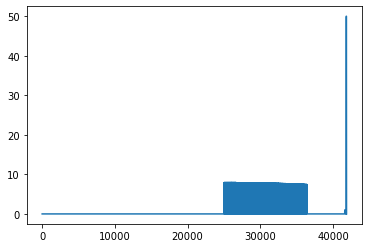

In [5]:
tgt1=np.zeros(41600)
y1_te=np.reshape(tgt1,(128,25,13))
# y1_te=np.swapaxes(y1_te,0,2)
y1_te[77:112,:,:] = aaa
# y1_te[90:110,:,:] = aaa
freq =np.linspace(2e9,3e9,128)
target1=np.reshape(y1_te,(41600))
# np.shape(target1)
target2 = np.ones(128)
target2[77:112] = 0.14
# target2[60:100] = 0.14
# target2[90:110] = 0.1
target3 = np.zeros(128)
target3[77:112] = 50
# target3[60:100] = 50
# target3[90:110] = 50

target = np.concatenate((target1,target2,target3),axis=0)
print(np.shape(target))
plt.plot((target))

In [6]:
np.shape(aaa)

(6, 25, 13)

In [10]:
# def get_mse3(pop, tar,n_i,n_p):
#     isl = np.array(list(chain.from_iterable(pop)))
#     Gtar = tar[0:41600]
#     Gtar = np.reshape(Gtar,(128,25,13))
#     Gtar = Gtar[52,:,:]
#     Star = tar[41600:41728]
#     Rtar = tar[41728:41856]
    
#     tar1 = np.tile(Gtar, (n_i*n_p,1,1,1))
#     tar2 = np.tile(Star, (n_i*n_p,1))
#     tar3 = np.tile(Rtar, (n_i*n_p,1))
    
#     y = pred.prediction(isl)
#     y1=y[:,0:41600]
#     y1=np.reshape(y1,(n_i*n_p,13,25,128))
#     y1=np.swapaxes(y1,1,3)
#     y1=y1[:,48:54,:,:]

#     y2=y[:,41600:41728]
#     y3=y[:,41728:41856]
# #     print(np.shape(Gtar),np.shape(tar1),np.shape(y1))
#     m_1 = np.mean(np.mean(np.mean((y1-tar1)**2, axis = 3), axis = 2), axis =1)
# #     m_1 = np.reshape(m_1,(n_i*n_p,325))
#     m_2 = np.mean((y2-tar2)**2, axis = 1)
#     m_3 = np.mean((y3-tar3)**2, axis = 1)
# #     print(np.shape(m_1),np.shape(m_2))
#     mse = 0.01*m_1 + m_2 + 0.01*m_3
#     print(m_1,m_2,m_3)
#     return np.reshape(mse,(n_i,n_p))

In [11]:
# def get_msed(pop, tar,n_i,n_p):
#     isl = np.array(list(chain.from_iterable(pop)))
#     Gtar = tar[0:41600]
#     Gtar = np.reshape(Gtar,(128,25,13))
#     Ltar = Gtar[80,:,:]
# #     Mtar = Gtar[100,:,:]
    
#     Ptar = tar[41600:41728]
#     Star = Ptar[80]
# #     Qtar = Ptar[100]
#     Btar = tar[41728:41856]
#     Rtar = Btar[80]
# #     Ctar = Btar[100]
    
#     tar1 = np.tile(Ltar, (n_i*n_p,1,1,1))
# #     tar6 = np.tile(Mtar, (n_i*n_p,1,1,1))
#     tar2 = np.tile(Star, (n_i*n_p,1))
#     tar3 = np.tile(Rtar, (n_i*n_p,1))
# #     tar4 = np.tile(Qtar, (n_i*n_p,1))
# #     tar5 = np.tile(Ctar, (n_i*n_p,1))
    
#     y = pred.prediction(isl)
#     y1=y[:,0:41600]
#     y1=np.reshape(y1,(n_i*n_p,13,25,128))
#     y1=np.swapaxes(y1,1,3)
#     ya=y1[:,60:100,:,:]
# #     yb=y1[:,90:110,:,:]

#     Y2=y[:,41600:41728]
#     y2=Y2[:,60:100]
# #     Y1=Y2[:,90:110]
#     Y3=y[:,41728:41856]
#     y3=Y3[:,60:100]
# #     Y4=Y3[:,90:110]
# #     print(np.shape(Gtar),np.shape(tar1),np.shape(y1))
#     m_0 = np.mean(np.mean(np.mean((ya-tar1)**2, axis = 3), axis = 2), axis =1)
# #     m_1 = np.mean(np.mean(np.mean((yb-tar6)**2, axis = 3), axis = 2), axis =1)

#     m_2 = np.mean((y2-tar2)**2, axis = 1)
# #     m_4 = np.mean((Y1-tar4)**2, axis = 1)
#     m_3 = np.mean((y3-tar3)**2, axis = 1)
# #     m_5 = np.mean((Y4-tar5)**2, axis = 1)
#     mse = 0.5*m_0  + m_2 + 0.01*(m_3)
# #     mse = 0.5*(m_0+m_1)  + (m_2+m_4) + 0.01*(m_3+m_5)
# #     print(m)
#     return np.reshape(mse,(n_i,n_p))

In [12]:
# get_msed(population,target,N_I,N_P)
# np.shape(pred.get_mse(population,target,N_I,N_P))

In [14]:
import datetime
t1 = datetime.datetime.now()
print(t1)
de_nn.de_isl(pred.get_mse3,target,L,U,num_layers_i = 9, num_isles = N_I, num_gens = 4,
	  poplist = population, mut = 0.8, crossp = 0.8, popsize = N_P,
	  its = 50 , lenp = 0.08, lins = 0.06, verbose = 0);
t2 = datetime.datetime.now() - t1
print('time_taken=',t2)

2024-05-01 17:47:35.432157
(3, 54, 9)
Epoch #:1
(3, 54)
Iteration =    0  -- 
===== [0.00629669 0.00803845 0.00471666] ======
Iteration =    1  -- 
===== [0.00629669 0.00803845 0.00471666] ======
Iteration =    2  -- 
===== [0.0048719  0.00803845 0.00471666] ======
Iteration =    3  -- 
===== [0.00346877 0.00803845 0.00471666] ======
Iteration =    4  -- 
===== [0.00346877 0.00803845 0.00471666] ======
Iteration =    5  -- 
===== [0.00346877 0.00803845 0.00471666] ======
Iteration =    6  -- 
===== [0.00346877 0.00803845 0.00471666] ======
Iteration =    7  -- 
===== [0.00346877 0.00803845 0.00471666] ======
Iteration =    8  -- 
===== [0.00346877 0.00679482 0.00471666] ======
Iteration =    9  -- 
===== [0.00289047 0.00556955 0.00471666] ======
Iteration =   10  -- 
===== [0.00289047 0.00556955 0.00471666] ======
Iteration =   11  -- 
===== [0.00289047 0.00556955 0.00471666] ======
Iteration =   12  -- 
===== [0.00289047 0.00556955 0.00471666] ======
Iteration =   13  -- 
===== [0.002

Iteration =   14  -- 
===== [0.00194532 0.0018131  0.00211821] ======
Iteration =   15  -- 
===== [0.00168603 0.0018131  0.00211821] ======
Iteration =   16  -- 
===== [0.00168603 0.0018131  0.00211821] ======
Iteration =   17  -- 
===== [0.00168603 0.0018131  0.00211821] ======
Iteration =   18  -- 
===== [0.00168603 0.0018131  0.00211821] ======
Iteration =   19  -- 
===== [0.00168603 0.0018131  0.00211821] ======
Iteration =   20  -- 
===== [0.00168603 0.0018131  0.00211821] ======
Iteration =   21  -- 
===== [0.00168603 0.0018131  0.00211821] ======
Iteration =   22  -- 
===== [0.00168603 0.0018131  0.00211821] ======
Iteration =   23  -- 
===== [0.00168603 0.0018131  0.00211821] ======
Iteration =   24  -- 
===== [0.00168603 0.0018131  0.00211821] ======
Iteration =   25  -- 
===== [0.00168603 0.0018131  0.00211821] ======
Iteration =   26  -- 
===== [0.00168603 0.0018131  0.00211821] ======
Iteration =   27  -- 
===== [0.00168603 0.0018131  0.00211821] ======
Iteration =   28  --

In [120]:
# t1 = datetime.datetime.now()
# print(t1)
# for pp in range(10):
#     population = create_population(L,U,N_P,N_I)
#     de_nn.de_isl(pred.get_mse3,target,L,U,num_layers_i = 9, num_isles = N_I, num_gens = 4,
#           poplist = population, mut = 0.8, crossp = 0.8, popsize = N_P,
#           its = 50 , lenp = 0.08, lins = 0.06, verbose = 0);

#     with open('Data_bfits.txt', 'a') as bfit:
#         bfit.write
#         ('--------------------------------------------------------------------------------------------')
#     with open('Data_best.txt', 'a') as best:
#         best.write
#         ('--------------------------------------------------------------------------------------------')

# t2 = datetime.datetime.now() - t1
# print('time_taken=',t2)

2024-04-29 18:49:03.653171
(3, 54, 9)
Epoch #:1
(3, 54)
Iteration =    0  -- 
===== [0.61352263 0.39350642 0.2992193 ] ======
Iteration =    1  -- 
===== [0.39644637 0.39350642 0.2992193 ] ======
Iteration =    2  -- 
===== [0.34843672 0.39350642 0.2992193 ] ======
Iteration =    3  -- 
===== [0.34843672 0.39350642 0.27271388] ======
Iteration =    4  -- 
===== [0.34843672 0.39350642 0.27271388] ======
Iteration =    5  -- 
===== [0.34843672 0.39350642 0.27271388] ======
Iteration =    6  -- 
===== [0.34843672 0.39350642 0.27271388] ======
Iteration =    7  -- 
===== [0.34843672 0.31186538 0.27271388] ======
Iteration =    8  -- 
===== [0.34843672 0.31186538 0.26137274] ======
Iteration =    9  -- 
===== [0.33166083 0.31186538 0.26137274] ======
Iteration =   10  -- 
===== [0.33166083 0.31186538 0.26137274] ======
Iteration =   11  -- 
===== [0.33166083 0.31186538 0.26137274] ======
Iteration =   12  -- 
===== [0.33166083 0.31186538 0.26137274] ======
Iteration =   13  -- 
===== [0.331

Iteration =   15  -- 
===== [0.24856316 0.25267027 0.24537688] ======
Iteration =   16  -- 
===== [0.24856316 0.25267027 0.24537688] ======
Iteration =   17  -- 
===== [0.24856316 0.25267027 0.24537688] ======
Iteration =   18  -- 
===== [0.24856316 0.25267027 0.24537688] ======
Iteration =   19  -- 
===== [0.24856316 0.25267027 0.24537688] ======
Iteration =   20  -- 
===== [0.24856316 0.25267027 0.24537688] ======
Iteration =   21  -- 
===== [0.24856316 0.25267027 0.24537688] ======
Iteration =   22  -- 
===== [0.24856316 0.25267027 0.24537688] ======
Iteration =   23  -- 
===== [0.24856316 0.25267027 0.24537688] ======
Iteration =   24  -- 
===== [0.24856316 0.25267027 0.24537688] ======
Iteration =   25  -- 
===== [0.24856316 0.25267027 0.24537688] ======
Iteration =   26  -- 
===== [0.24856316 0.25267027 0.24363353] ======
Iteration =   27  -- 
===== [0.24856316 0.25267027 0.24363353] ======
Iteration =   28  -- 
===== [0.24856316 0.25267027 0.24363353] ======
Iteration =   29  --

(3, 54, 9)
Epoch #:1
(3, 54)
Iteration =    0  -- 
===== [0.41317962 0.39817849 0.28889252] ======
Iteration =    1  -- 
===== [0.36166132 0.38571509 0.28889252] ======
Iteration =    2  -- 
===== [0.31618058 0.38571509 0.28889252] ======
Iteration =    3  -- 
===== [0.31618058 0.38571509 0.28889252] ======
Iteration =    4  -- 
===== [0.31618058 0.38571509 0.28889252] ======
Iteration =    5  -- 
===== [0.31618058 0.38571509 0.28889252] ======
Iteration =    6  -- 
===== [0.31618058 0.38571509 0.27281291] ======
Iteration =    7  -- 
===== [0.31618058 0.32257892 0.27281291] ======
Iteration =    8  -- 
===== [0.31618058 0.32257892 0.27281291] ======
Iteration =    9  -- 
===== [0.31618058 0.32257892 0.27281291] ======
Iteration =   10  -- 
===== [0.31618058 0.32257892 0.27281291] ======
Iteration =   11  -- 
===== [0.31618058 0.32257892 0.27281291] ======
Iteration =   12  -- 
===== [0.31618058 0.32257892 0.27281291] ======
Iteration =   13  -- 
===== [0.31618058 0.32257892 0.27281291

Iteration =   16  -- 
===== [0.25261721 0.23698691 0.2518486 ] ======
Iteration =   17  -- 
===== [0.25261721 0.23698691 0.2518486 ] ======
Iteration =   18  -- 
===== [0.25261721 0.23698691 0.2518486 ] ======
Iteration =   19  -- 
===== [0.25261721 0.23698691 0.2518486 ] ======
Iteration =   20  -- 
===== [0.25261721 0.23698691 0.2518486 ] ======
Iteration =   21  -- 
===== [0.25261721 0.23698691 0.2518486 ] ======
Iteration =   22  -- 
===== [0.25261721 0.23698691 0.2518486 ] ======
Iteration =   23  -- 
===== [0.25261721 0.23698691 0.2518486 ] ======
Iteration =   24  -- 
===== [0.25261721 0.23698691 0.2518486 ] ======
Iteration =   25  -- 
===== [0.25261721 0.23698691 0.2518486 ] ======
Iteration =   26  -- 
===== [0.25261721 0.23698691 0.2518486 ] ======
Iteration =   27  -- 
===== [0.25261721 0.23698691 0.2518486 ] ======
Iteration =   28  -- 
===== [0.25261721 0.23698691 0.2518486 ] ======
Iteration =   29  -- 
===== [0.25261721 0.23698691 0.2518486 ] ======
Iteration =   30  --

(3, 54, 9)
Epoch #:1
(3, 54)
Iteration =    0  -- 
===== [0.37270925 0.32632474 0.4236036 ] ======
Iteration =    1  -- 
===== [0.37270925 0.32632474 0.4236036 ] ======
Iteration =    2  -- 
===== [0.37270925 0.32632474 0.37316255] ======
Iteration =    3  -- 
===== [0.37270925 0.32632474 0.37316255] ======
Iteration =    4  -- 
===== [0.37270925 0.32632474 0.37316255] ======
Iteration =    5  -- 
===== [0.37270925 0.32632474 0.37316255] ======
Iteration =    6  -- 
===== [0.37270925 0.32632474 0.37316255] ======
Iteration =    7  -- 
===== [0.37270925 0.32632474 0.31528939] ======
Iteration =    8  -- 
===== [0.37270925 0.32632474 0.31528939] ======
Iteration =    9  -- 
===== [0.37270925 0.30258403 0.31528939] ======
Iteration =   10  -- 
===== [0.37270925 0.30258403 0.31528939] ======
Iteration =   11  -- 
===== [0.37270925 0.30258403 0.31528939] ======
Iteration =   12  -- 
===== [0.30328095 0.30258403 0.31528939] ======
Iteration =   13  -- 
===== [0.30328095 0.30258403 0.31528939

Iteration =   15  -- 
===== [0.24165005 0.24334591 0.24244875] ======
Iteration =   16  -- 
===== [0.24165005 0.24334591 0.24244875] ======
Iteration =   17  -- 
===== [0.24165005 0.24334591 0.24244875] ======
Iteration =   18  -- 
===== [0.24165005 0.24334591 0.24244875] ======
Iteration =   19  -- 
===== [0.24165005 0.24334591 0.24244875] ======
Iteration =   20  -- 
===== [0.24165005 0.24334591 0.24244875] ======
Iteration =   21  -- 
===== [0.24165005 0.24334591 0.24244875] ======
Iteration =   22  -- 
===== [0.24165005 0.24334591 0.24244875] ======
Iteration =   23  -- 
===== [0.24165005 0.24334591 0.2407891 ] ======
Iteration =   24  -- 
===== [0.24165005 0.24334591 0.2407891 ] ======
Iteration =   25  -- 
===== [0.24165005 0.24334591 0.2407891 ] ======
Iteration =   26  -- 
===== [0.24165005 0.24334591 0.23923522] ======
Iteration =   27  -- 
===== [0.24165005 0.24334591 0.23923522] ======
Iteration =   28  -- 
===== [0.24165005 0.24334591 0.23923522] ======
Iteration =   29  --

(3, 54, 9)
Epoch #:1
(3, 54)
Iteration =    0  -- 
===== [0.39351    0.32165933 0.36374504] ======
Iteration =    1  -- 
===== [0.39351    0.30863541 0.36374504] ======
Iteration =    2  -- 
===== [0.39351    0.30863541 0.34243748] ======
Iteration =    3  -- 
===== [0.35009134 0.30863541 0.31085017] ======
Iteration =    4  -- 
===== [0.29854252 0.30057353 0.31085017] ======
Iteration =    5  -- 
===== [0.29854252 0.28933686 0.31085017] ======
Iteration =    6  -- 
===== [0.29854252 0.28747104 0.31085017] ======
Iteration =    7  -- 
===== [0.29854252 0.28747104 0.31085017] ======
Iteration =    8  -- 
===== [0.29854252 0.28747104 0.31085017] ======
Iteration =    9  -- 
===== [0.29854252 0.28747104 0.31085017] ======
Iteration =   10  -- 
===== [0.29854252 0.28747104 0.31085017] ======
Iteration =   11  -- 
===== [0.29854252 0.28747104 0.31085017] ======
Iteration =   12  -- 
===== [0.29854252 0.28747104 0.31085017] ======
Iteration =   13  -- 
===== [0.29854252 0.28224584 0.31085017

Iteration =   14  -- 
===== [0.24300433 0.23927933 0.23927618] ======
Iteration =   15  -- 
===== [0.24300433 0.23927933 0.23927618] ======
Iteration =   16  -- 
===== [0.23900772 0.23927933 0.23927618] ======
Iteration =   17  -- 
===== [0.23900772 0.23927933 0.23927618] ======
Iteration =   18  -- 
===== [0.23900772 0.23927933 0.23927618] ======
Iteration =   19  -- 
===== [0.23697944 0.23927933 0.23927618] ======
Iteration =   20  -- 
===== [0.23697944 0.23927933 0.23927618] ======
Iteration =   21  -- 
===== [0.23697944 0.23927933 0.23927618] ======
Iteration =   22  -- 
===== [0.23697944 0.23927933 0.23927618] ======
Iteration =   23  -- 
===== [0.23697944 0.23927933 0.23927618] ======
Iteration =   24  -- 
===== [0.23697944 0.23927933 0.23927618] ======
Iteration =   25  -- 
===== [0.23697944 0.23927933 0.23927618] ======
Iteration =   26  -- 
===== [0.23697944 0.23927933 0.23927618] ======
Iteration =   27  -- 
===== [0.23697944 0.23927933 0.23927618] ======
Iteration =   28  --

(3, 54, 9)
Epoch #:1
(3, 54)
Iteration =    0  -- 
===== [0.38930107 0.59871262 0.41004605] ======
Iteration =    1  -- 
===== [0.38930107 0.4582642  0.28219579] ======
Iteration =    2  -- 
===== [0.38930107 0.36196371 0.28219579] ======
Iteration =    3  -- 
===== [0.34631945 0.36196371 0.28219579] ======
Iteration =    4  -- 
===== [0.34631945 0.36196371 0.28219579] ======
Iteration =    5  -- 
===== [0.33955622 0.36196371 0.28219579] ======
Iteration =    6  -- 
===== [0.33955622 0.35741339 0.28219579] ======
Iteration =    7  -- 
===== [0.33955622 0.35741339 0.28219579] ======
Iteration =    8  -- 
===== [0.28869436 0.35741339 0.28219579] ======
Iteration =    9  -- 
===== [0.28869436 0.35741339 0.28219579] ======
Iteration =   10  -- 
===== [0.28869436 0.35741339 0.28219579] ======
Iteration =   11  -- 
===== [0.28869436 0.32950014 0.28219579] ======
Iteration =   12  -- 
===== [0.28869436 0.32950014 0.28219579] ======
Iteration =   13  -- 
===== [0.28869436 0.32950014 0.28219579

Iteration =   16  -- 
===== [0.25809582 0.24601374 0.24507116] ======
Iteration =   17  -- 
===== [0.25809582 0.24601374 0.24507116] ======
Iteration =   18  -- 
===== [0.25809582 0.24601374 0.24507116] ======
Iteration =   19  -- 
===== [0.25809582 0.24601374 0.24507116] ======
Iteration =   20  -- 
===== [0.25809582 0.24601374 0.24507116] ======
Iteration =   21  -- 
===== [0.25809582 0.24601374 0.24507116] ======
Iteration =   22  -- 
===== [0.25809582 0.24601374 0.24507116] ======
Iteration =   23  -- 
===== [0.25809582 0.24601374 0.24507116] ======
Iteration =   24  -- 
===== [0.25809582 0.24601374 0.24507116] ======
Iteration =   25  -- 
===== [0.25809582 0.24601374 0.24507116] ======
Iteration =   26  -- 
===== [0.25809582 0.24601374 0.24507116] ======
Iteration =   27  -- 
===== [0.25809582 0.24601374 0.24507116] ======
Iteration =   28  -- 
===== [0.25809582 0.24601374 0.24507116] ======
Iteration =   29  -- 
===== [0.25702976 0.24601374 0.24507116] ======
Iteration =   30  --

(3, 54, 9)
Epoch #:1
(3, 54)
Iteration =    0  -- 
===== [0.37339564 0.3777989  0.56662272] ======
Iteration =    1  -- 
===== [0.37339564 0.3777989  0.41261931] ======
Iteration =    2  -- 
===== [0.37339564 0.32315381 0.41261931] ======
Iteration =    3  -- 
===== [0.37134598 0.32315381 0.41261931] ======
Iteration =    4  -- 
===== [0.37134598 0.32315381 0.30358813] ======
Iteration =    5  -- 
===== [0.37134598 0.32315381 0.30358813] ======
Iteration =    6  -- 
===== [0.37134598 0.32315381 0.30358813] ======
Iteration =    7  -- 
===== [0.37134598 0.32315381 0.30358813] ======
Iteration =    8  -- 
===== [0.37134598 0.32315381 0.30358813] ======
Iteration =    9  -- 
===== [0.37134598 0.30200475 0.30358813] ======
Iteration =   10  -- 
===== [0.37134598 0.30200475 0.30358813] ======
Iteration =   11  -- 
===== [0.37134598 0.30200475 0.30358813] ======
Iteration =   12  -- 
===== [0.37134598 0.30200475 0.30358813] ======
Iteration =   13  -- 
===== [0.37134598 0.30200475 0.28969091

Iteration =   14  -- 
===== [0.25464566 0.24932202 0.24931934] ======
Iteration =   15  -- 
===== [0.25464566 0.24932202 0.24399142] ======
Iteration =   16  -- 
===== [0.25464566 0.24748196 0.24399142] ======
Iteration =   17  -- 
===== [0.25464566 0.24748196 0.24399142] ======
Iteration =   18  -- 
===== [0.25464566 0.24748196 0.24399142] ======
Iteration =   19  -- 
===== [0.25464566 0.24748196 0.24399142] ======
Iteration =   20  -- 
===== [0.25464566 0.24748196 0.24399142] ======
Iteration =   21  -- 
===== [0.25464566 0.24748196 0.24399142] ======
Iteration =   22  -- 
===== [0.25464566 0.24748196 0.24399142] ======
Iteration =   23  -- 
===== [0.25464566 0.24512908 0.24100368] ======
Iteration =   24  -- 
===== [0.25464566 0.24512908 0.24100368] ======
Iteration =   25  -- 
===== [0.25464566 0.24512908 0.24100368] ======
Iteration =   26  -- 
===== [0.25464566 0.24512908 0.24100368] ======
Iteration =   27  -- 
===== [0.25464566 0.24512908 0.24100368] ======
Iteration =   28  --

(3, 54, 9)
Epoch #:1
(3, 54)
Iteration =    0  -- 
===== [0.33062602 0.31412995 0.4109    ] ======
Iteration =    1  -- 
===== [0.33062602 0.28564233 0.40452683] ======
Iteration =    2  -- 
===== [0.32840306 0.28564233 0.40452683] ======
Iteration =    3  -- 
===== [0.32840306 0.28564233 0.40452683] ======
Iteration =    4  -- 
===== [0.32840306 0.28496749 0.40452683] ======
Iteration =    5  -- 
===== [0.32840306 0.28496749 0.40452683] ======
Iteration =    6  -- 
===== [0.31660182 0.28496749 0.33620541] ======
Iteration =    7  -- 
===== [0.31660182 0.28496749 0.33620541] ======
Iteration =    8  -- 
===== [0.31660182 0.28149872 0.33620541] ======
Iteration =    9  -- 
===== [0.31660182 0.28149872 0.33620541] ======
Iteration =   10  -- 
===== [0.28753737 0.26003007 0.30359506] ======
Iteration =   11  -- 
===== [0.28753737 0.26003007 0.30359506] ======
Iteration =   12  -- 
===== [0.28753737 0.26003007 0.30359506] ======
Iteration =   13  -- 
===== [0.28753737 0.26003007 0.30359506

Iteration =   14  -- 
===== [0.24921884 0.25237773 0.25028376] ======
Iteration =   15  -- 
===== [0.24921884 0.25237773 0.25028376] ======
Iteration =   16  -- 
===== [0.24921884 0.25237773 0.25028376] ======
Iteration =   17  -- 
===== [0.24921884 0.25237773 0.25028376] ======
Iteration =   18  -- 
===== [0.24921884 0.25237773 0.25028376] ======
Iteration =   19  -- 
===== [0.24921884 0.25237773 0.25028376] ======
Iteration =   20  -- 
===== [0.24921884 0.25237773 0.24981944] ======
Iteration =   21  -- 
===== [0.24921884 0.25237773 0.24981944] ======
Iteration =   22  -- 
===== [0.24921884 0.25237773 0.24981944] ======
Iteration =   23  -- 
===== [0.24921884 0.25237773 0.24981944] ======
Iteration =   24  -- 
===== [0.24921884 0.25237773 0.24981944] ======
Iteration =   25  -- 
===== [0.24921884 0.25237773 0.24981944] ======
Iteration =   26  -- 
===== [0.24921884 0.25237773 0.24981944] ======
Iteration =   27  -- 
===== [0.24921884 0.25237773 0.24981944] ======
Iteration =   28  --

(3, 54, 9)
Epoch #:1
(3, 54)
Iteration =    0  -- 
===== [0.31815639 0.36515896 0.34532113] ======
Iteration =    1  -- 
===== [0.31815639 0.34064753 0.34532113] ======
Iteration =    2  -- 
===== [0.31815639 0.3392679  0.34532113] ======
Iteration =    3  -- 
===== [0.31815639 0.3392679  0.34532113] ======
Iteration =    4  -- 
===== [0.31815639 0.31304875 0.34532113] ======
Iteration =    5  -- 
===== [0.31815639 0.31304875 0.34532113] ======
Iteration =    6  -- 
===== [0.31815639 0.25839528 0.34532113] ======
Iteration =    7  -- 
===== [0.31815639 0.25839528 0.34532113] ======
Iteration =    8  -- 
===== [0.31815639 0.25839528 0.34532113] ======
Iteration =    9  -- 
===== [0.27755387 0.25839528 0.34532113] ======
Iteration =   10  -- 
===== [0.27755387 0.25839528 0.32373859] ======
Iteration =   11  -- 
===== [0.27755387 0.25839528 0.32373859] ======
Iteration =   12  -- 
===== [0.27755387 0.25839528 0.32373859] ======
Iteration =   13  -- 
===== [0.27755387 0.25839528 0.32373859

Iteration =   14  -- 
===== [0.2496376  0.25783853 0.24631062] ======
Iteration =   15  -- 
===== [0.2496376  0.25783853 0.24631062] ======
Iteration =   16  -- 
===== [0.2496376  0.25783853 0.24631062] ======
Iteration =   17  -- 
===== [0.2496376  0.25783853 0.24631062] ======
Iteration =   18  -- 
===== [0.2496376  0.25783853 0.24631062] ======
Iteration =   19  -- 
===== [0.2496376  0.25783853 0.24631062] ======
Iteration =   20  -- 
===== [0.2496376  0.25783853 0.24631062] ======
Iteration =   21  -- 
===== [0.2496376  0.25783853 0.24631062] ======
Iteration =   22  -- 
===== [0.2496376  0.25783853 0.24631062] ======
Iteration =   23  -- 
===== [0.2496376  0.25783853 0.24631062] ======
Iteration =   24  -- 
===== [0.2496376  0.25783853 0.24631062] ======
Iteration =   25  -- 
===== [0.2496376  0.25783853 0.24631062] ======
Iteration =   26  -- 
===== [0.2496376  0.25783853 0.24631062] ======
Iteration =   27  -- 
===== [0.2496376  0.25783853 0.24631062] ======
Iteration =   28  --

(3, 54, 9)
Epoch #:1
(3, 54)
Iteration =    0  -- 
===== [0.57247616 0.37810643 0.43203813] ======
Iteration =    1  -- 
===== [0.51055106 0.33442507 0.43203813] ======
Iteration =    2  -- 
===== [0.51055106 0.33275211 0.34576175] ======
Iteration =    3  -- 
===== [0.35731419 0.33127365 0.34576175] ======
Iteration =    4  -- 
===== [0.35731419 0.33127365 0.34576175] ======
Iteration =    5  -- 
===== [0.35658189 0.33127365 0.34576175] ======
Iteration =    6  -- 
===== [0.28448398 0.33127365 0.30696914] ======
Iteration =    7  -- 
===== [0.28448398 0.33127365 0.30696914] ======
Iteration =    8  -- 
===== [0.28448398 0.33127365 0.30696914] ======
Iteration =    9  -- 
===== [0.28448398 0.31129579 0.30696914] ======
Iteration =   10  -- 
===== [0.27948266 0.31129579 0.30696914] ======
Iteration =   11  -- 
===== [0.27948266 0.31129579 0.30696914] ======
Iteration =   12  -- 
===== [0.27948266 0.31129579 0.30696914] ======
Iteration =   13  -- 
===== [0.27948266 0.31129579 0.30696914

Iteration =   16  -- 
===== [0.24283202 0.24276926 0.24856435] ======
Iteration =   17  -- 
===== [0.24283202 0.24276926 0.24856435] ======
Iteration =   18  -- 
===== [0.24283202 0.24276926 0.24856435] ======
Iteration =   19  -- 
===== [0.24283202 0.24276926 0.24856435] ======
Iteration =   20  -- 
===== [0.24283202 0.24276926 0.24856435] ======
Iteration =   21  -- 
===== [0.24283202 0.24276926 0.24856435] ======
Iteration =   22  -- 
===== [0.24283202 0.24276926 0.24856435] ======
Iteration =   23  -- 
===== [0.24283202 0.24276926 0.24856435] ======
Iteration =   24  -- 
===== [0.24283202 0.24276926 0.24856435] ======
Iteration =   25  -- 
===== [0.24283202 0.24276926 0.24856435] ======
Iteration =   26  -- 
===== [0.24283202 0.24276926 0.24856435] ======
Iteration =   27  -- 
===== [0.24283202 0.24276926 0.24856435] ======
Iteration =   28  -- 
===== [0.24283202 0.24276926 0.24856435] ======
Iteration =   29  -- 
===== [0.24283202 0.24276926 0.24856435] ======
Iteration =   30  --

(3, 54, 9)
Epoch #:1
(3, 54)
Iteration =    0  -- 
===== [0.39212446 0.35366924 0.34668339] ======
Iteration =    1  -- 
===== [0.39212446 0.35366924 0.34668339] ======
Iteration =    2  -- 
===== [0.39212446 0.29551492 0.34668339] ======
Iteration =    3  -- 
===== [0.39212446 0.29551492 0.34668339] ======
Iteration =    4  -- 
===== [0.39212446 0.29551492 0.34668339] ======
Iteration =    5  -- 
===== [0.39212446 0.29551492 0.34668339] ======
Iteration =    6  -- 
===== [0.39212446 0.29551492 0.34668339] ======
Iteration =    7  -- 
===== [0.39212446 0.29551492 0.34668339] ======
Iteration =    8  -- 
===== [0.39212446 0.29551492 0.34668339] ======
Iteration =    9  -- 
===== [0.39212446 0.29551492 0.34668339] ======
Iteration =   10  -- 
===== [0.39212446 0.29551492 0.34668339] ======
Iteration =   11  -- 
===== [0.38788904 0.29551492 0.344227  ] ======
Iteration =   12  -- 
===== [0.34144685 0.29551492 0.344227  ] ======
Iteration =   13  -- 
===== [0.34144685 0.29551492 0.344227  

Iteration =   16  -- 
===== [0.27175467 0.26057026 0.25692006] ======
Iteration =   17  -- 
===== [0.27175467 0.26057026 0.25692006] ======
Iteration =   18  -- 
===== [0.27175467 0.26057026 0.25692006] ======
Iteration =   19  -- 
===== [0.27175467 0.26057026 0.25692006] ======
Iteration =   20  -- 
===== [0.27175467 0.25578702 0.25692006] ======
Iteration =   21  -- 
===== [0.27175467 0.25578702 0.25692006] ======
Iteration =   22  -- 
===== [0.27175467 0.25578702 0.25692006] ======
Iteration =   23  -- 
===== [0.27175467 0.25578702 0.25692006] ======
Iteration =   24  -- 
===== [0.27175467 0.25578702 0.25692006] ======
Iteration =   25  -- 
===== [0.27175467 0.25578702 0.25692006] ======
Iteration =   26  -- 
===== [0.27175467 0.25578702 0.25692006] ======
Iteration =   27  -- 
===== [0.27175467 0.25578702 0.25692006] ======
Iteration =   28  -- 
===== [0.27175467 0.25578702 0.25692006] ======
Iteration =   29  -- 
===== [0.27175467 0.25578702 0.25692006] ======
Iteration =   30  --

# MATLAB for fitness evaluation

In [9]:
# import datetime
# t1 = datetime.datetime.now()
# print(t1)
# de_nn.de_isl(pred.get_mse_Mat,target,L,U,num_layers_i = 9, num_isles = N_I, num_gens = 1,
# 	  poplist = population, mut = 0.8, crossp = 0.8, popsize = N_P,
# 	  its = 1 , lenp = 0.08, lins = 0.06, verbose = 0);
# t2 = datetime.datetime.now() - t1
# print('time_taken=',t2)

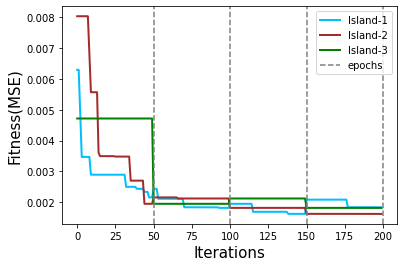

In [18]:
from matplotlib.ticker import MultipleLocator
pf1=[]
pf2=[]
pf3=[]

with open ("Data_bfits.txt","r") as f:
    for line in f:
        p=line.split()
#         print(p[1])
        pf1.append(float(p[1][1:]))
        pf2.append(float(p[2][:]))
        pf3.append(float(p[3][:-1]))
# plt.figure(figsize = (11, 8),dpi=300)    
plt.plot(pf1,label='Island-1',linewidth=2,color = 'deepskyblue')
plt.plot(pf2,label='Island-2',linewidth=2,color = 'brown')
plt.plot(pf3,label='Island-3',linewidth=2,color = 'green')
# ax = plt.gca()
# ax.spines['top'].set_linewidth(2)
# ax.spines['right'].set_linewidth(2)
# ax.spines['bottom'].set_linewidth(2)
# ax.spines['left'].set_linewidth(2)
plt.axvline(x=50, label='epochs',color='grey', linestyle='--')
plt.axvline(x=100, color='grey', linestyle='--')
plt.axvline(x=150, color='grey', linestyle='--')
plt.axvline(x=200, color='grey', linestyle='--')
# plt.axvline(x=125, color='grey', linestyle='--')
# plt.axvline(x=150, color='grey', linestyle='--')
# ax.yaxis.set_major_locator(MultipleLocator(0.050))
plt.xlabel('Iterations',fontsize=15)
plt.ylabel('Fitness(MSE)',fontsize=15)
# plt.xticks(fontsize=25)
# plt.yticks(fontsize=25)
plt.legend(fontsize=10)
# plt.xlim(-1,201)
# plt.savefig('DE_fitness.png')
plt.show()    

NameError: name 'bests' is not defined

In [19]:
sol = np.array([array([  9.05407366,  29.        ,  26.30711645,  28.27938492,
       100.        ,  70.33372656,  59.79988859,  54.00349939,
         5.51163798]), array([ 5.        , 29.        , 25.24183273, 29.        , 82.77067583,
       58.23068214, 64.46625714, 33.47215512,  5.39872511]), array([ 9.23407427, 29.        , 27.53231935, 29.        , 67.58495367,
       27.47261514, 37.71028081, 25.08895434,  5.38124115])])

# solopt = np.array([array([ 17.3515956 ,  14.90611288,  25.13956546,  19.90165911,
#         27.24486305,  28.97076149,  21.2508792 ,  13.55396453,
#         39.84597655,  93.19549105,  62.67713434, 100.        ,
#         47.80938195,  67.41919086,  70.29225585,  20.46916329,
#          5.32039107]), array([ 18.48491946,  16.04874451,  25.81219576,  17.20866702,
#         28.98425548,  28.81982894,  19.80344775,  12.99084381,
#         61.47950577, 100.        ,  74.0670471 ,  88.14141564,
#         41.100817  ,  88.45656973,  67.14338269,  26.52991874,
#          5.29956596]), array([ 20.44747239,  15.48924396,  27.23915494,  17.06191934,
#         30.        ,  30.        ,  22.54158324,  10.59377144,
#         74.32638936, 100.        ,  88.44992711,  98.78340052,
#         65.75912886,  76.01650904,  81.62337645,  34.60995023,
#          5.22021075])])

# sol24optimum = np.array([array([10.33515377, 17.08185976, 21.77063437, 28.94121245, 16.10025555,
#        17.32437103, 25.86534132, 10.        , 35.46881045, 44.41356613,
#        97.54721006, 30.22488098, 10.88376268, 27.90454718, 10.        ,
#        10.        ,  5.60172158]), array([10.01174425, 17.08929798, 22.28243902, 28.51467249, 15.41956138,
#        17.71300651, 25.04835951, 10.        , 30.06779408, 41.38546592,
#        97.73241265, 26.9145646 , 12.49010717, 22.75788486, 10.23294989,
#        10.67860945,  5.65561008]), array([10.2990856 , 16.9337446 , 22.61721395, 29.06342086, 14.77065583,
#        17.15346828, 25.86174664, 10.        , 41.35411273, 53.47209214,
#        98.60433121, 26.05378626, 10.26620964, 29.93981886, 10.29507993,
#        23.13564845,  5.83560914])])


In [20]:
sol = np.reshape(sol,(3,9))
print(sol.shape)

(3, 9)


In [21]:
y=pred.prediction(sol)
np.shape(y)

(3, 41856)

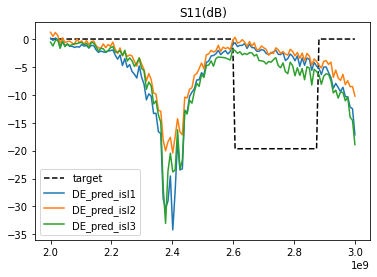

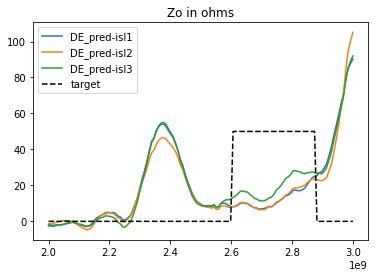

In [22]:
freq =np.linspace(2e9,3e9,128)
y1=y[:,0:41600]
y2=y[:,41600:41728]
y3=y[:,41728:41856]

# y2_te = np.reshape(target1,(1,13,25,128))
# y2_te=np.swapaxes(y2_te,1,3)
y1_te=np.reshape(y1,(3,13,25,128))
y1_te=np.swapaxes(y1_te,1,3)
tgt = np.reshape(target1,(1,128,25,13))

plt.plot(freq,10*log(target2),label='target',color ='black',ls ='--')
plt.plot(freq,10*log(y2[0]),label='DE_pred_isl1')
plt.plot(freq,10*log(y2[1]),label='DE_pred_isl2')
plt.plot(freq,10*log(y2[2]),label='DE_pred_isl3')
plt.title('S11(dB)')
plt.legend()
# plt.ylim(0,1)
plt.show()

ff=105
patternt = tgt[0,ff,:,:]
patternD=y1_te[0,ff,:,:]
# fig,(ax1,ax2) = plt.subplots(1,2)

# ax1.imshow(patternt)
# ax1.set_title('tgt_pattern')
# ax2.imshow(patternD)
# ax2.set_title('Dnn_Pattern')
# plt.show()


#Imp 1D plot
plt.plot(freq,y3[0],label='DE_pred-isl1')
plt.plot(freq,y3[1],label='DE_pred-isl2')
plt.plot(freq,y3[2],label='DE_pred-isl3')
plt.plot(freq,target3,label='target',color ='black',ls ='--')
plt.title('Zo in ohms')
plt.legend()
# plt.ylim(0,1)
plt.show()

In [6]:
isl = np.array(list(chain.from_iterable(population)))
isl.shape

(15, 9)

In [3]:
pop = np.loadtxt('Data_best_10run.txt')

In [2]:
def polar_to_cartesian_mat(pop):
#     isl = np.array(list(chain.from_iterable(pop)))
    rad = pop[:,0:4]
    phi = pop[:,4:8]
    alp = pop[:,8]
    rad1 = np.zeros((np.shape(pop)[0],8))
    phi1 = np.zeros((np.shape(pop)[0],8))
    
    for i in range (np.shape(pop)[0]):
        for j in range(4):
            rad1[i,j] = rad[i,j]
            phi1[i,j] = phi[i,j]
            rad1[i, j+4] = rad[i, 3-j]
            phi1[i, j+4] = phi[i, 3-j]
    
    tht = np.zeros((np.shape(pop)[0],8))

    phi_sum = np.cumsum(phi1, axis=1)
    # print(alp, '\n', phi1)
    for i in range (np.shape(pop)[0]):
        for j in range(8):
            tht[i,j] = phi_sum[i,j]*alp[i]/phi_sum[i,-1]
   
    X=[]
    Y=[]
    for i in range(np.shape(pop)[0]):
        r, t = rad1[i], tht[i]
        xc = np.zeros(8)
        yc = np.zeros(8)

        for j in range (8):
            xc[j] = r[j]*math.cos(t[j])
            yc[j] = r[j]*math.sin(t[j])
        x1 = xc[0:4]
        x2 = np.flip(x1)
        y1 = yc[0:4]
        y2 = -y1
        y2 = np.flip(y2)
        x3 = np.append(x1,x2)
        y3 = np.append(y1,y2)
        if (np.all(x3<0) or np.all(x3>0)):
            false_ind = np.where(np.logical_and(x3<1,x3>-1))[0]
            for ind in false_ind:
                if x3[ind] > 0:
                    x3[ind] = -1.2
                else:
                    x3[ind] = 1.2
        
        X.append(x3/1000)
        Y.append(y3/1000)
        np.savetxt('X_DE_mat10run.txt',X,fmt='%5.5f', delimiter = '\t')
        np.savetxt('Y_DE_mat10run.txt',Y,fmt='%5.5f', delimiter = '\t')
    return (X,Y)

In [4]:
# sol=sol[2,:]
# sol = np.reshape(sol,(1,9))
# sol.shape
polar_to_cartesian_mat(pop)

([array([ 0.00511856, -0.00235702, -0.01615833, -0.02620263, -0.02620263,
         -0.01615833, -0.00235702,  0.00511856]),
  array([ 0.00296856, -0.00064428, -0.01721596, -0.02621189, -0.02621189,
         -0.01721596, -0.00064428,  0.00296856]),
  array([ 0.00375585, -0.00143096, -0.01756946, -0.02609917, -0.02609917,
         -0.01756946, -0.00143096,  0.00375585]),
  array([ 0.00366256, -0.00216937, -0.01672861, -0.02736789, -0.02736789,
         -0.01672861, -0.00216937,  0.00366256]),
  array([ 0.00649313, -0.00028547, -0.02142239, -0.02570149, -0.02570149,
         -0.02142239, -0.00028547,  0.00649313]),
  array([ 0.00692064, -0.00224268, -0.0156373 , -0.02575795, -0.02575795,
         -0.0156373 , -0.00224268,  0.00692064]),
  array([ 0.00523078, -0.00199706, -0.01662828, -0.02622126, -0.02622126,
         -0.01662828, -0.00199706,  0.00523078]),
  array([ 0.00229391, -0.00110957, -0.01689509, -0.02640105, -0.02640105,
         -0.01689509, -0.00110957,  0.00229391]),
  array(

In [13]:
def mat_run(pop):
#     eng = matlab.engine.start_matlab()
#     eng.gpuDevice(2)
#     polar_to_cartesian_mat(pop)
#     eng.ant128_GPU(nargout=0)
    S11=np.loadtxt('ant128_S11_DE.txt',delimiter=',')
    patt = np.loadtxt('ant128_patt_DE.txt',delimiter=',')
    imp = np.loadtxt('ant128_imp_DE.txt',delimiter=',')
    zo = imp[:,0:128]
#     
    return(S11,patt,zo)

In [65]:
S11=np.loadtxt('ant128_S11_DE.txt',delimiter=',')
patt = np.loadtxt('ant128_patt_DE.txt',delimiter=',')
imp = np.loadtxt('ant128_imp_DE.txt',delimiter=',')
zo = imp[:,0:128]

In [8]:
def get_mse_Mat(tar,n_i,n_p):
#     isl = np.array(list(chain.from_iterable(pop)))
    Gtar = tar[0:41600]
    Gtar = np.reshape(Gtar,(128,25,13))
    Gtar = Gtar[51,:,:]
    
    Star = tar[41600:41728]
    Star = Star[51]
    Rtar = tar[41728:41856]
    Rtar = Rtar[51]
    
    tar1 = np.tile(Gtar, (600,1,1,1))
    tar2 = np.tile(Star, (600,1))
    tar3 = np.tile(Rtar, (600,1))
#     mat_run(isl)
    S11=np.loadtxt('ant128_S11_DE10run.txt',delimiter=',')
    patt = np.loadtxt('ant128_patt_DE10run.txt',delimiter=',')
    imp = np.loadtxt('ant128_imp_DE10run.txt',delimiter=',')
    zo = imp[:,0:128]
    pat=patt/10
    pat=10**pat
    s11=S11/10
    s11=10**s11
    y1 = np.reshape(pat,(600,13,25,128))
    y1=np.swapaxes(y1,1,3)
    y1=y1[:,48:54,:,:]
    
    y2=s11[:,48:54]
    
    y3=zo[:,48:54]
    
    m_1 = np.mean(np.mean(np.mean((y1-tar1)**2, axis = 3), axis = 2), axis =1)
#     m_1 = np.reshape(m_1,(n_i*n_p,325))
    m_2 = np.mean((y2-tar2)**2, axis = 1)
    m_3 = np.mean((y3-tar3)**2, axis = 1)
#     print(np.shape(m_1),np.shape(m_2))
    mse = 0.05*m_1 + 1*m_2 + 0.0001*m_3
#     print(m)    
    return np.reshape(mse,(200,n_i))

233


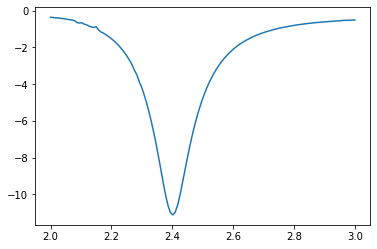

In [126]:
S11=np.loadtxt('ant128_S11_DE.txt',delimiter=',')
S11.shape
rr = np.random.randint(230,299)
print(rr)
freq =np.linspace(2,3,128)
plt.plot(freq,S11[rr])
plt.show()
# y2=S11[:,48:54]

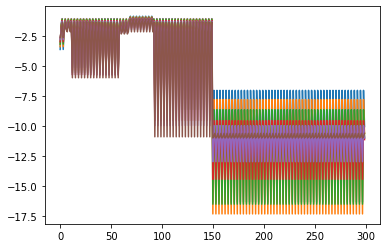

In [94]:
plt.plot(y2)

In [70]:
fitness = get_mse_Mat(target,N_I,N_P)
# fitness.shape

In [71]:
surrogate_fitness = np.loadtxt('Data_best-mat.txt')

In [79]:
def get_mse3(pop, tar,n_i,n_p):
    isl = np.array(list(chain.from_iterable(pop)))
    Gtar = tar[0:41600]
    Gtar = np.reshape(Gtar,(128,25,13))
    Gtar = Gtar[51,:,:]
    
    Star = tar[41600:41728]
    Star = Star[51]
    Rtar = tar[41728:41856]
    Rtar = Rtar[51]
    
    tar1 = np.tile(Gtar, (600,1,1,1))
    tar2 = np.tile(Star, (600,1))
    tar3 = np.tile(Rtar, (600,1))
    
    y = pred.prediction(surrogate_fitness)
    y1=y[:,0:41600]
    y1=np.reshape(y1,(600,13,25,128))
    y1=np.swapaxes(y1,1,3)
    y1=y1[:,48:54,:,:]
    

    y2=y[:,41600:41728]
    y2=y2[:,48:54]
    y3=y[:,41728:41856]
    y3=y3[:,48:54]
#     print(np.shape(Gtar),np.shape(tar1),np.shape(y1))
    m_1 = np.mean(np.mean(np.mean((y1-tar1)**2, axis = 3), axis = 2), axis =1)
#     m_1 = np.reshape(m_1,(n_i*n_p,325))
    m_2 = np.mean((y2-tar2)**2, axis = 1)
    m_3 = np.mean((y3-tar3)**2, axis = 1)
#     print(np.shape(m_1),np.shape(m_2))
    mse = 0.05*m_1 + 1*m_2 + 0.0001*m_3
#     print(m)
    return np.reshape(mse,(200,n_i))

In [218]:
# surrogate_fitness = np.loadtxt('Data_best.txt')

In [75]:
sp=get_mse3(surrogate_fitness, target,N_I,N_P)
sp.shape

(200, 3)

In [225]:
# np.savetxt('surrogate_fitness.txt',sp)
# np.savetxt('matlab_fitness.txt',fitness)

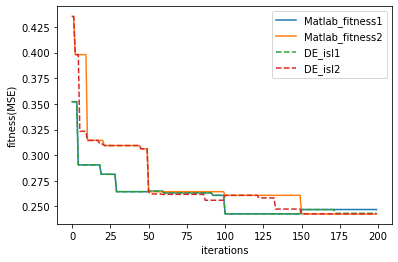

In [85]:
pf1=[]
pf2=[]
pf3=[]


with open ("Data_bfits-mat.txt","r") as f:
    for line in f:
        p=line.split()
#         print(p[1])
        pf1.append(float(p[1][1:]))
        pf2.append(float(p[2][:]))
        pf3.append(float(p[3][:-1]))
plt.plot(sp[:,0],label='Matlab_fitness1')
plt.plot(sp[:,1],label='Matlab_fitness2')
# plt.plot(sp[:,2],label='Matlab_fitness3') 
plt.plot(pf1,label='DE_isl1',ls='--')
plt.plot(pf2,label='DE_isl2',ls='--')
# plt.plot(pf3,label='DE_isl3',ls='--')
plt.xlabel('iterations')
plt.ylabel('fitness(MSE)')
plt.legend()
plt.show()    

In [81]:
fitness

array([[0.33427278, 0.76699549, 0.71148786],
       [0.33427278, 0.76699549, 0.71148786],
       [0.33427278, 0.41712513, 0.71148786],
       [0.33427278, 0.41712513, 0.71148786],
       [0.71289307, 0.41712513, 0.71148786],
       [0.71289307, 0.41712513, 0.71148786],
       [0.71289307, 0.41712513, 0.92564587],
       [0.71289307, 0.41712513, 0.58807414],
       [0.71289307, 0.41712513, 0.58807414],
       [0.71289307, 0.41712513, 0.58807414],
       [0.71289307, 0.33338058, 0.58807414],
       [0.71289307, 0.33338058, 0.58807414],
       [0.71289307, 0.33338058, 0.58807414],
       [0.71289307, 0.33338058, 0.58807414],
       [0.71289307, 0.33338058, 0.58807414],
       [0.71289307, 0.33338058, 0.58807414],
       [0.71289307, 0.33338058, 0.58807414],
       [0.71289307, 0.33338058, 0.58807414],
       [0.71289307, 0.33338058, 0.58807414],
       [0.58455919, 0.33338058, 0.58807414],
       [0.58455919, 0.33338058, 0.58807414],
       [0.58455919, 0.37809042, 0.58807414],
       [0.

In [87]:
#  np.savetxt('fitness_mat',fitness,fmt='%5.5f', delimiter = '\t')

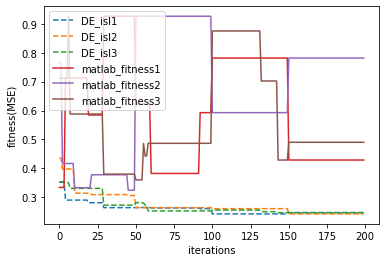

In [80]:
# fit_surrogate = np.loadtxt('Data_bfits.txt',"r",delimiter='\t')
pf1=[]
pf2=[]
pf3=[]


with open ("Data_bfits-mat.txt","r") as f:
    for line in f:
        p=line.split()
#         print(p[1])
        pf1.append(float(p[1][1:]))
        pf2.append(float(p[2][:]))
        pf3.append(float(p[3][:-1]))
plt.plot(sp[:,0],label='DE_isl1',ls='--')
plt.plot(sp[:,1],label='DE_isl2',ls='--')
plt.plot(sp[:,2],label='DE_isl3',ls='--')
plt.plot(fitness[:,0],label='matlab_fitness1')
plt.plot(fitness[:,1],label='matlab_fitness2')
plt.plot(fitness[:,2],label='matlab_fitness3') 
# plt.plot(pf1,label='DE_isl1')
# plt.plot(pf2,label='DE_isl2')
# plt.plot(pf3,label='DE_isl3')
plt.xlabel('iterations')
plt.ylabel('fitness(MSE)')
plt.legend()
plt.show()    

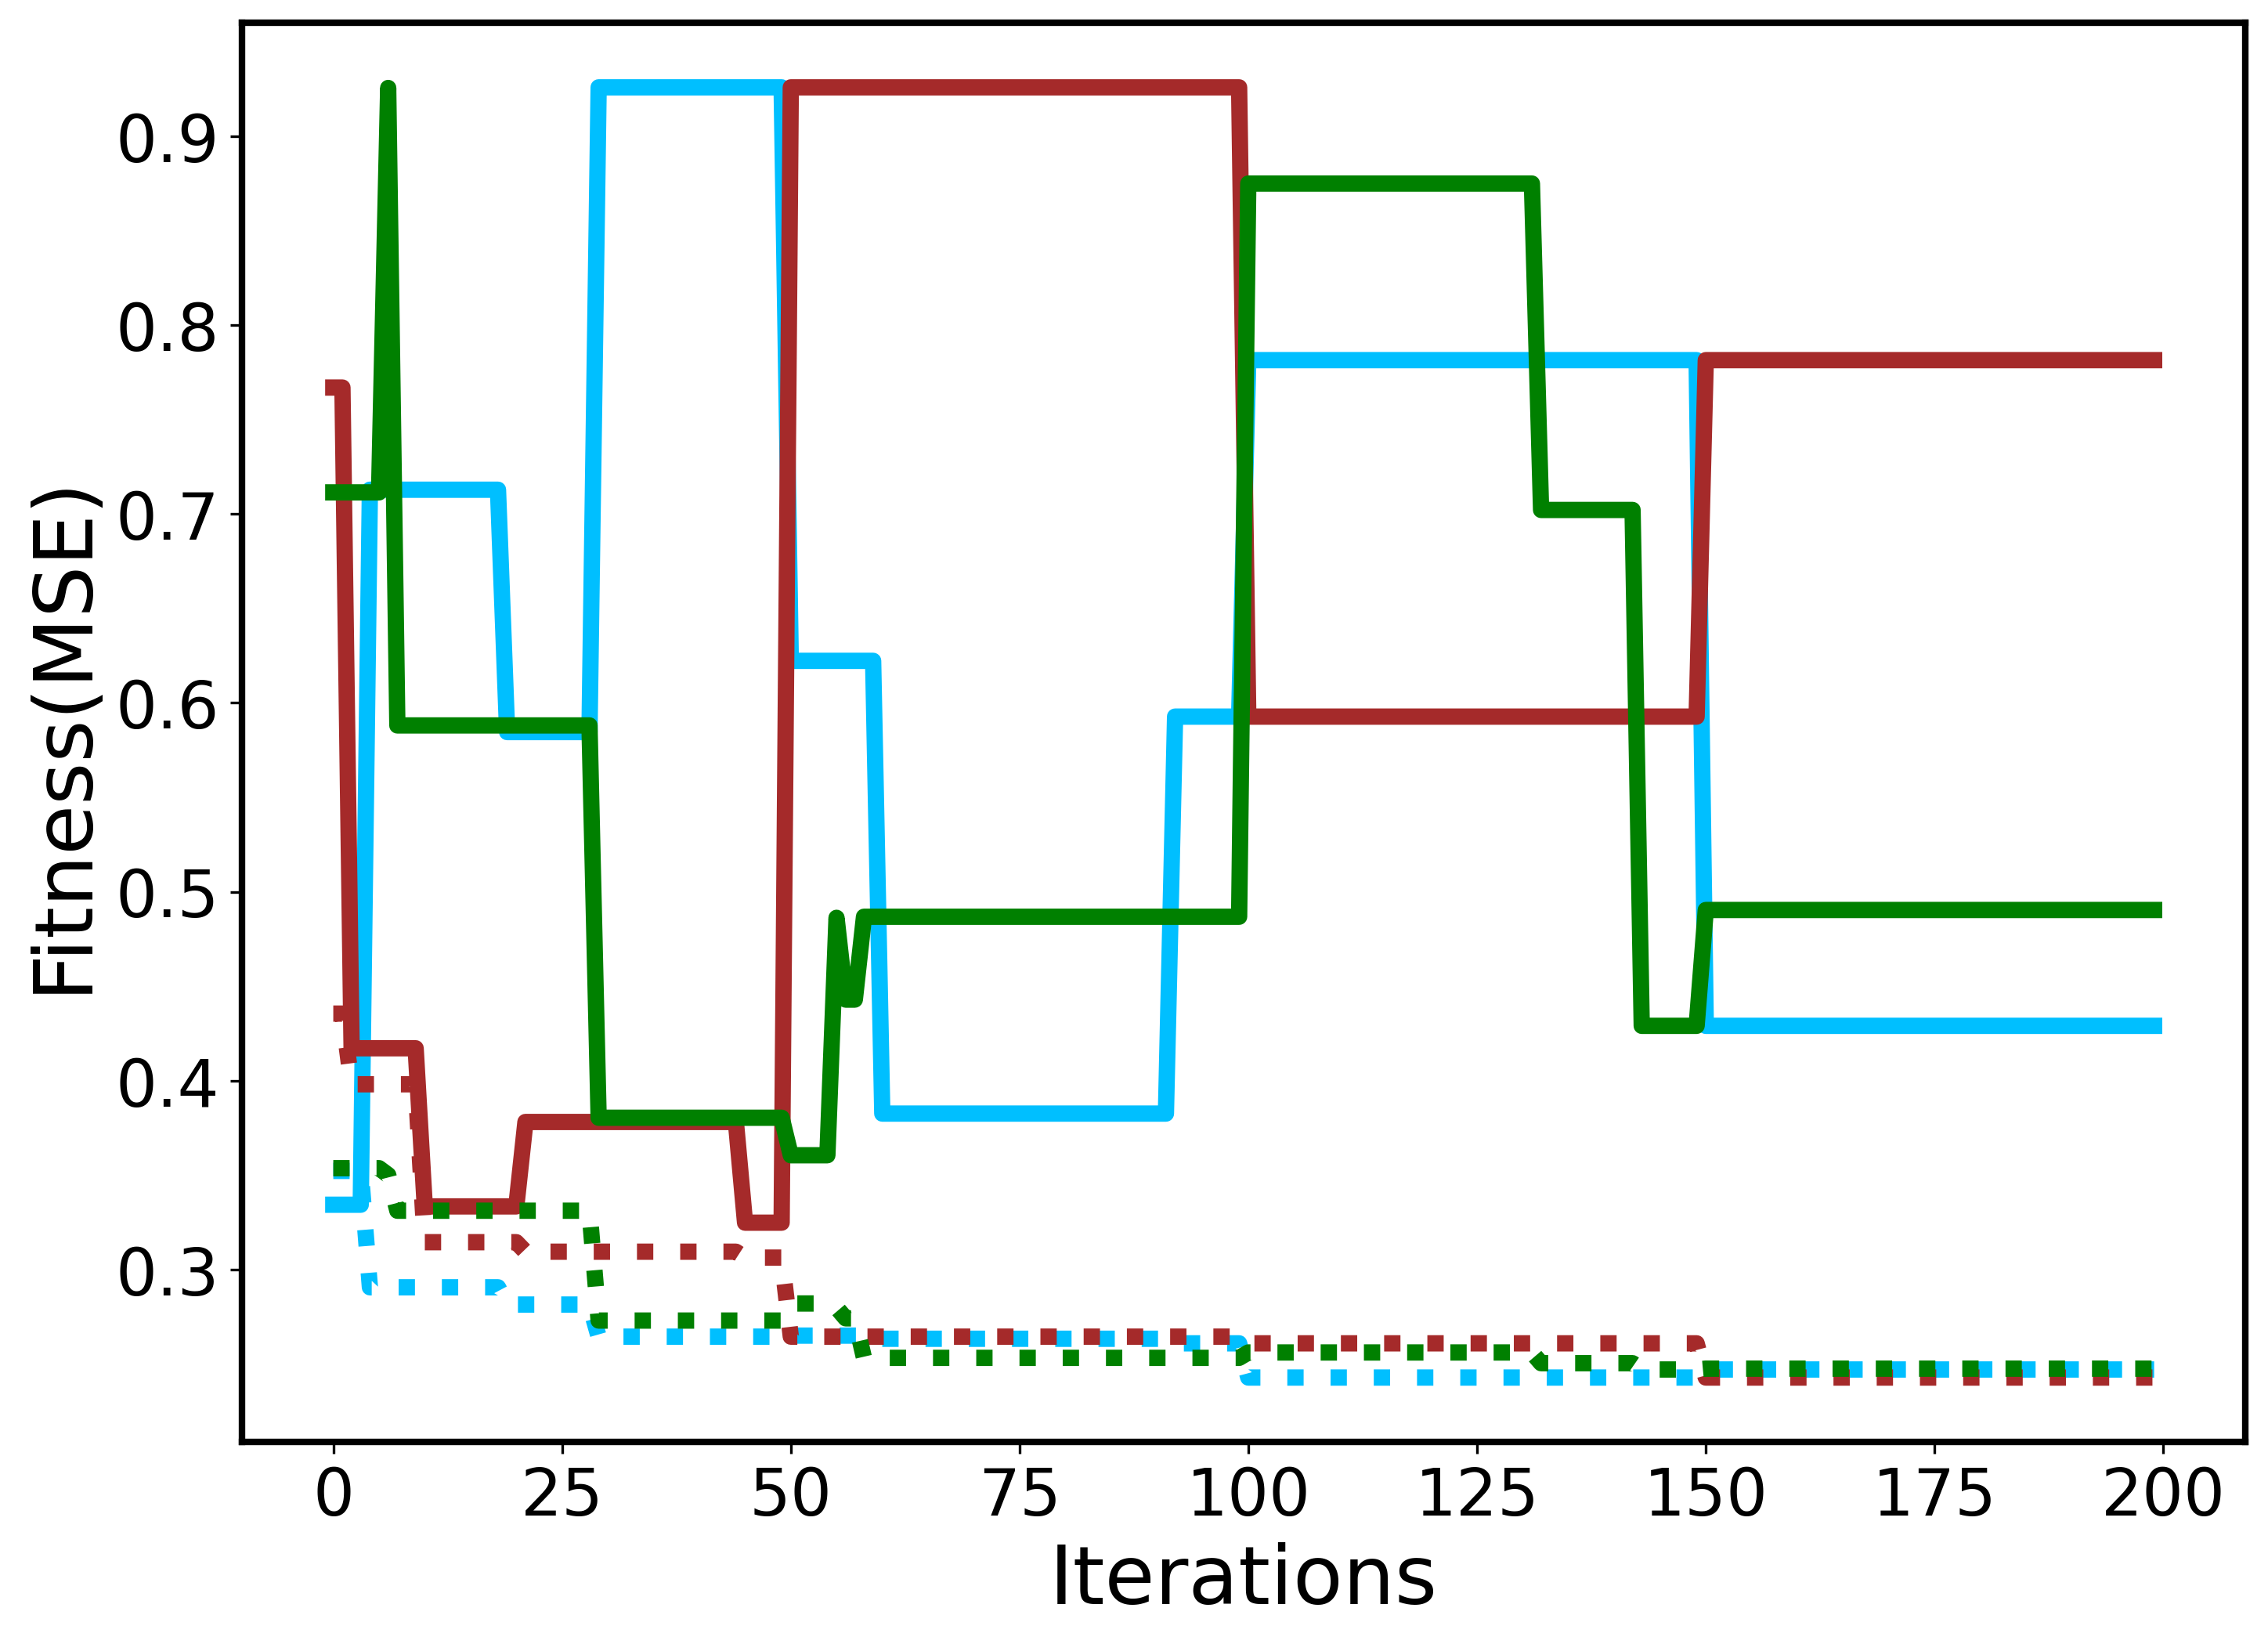

In [86]:
from matplotlib.ticker import MultipleLocator
plt.figure(figsize = (11, 8),dpi=300)

plt.plot(fitness[:,0],label='Actual_fitness_island1',linewidth=5,color = 'deepskyblue')
plt.plot(fitness[:,1],label='Actual_fitness_island2',linewidth=5,color = 'brown')
plt.plot(fitness[:,2],label='Actual_fitness_island3',linewidth=5,color = 'green')
plt.plot(sp[:,0],label='Surrogate_fitness_island1',ls='dotted',linewidth=5,color = 'deepskyblue')
plt.plot(sp[:,1],label='Surrogate_fitness_island2',ls='dotted',linewidth=5,color = 'brown')
plt.plot(sp[:,2],label='Surrogate_fitness_island3',ls='dotted',linewidth=5,color = 'green')
ax = plt.gca()
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
# ax.yaxis.set_major_locator(MultipleLocator(0.2))
plt.xlabel('Iterations',fontsize=25)
plt.ylabel('Fitness(MSE)',fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.legend(fontsize=15)
# plt.savefig('matlab_fitness.png')
plt.show()    

In [19]:
y1 = np.reshape(patt,(15,13,25,128))
y1=np.swapaxes(y1,1,3)
y1=y1[:,48:54,:,:]
y1.shape

(15, 6, 25, 13)

In [15]:
get_mse_Mat(population, target,N_I,N_P)

array([[ 68.48447581,  70.80306962, 101.92886943, 161.1015469 ,
         85.80372724],
       [150.14149167, 107.98314148, 152.63892523,  81.31342998,
         70.45968238],
       [147.55279782,  76.93909279,  68.6009984 ,  61.93604368,
         82.40702643]])

In [12]:
eng = matlab.engine.start_matlab()
eng.gpuDeviceCount("available")

3.0

[ 0.00283537 -0.00093944 -0.01545057 -0.02702646 -0.02702646 -0.01545057
 -0.00093944  0.00283537  0.00283537] [ 0.00411833  0.02887411  0.01951539  0.01051526 -0.01051526 -0.01951539
 -0.02887411 -0.00411833  0.00411833]


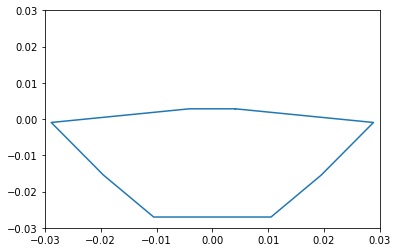

In [30]:
xy=pred.polar_to_cartesian(sol)
X=xy[:,0:8]
X = np.append(X[2,:],X[2,0])
Y = xy[:,8:16]
Y = np.append(Y[2,:],Y[2,0])
print(X,Y)
plt.plot(Y,X)
plt.xlim(-0.03,0.03)
plt.ylim(-0.03,0.03)
plt.show()

In [31]:
np.savetxt('X_matlab.txt',X,fmt='%3.4f', delimiter = '\t')
np.savetxt('Y_matlab.txt',Y,fmt='%3.4f', delimiter = '\t')

In [17]:
eng = matlab.engine.start_matlab()
eng.ant128_trial(nargout=0)
eng.quit()

Starting parallel pool (parpool) using the 'Processes' profile ...
Connected to parallel pool with 8 workers.


In [112]:
patt1 = np.loadtxt('ant128patt_mat.txt',delimiter=',')
patt2 = np.loadtxt('ant128patt_mat1.txt',delimiter=',')
patt3 = np.loadtxt('ant128patt_mat2.txt',delimiter=',')
s11 = np.loadtxt('ant128S11_mat.txt',delimiter=',')
s12 = np.loadtxt('ant128S11_mat1.txt',delimiter=',')
s13 = np.loadtxt('ant128S11_mat2.txt',delimiter=',')
imp = np.loadtxt('ant128imp_mat.txt',delimiter=',')
imp2 = np.loadtxt('ant128imp_mat1.txt',delimiter=',')
imp3 = np.loadtxt('ant128imp_mat2.txt',delimiter=',')
zo = imp[0:128]
z2 =imp2[0:128]
z3 =imp3[0:128]
# Zo = imp2[0:128]
io = imp[128:256]
patt1.shape
# print(np.min(s11), np.max(patt1))

(41600,)

In [113]:
ff=25
pat_tar = np.loadtxt('ant128patt_rect.txt',delimiter=',')
pat=np.reshape(pat_tar,(1,13,25,128))
patternt=np.swapaxes(pat,1,3)
patternt = patternt[0,ff,:,:]

patt=np.reshape(patt1,(1,13,25,128))
pat=np.swapaxes(patt,1,3)
patternM = pat[0,ff,:,:]
patt=(patternt)
patD=(patternD)
patM=(patternM)
patM2 = np.reshape(patt2,(1,13,25,128))
pat2=np.swapaxes(patM2,1,3)
patternM2 = pat2[0,ff,:,:]
patM3 = np.reshape(patt3,(1,13,25,128))
pat3=np.swapaxes(patM3,1,3)
patternM3 = pat3[0,ff,:,:]
# print(np.max(patt),np.max(patD),np.max(patM))
np.shape(patM)

print(np.max(patt),np.max(patD),np.max(patt3),np.max(patternM2),np.max(patternM3))

5.58260740209981 2.8437285 3.78307459388429 2.59645681201568 2.23262092642302


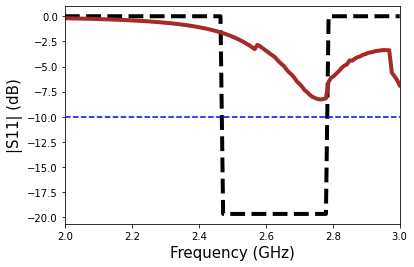

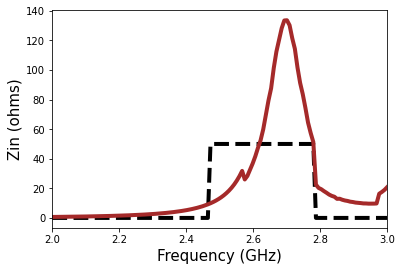

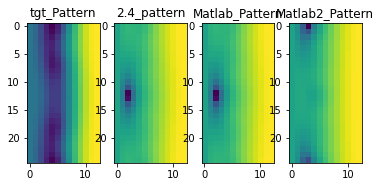

In [114]:
freq = np.linspace(2,3,128)
# plt.figure(figsize = (11, 8),dpi =300)

plt.plot(freq,10*log(target2),label='target_S11',linewidth=4,color = 'black',ls='--')
# plt.plot(freq,10*log(y2[0]),label='S11 NN_predicted',linewidth=4,color = 'royalblue')
# plt.plot(freq,(s11),label='S11 EM_simulated',linewidth=4,color = 'deeppink')
# plt.plot(freq,(s12),label='S11 EM_simulated',linewidth=4,color = 'green')
plt.plot(freq,(s13),label='S11 EM_simulated',linewidth=4,color = 'brown')
plt.axhline(y=-10, color='b', linestyle='--')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Frequency (GHz)',fontsize=15)
plt.ylabel('|S11| (dB)',fontsize=15)
plt.xlim(2,3)
# plt.title('S11 of optimal design @2.4GHz',fontsize=30)
# plt.legend(fontsize=15)
plt.show()



# plt.figure(figsize = (11, 8),dpi=300)
plt.plot(freq,target3,label='target Zin',linewidth=4,color = 'black',ls='--')
# plt.plot(freq,y3[0],label='NN_predicted Zin',linewidth=4,color = 'royalblue')
# plt.plot(freq,zo,label='EM_simulated Zin',linewidth=4,color = 'deeppink')
# plt.plot(freq,z2,label='EM_simulated Zin',linewidth=4,color = 'green')
plt.plot(freq,z3,label='EM_simulated Zin',linewidth=4,color = 'brown')
# plt.plot(freq,Zo,label='Z0_matlab')
# plt.plot(freq,io,label='EM_simulated I',linewidth=3,color = 'maroon')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Frequency (GHz)',fontsize=15)
plt.ylabel('Zin (ohms)',fontsize=15)
plt.xlim(2,3)
# plt.title('Impedance of optimal design @2.4GHz',fontsize=30)
# plt.legend(fontsize=15)
plt.show()

fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4)
ax1.imshow(patt)
ax1.set_title('tgt_Pattern')
ax2.imshow(patternM3)
ax2.set_title('2.4_pattern')
ax3.imshow(patternM)
ax3.set_title('Matlab_Pattern')
ax4.imshow(patternM2)
ax4.set_title('Matlab2_Pattern')
fig.show()

In [42]:
aa = patternt[13]
bb = np.flip(aa)
cc = np.append(aa,bb)
xx = patternM3[13]
yy = np.flip(xx)
zz = np.append(xx,yy)
pp = patternM[13]
rr = np.flip(pp)
ss = np.append(pp,rr)
tt = patternM2[13]
uu = np.flip(tt)
vv = np.append(tt,uu)
np.shape(ss)

(26,)

In [53]:
# patt_tgt = np.loadtxt('ant128patt_tgt.txt',delimiter=',')
# pat=np.reshape(patt_tgt,(1,13,25,128))
# pat=np.swapaxes(pat,1,3)
# pattern2 = pat[0,52,:,:]
# pattern2.shape

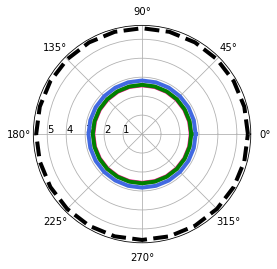

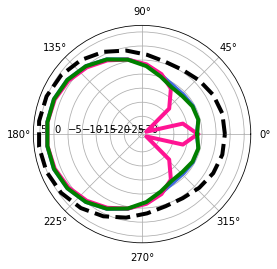

In [43]:
phi = np.linspace(0, 2*np.pi, 25)
# plt.figure(figsize = (11, 8),dpi =300)
plt.polar(phi, patternt[:,12],label='target(az)',linewidth=4,color = 'black',ls='--' )
plt.polar(phi, patternM3[:,12],label='DNN',linewidth=4,color = 'royalblue' )
plt.polar(phi, patternM[:,12],label='Matlab1',linewidth=4,color = 'deeppink' )
plt.polar(phi, patternM2[:,12],label='Matlab2',linewidth=4,color = 'green' )
ax = plt.gca()
# ax.set_rticks([-10,0,3,5,10])
ax.set_rlabel_position(180)
# plt.legend()
plt.show()
phi = np.linspace(0, 2*np.pi, 26)
# # plt.figure(figsize = (11, 8),dpi =300)
plt.polar(phi, cc,label='target(el)',linewidth=4,color = 'black',ls='--' )
plt.polar(phi, zz,label='DNN',linewidth=3,color = 'royalblue' )
plt.polar(phi, ss,label='Matlab1',linewidth=4,color = 'deeppink' )
plt.polar(phi, vv,label='Matlab2',linewidth=4,color = 'green' )
# # 
ax = plt.gca()
# ax.set_rticks([-20,0,5,8])
ax.set_rlabel_position(180)
# plt.legend()
plt.show()

In [46]:
# rr = np.random.randint(0,25)
# ff = np.random.randint(0,13)
# print(rr,ff)
# plt.plot(freq,patt[0,:,0,12],linewidth=2)
# # plt.ylim(0,1)
# plt.legend()
# plt.show()

In [45]:
# rr = np.random.randint(0,13)
# print(rr)
# phi = np.linspace(0, 2*np.pi, 25)
# plt.polar(phi, pattern1[:,rr])
# ax = plt.gca()
# ax.set_rticks([-10,-5, 0, 5, 10])
# ax.set_rlabel_position(75)
# plt.show()

# phi = np.linspace(0, 2*np.pi, 25)
# plt.polar(phi, pat_mat[:,rr])
# ax = plt.gca()
# ax.set_rticks([-10,-5, 0, 5, 10])
# ax.set_rlabel_position(75)
# plt.show()

In [2]:
patt2 = np.loadtxt('ant128patt_2trial.txt',delimiter=',')
patt = np.reshape(patt2,(1,13,25,128))
patt=np.swapaxes(patt,1,3)
print(np.max(patt2))

3.32733887375688


In [3]:
patt3 = np.loadtxt('ant128patt_trial.txt',delimiter=',')
patt3 = np.reshape(patt3,(1,13,25,128))
patt4=np.swapaxes(patt3,1,3)
print(np.max(patt4),np.shape(patt4))


1.27915575072376 (1, 128, 25, 13)


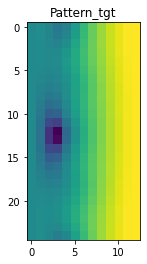

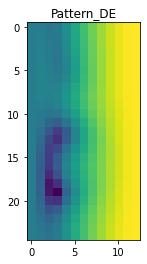

In [4]:
pat_mat = patt[0,52,:,:]
plt.figure
plt.imshow(pat_mat)
plt.title('Pattern_tgt')
plt.show()
pat_3 = patt4[0,52,:,:]
plt.figure
plt.imshow(pat_3)
plt.title('Pattern_DE')
plt.show()

In [5]:
np.shape(pat_mat[13,:])

aa = pat_mat[13]
xx = pat_3[13]
yy = np.flip(xx)
zz = np.append(xx,yy)
bb = np.flip(aa)
cc = np.append(aa,bb)
print(aa, '\n', bb, '\n', cc,'\n', xx, '\n', yy, '\n', zz )


[-11.74365432 -14.38173218 -20.9656087  -24.38539135 -15.24464669
 -10.61961579  -7.4011765   -4.71295081  -2.31392122  -0.21476069
   1.47665329   2.63715908   3.17211806] 
 [  3.17211806   2.63715908   1.47665329  -0.21476069  -2.31392122
  -4.71295081  -7.4011765  -10.61961579 -15.24464669 -24.38539135
 -20.9656087  -14.38173218 -11.74365432] 
 [-11.74365432 -14.38173218 -20.9656087  -24.38539135 -15.24464669
 -10.61961579  -7.4011765   -4.71295081  -2.31392122  -0.21476069
   1.47665329   2.63715908   3.17211806   3.17211806   2.63715908
   1.47665329  -0.21476069  -2.31392122  -4.71295081  -7.4011765
 -10.61961579 -15.24464669 -24.38539135 -20.9656087  -14.38173218
 -11.74365432] 
 [-14.94506314 -16.79587511 -20.61259821 -22.69343008 -18.15906862
 -13.82305305 -10.28585842  -7.20160618  -4.50770391  -2.25464627
  -0.51659127   0.63670964   1.15563926] 
 [  1.15563926   0.63670964  -0.51659127  -2.25464627  -4.50770391
  -7.20160618 -10.28585842 -13.82305305 -18.15906862 -22.693430

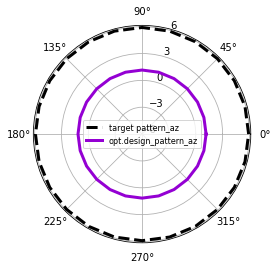

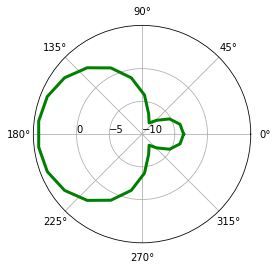

In [12]:
phi = np.linspace(0, 2*np.pi, 25)
plt.polar(phi, pat_mat[:,12],label='target pattern_az',linewidth=3,color = 'black',ls='--' )
plt.polar(phi, pat_3[:,12],label='opt.design_pattern_az',linewidth=3,color = 'darkviolet')
ax = plt.gca()
ax.set_rticks([-6,-3, 0, 3, 6])
ax.set_rlabel_position(75)
plt.legend(fontsize=8)
plt.show()
# pat2=np.transpose(pat_mat)
phi = np.linspace(0, 2*np.pi,26)
plt.polar(phi, cc,linewidth=3,label='target pattern_el',color = 'green',)
# plt.polar(phi,  zz,label='opt. design_pattern_el',linewidth=4,color = 'darkviolet')
ax = plt.gca()
ax.set_rticks([-10, -5, 0])
ax.set_rlabel_position(180)
# plt.legend(fontsize=8)
plt.show()

In [24]:
aaa = np.tile(aa, (25,1))
np.shape(aaa)

(25, 13)

In [72]:
pop = np.array(population)
population = pop[0,:,:]
np.shape(population)

(85, 17)

In [76]:
tar=target
n_i=1
n_p =85

In [ ]:
import datetime
t1 = datetime.datetime.now()
print(t1)
de_nn.de_isl(pred.get_mse3,target,L,U,num_layers_i = 17, num_isles = N_I, num_gens = 8,
	  poplist = population, mut = 0.8, crossp = 0.5, popsize = N_P,
	  its = 200 , lenp = 0.08, lins = 0.06, verbose = 0);
t2 = datetime.datetime.now() - t1
print('time_taken=',t2)

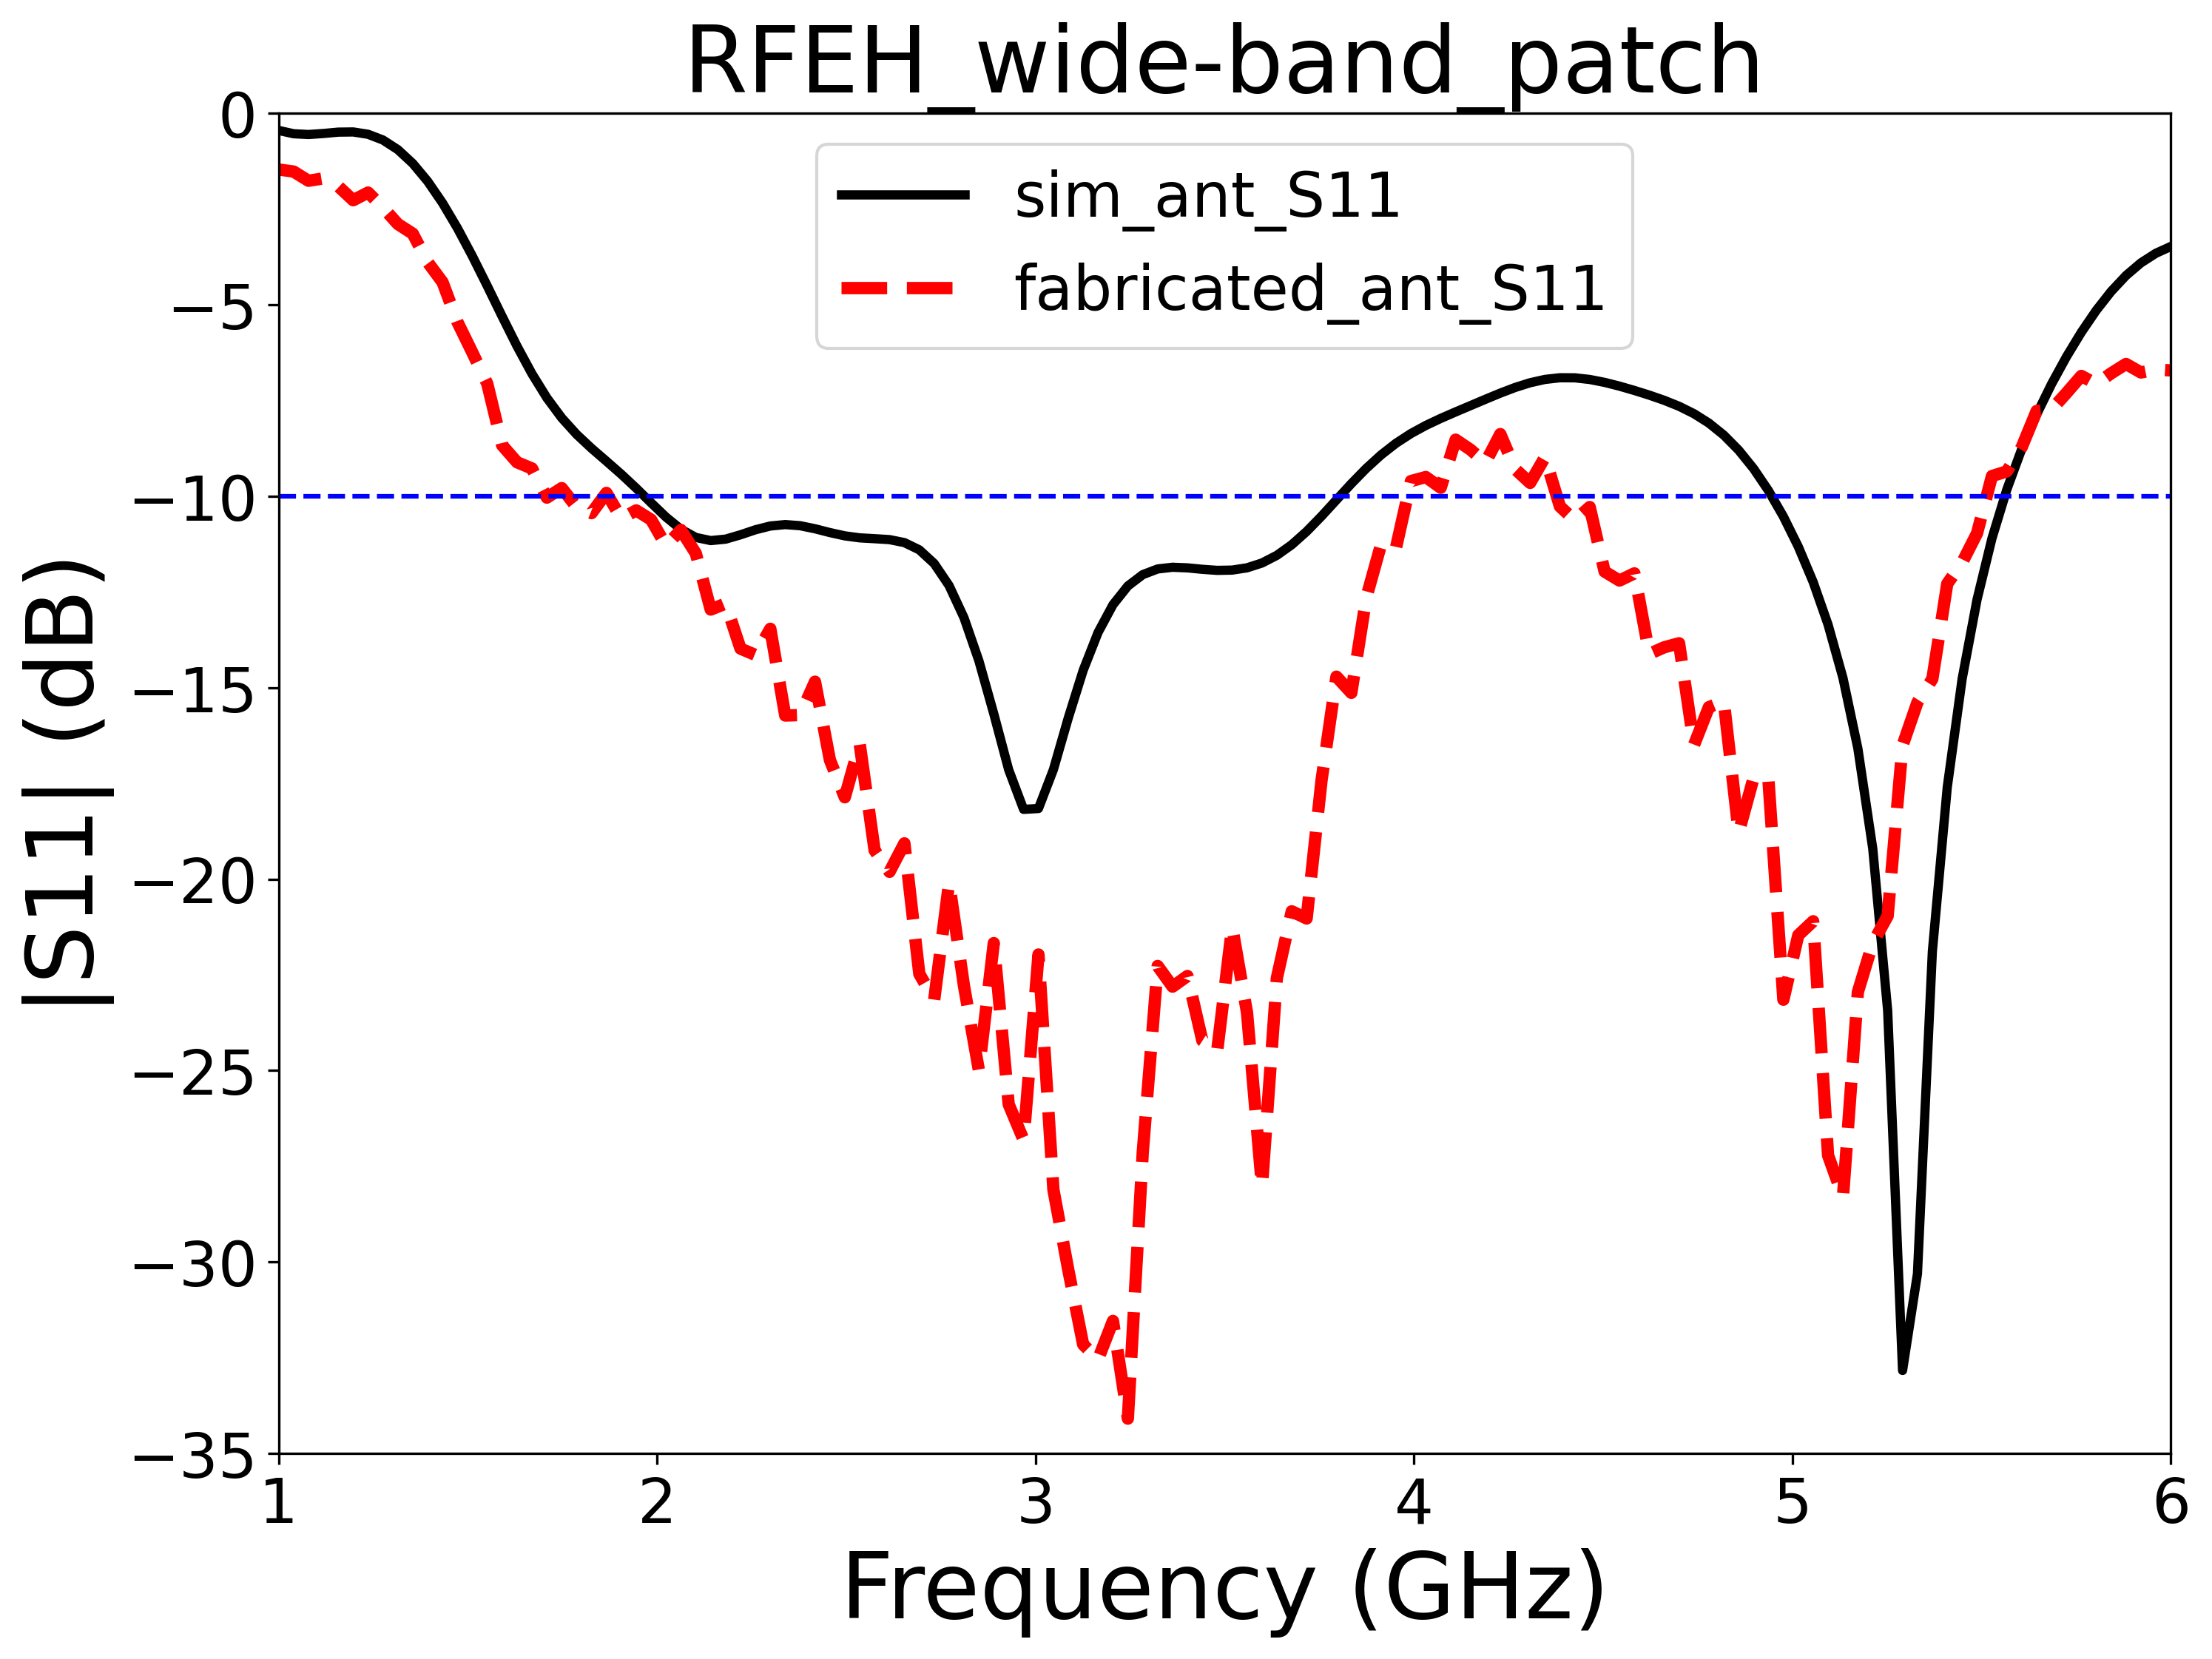

In [17]:
fab_s11=fab5[:,0:2]
# 
freq = np.linspace(1,6,128)
plt.figure(figsize = (11, 8),dpi=300)
plt.plot(freq,sim5,label='sim_ant_S11',linewidth=3,color = 'black')
plt.plot(freq,fab_s11[:,1],label='fabricated_ant_S11',linewidth=4,color = 'red',ls = '--')
plt.axhline(y=-10, color='b', linestyle='--')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(1,6)
plt.ylim(-35,0)
plt.xlabel('Frequency (GHz)',fontsize=30)
plt.ylabel('|S11| (dB)',fontsize=30)
plt.title('RFEH_wide-band_patch',fontsize=30)
plt.legend(fontsize=20)
plt.show()

In [18]:
fab6 = np.loadtxt('rect_S11.csv',delimiter=',')
np.shape(fab5)
sim6 = np.loadtxt('Rect_CST_S11.txt')
sim6 = sim6[:,1]
np.shape(sim6)

(128,)

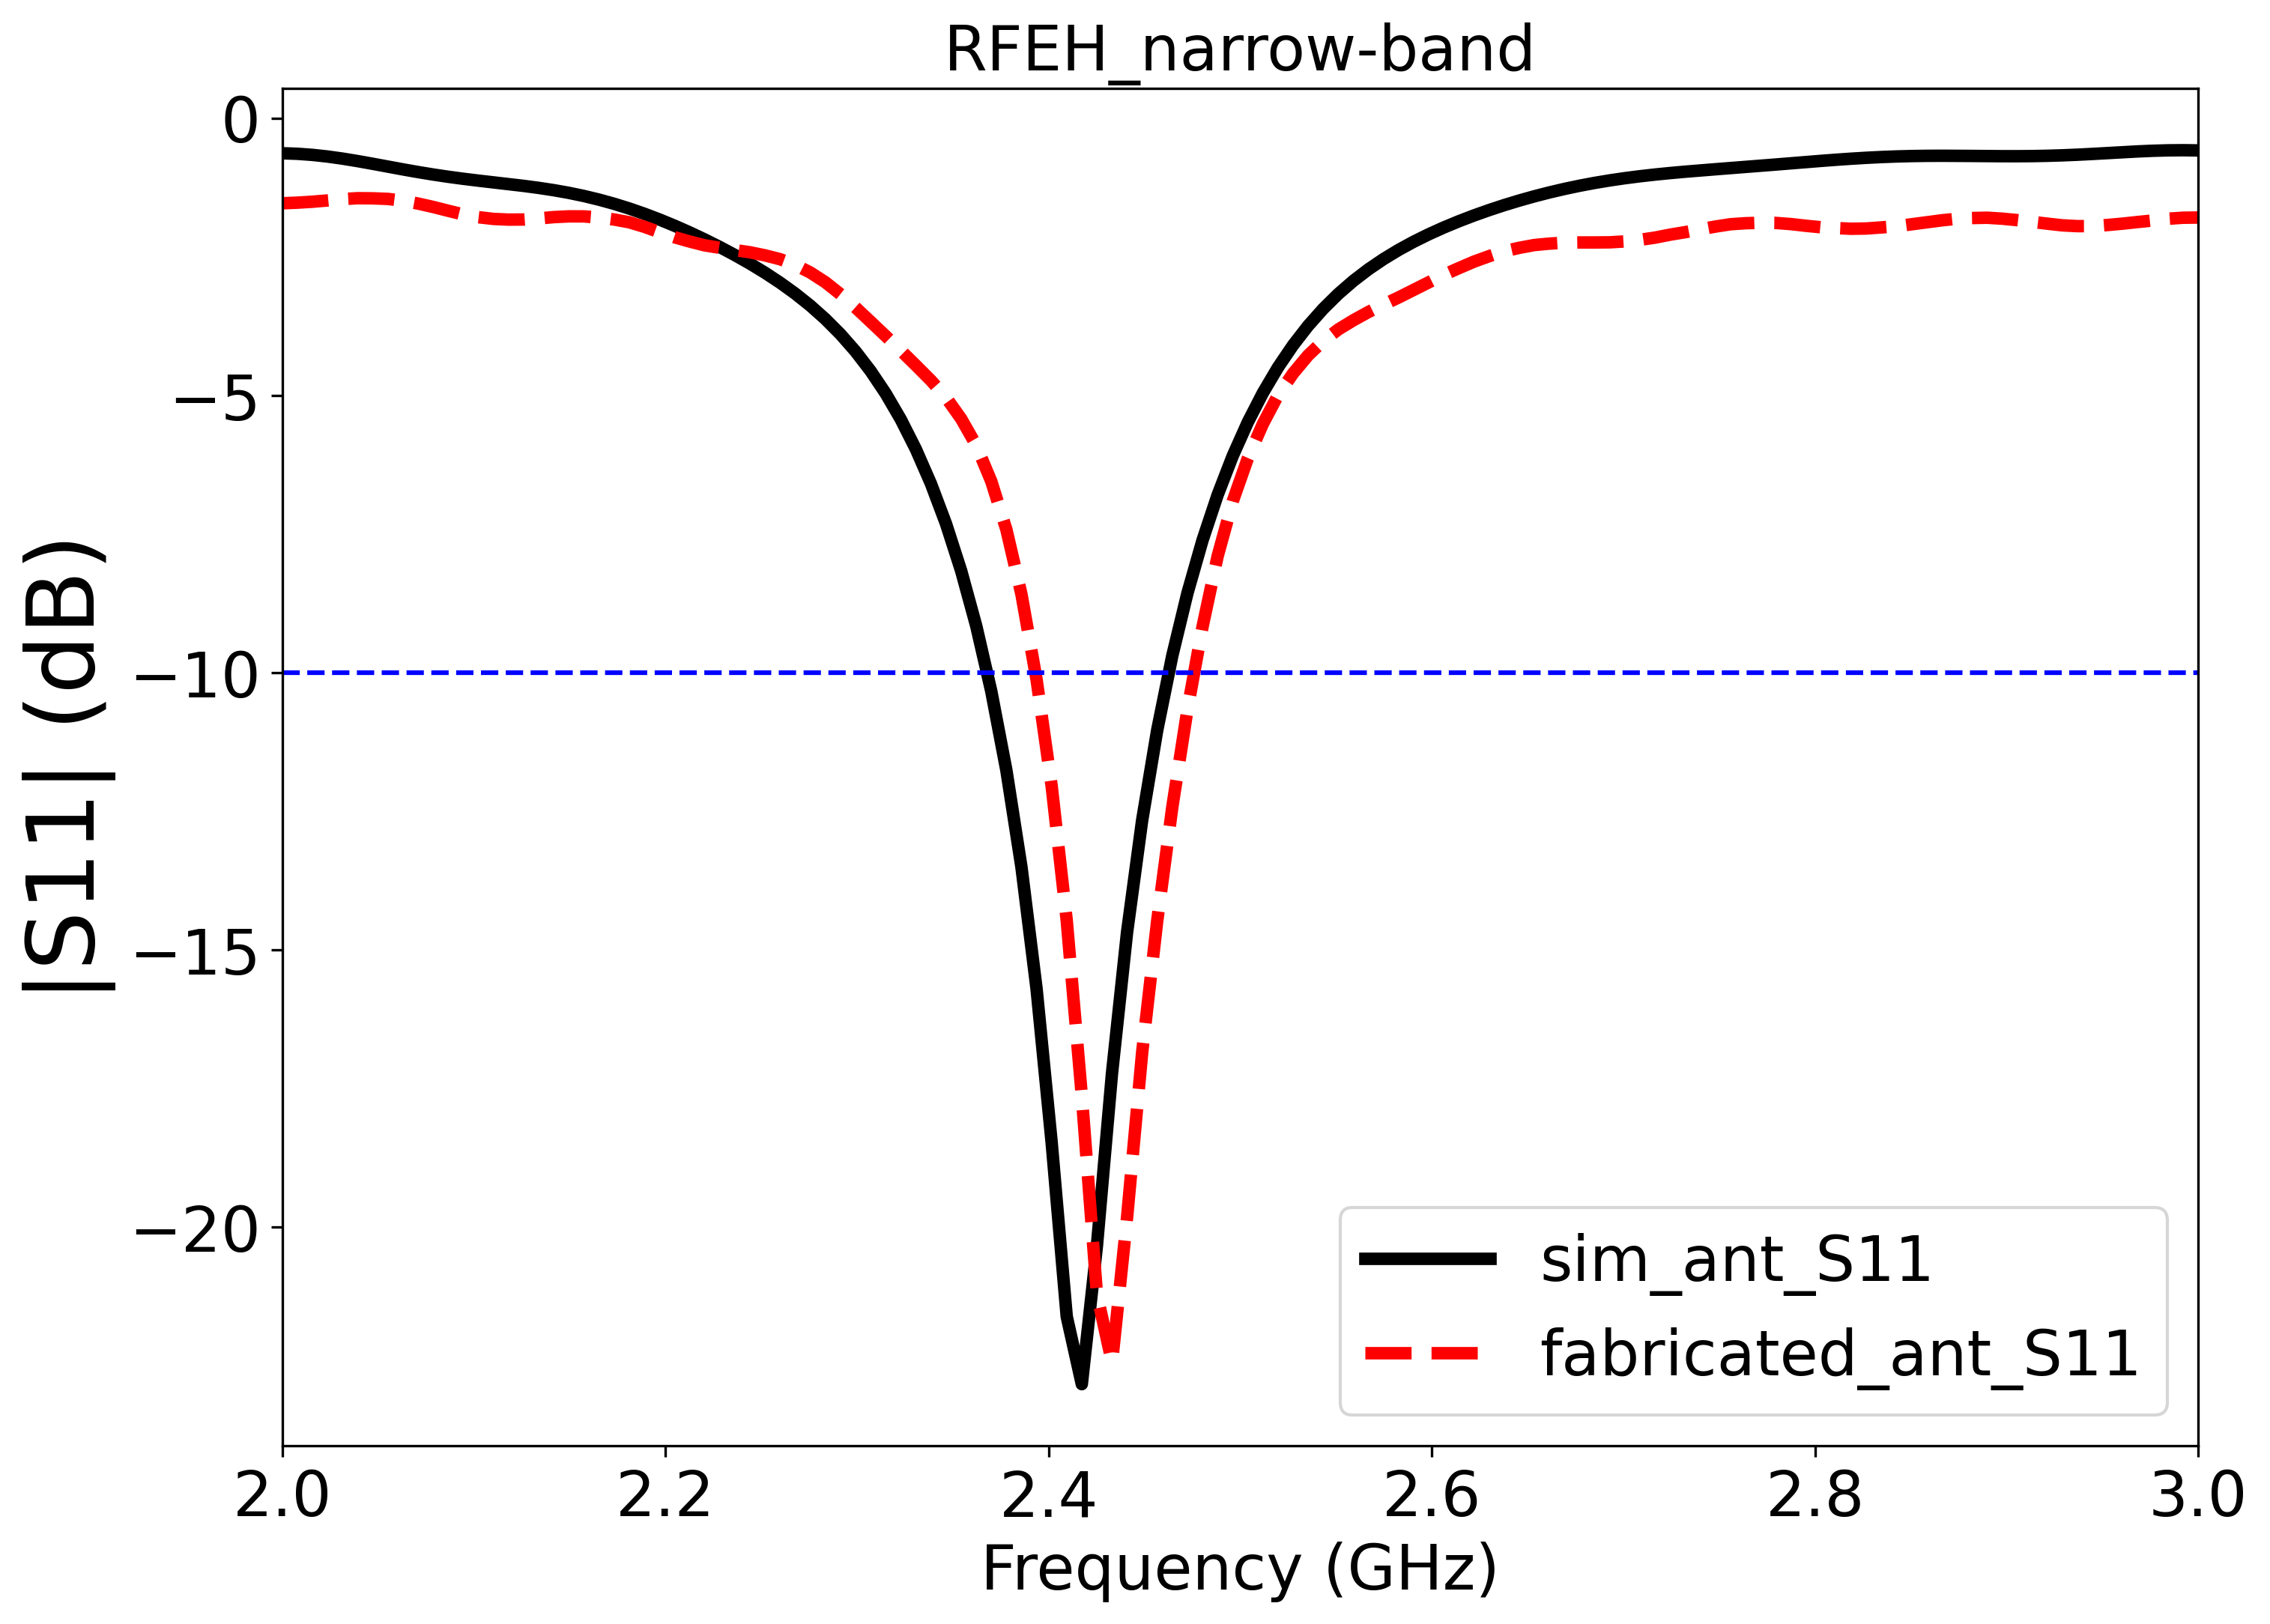

In [19]:
fab_s11=fab6[:,0:2]

freq = np.linspace(2,3,128)
plt.figure(figsize = (11, 8),dpi=300)
plt.plot(freq,sim6,label='sim_ant_S11',linewidth=4,color = 'black')
plt.plot(freq,fab_s11[:,1],label='fabricated_ant_S11',linewidth=4,color = 'red',ls = '--')
plt.axhline(y=-10, color='b', linestyle='--')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(2,3)
# plt.ylim(-21,0)
plt.xlabel('Frequency (GHz)',fontsize=20)
plt.ylabel('|S11| (dB)',fontsize=30)
plt.title('RFEH_narrow-band',fontsize=20)
plt.legend(fontsize=20)
plt.show()

In [11]:
best=np.loadtxt('Data_best.txt')
best.shape

(600, 9)

0


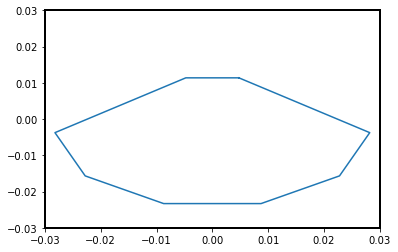

1


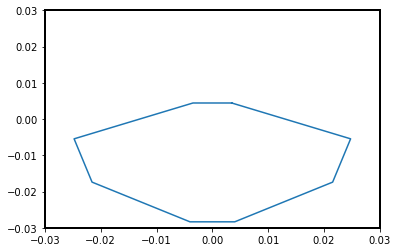

2


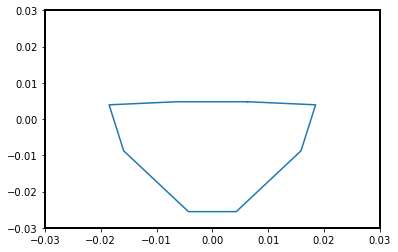

3


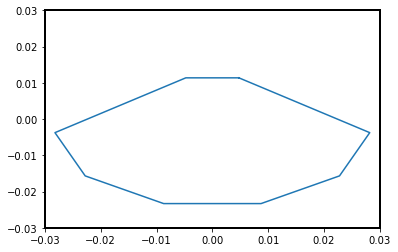

4


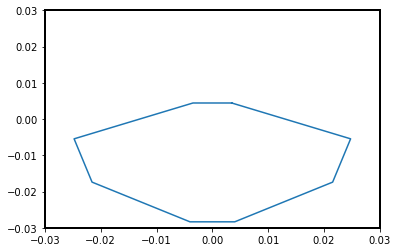

5


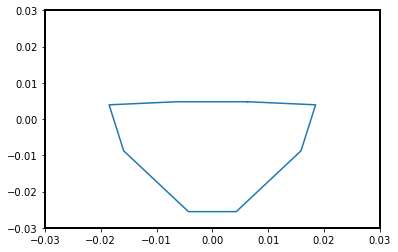

6


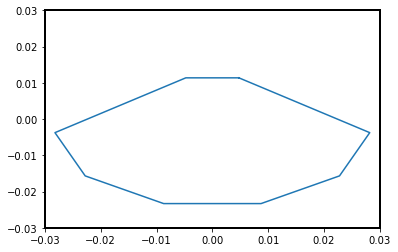

7


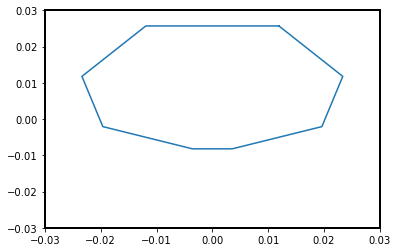

8


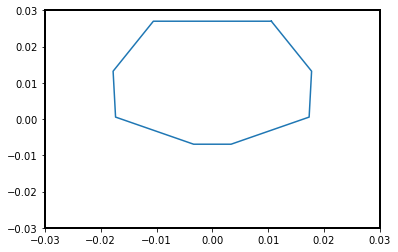

9


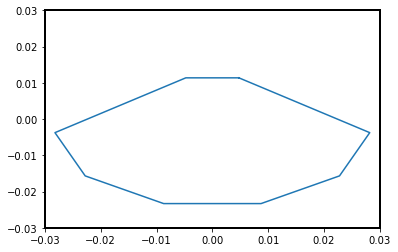

10


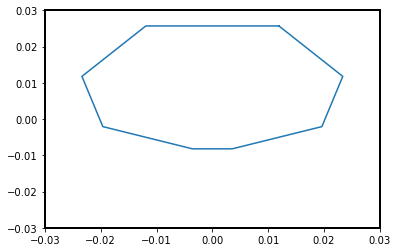

11


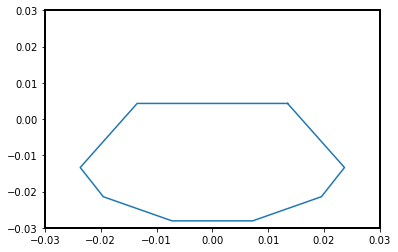

12


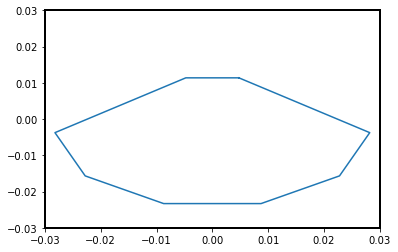

13


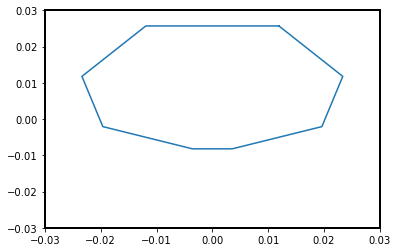

14


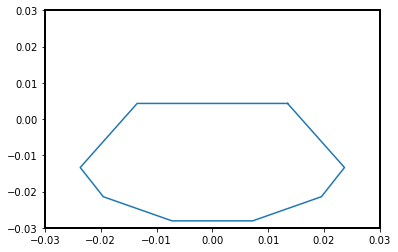

15


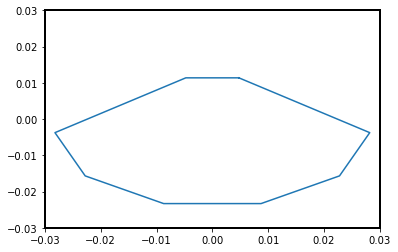

16


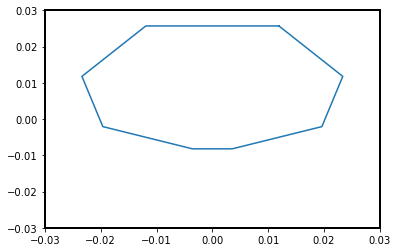

17


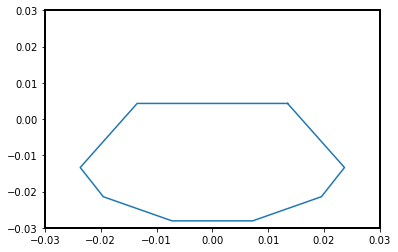

18


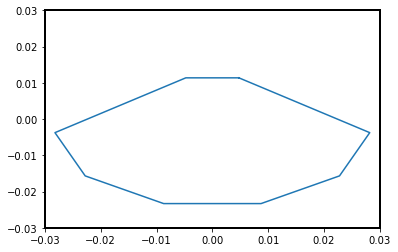

19


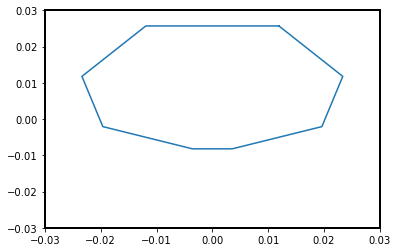

20


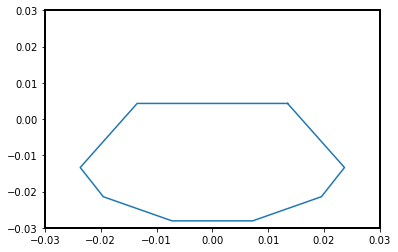

21


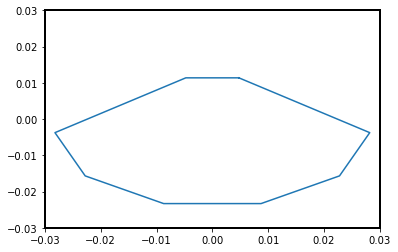

22


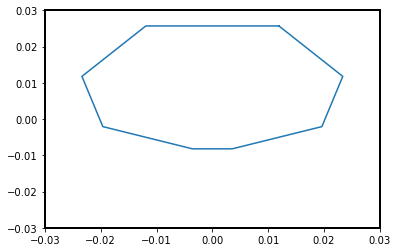

23


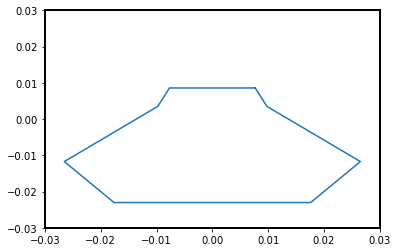

24


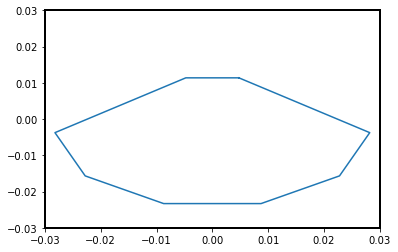

25


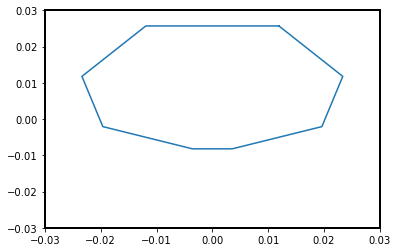

26


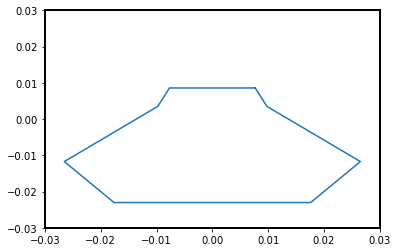

27


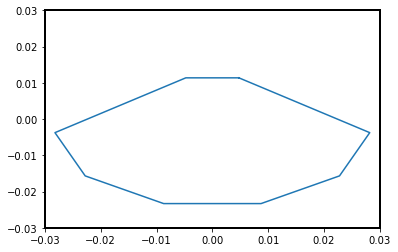

28


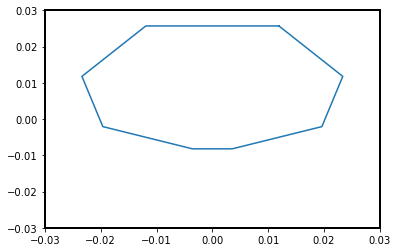

29


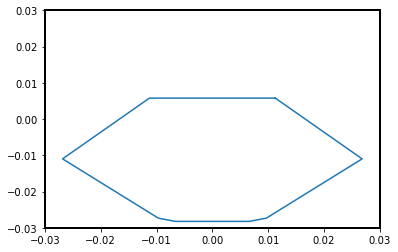

30


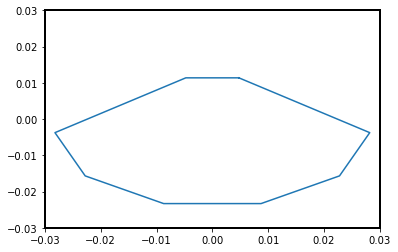

31


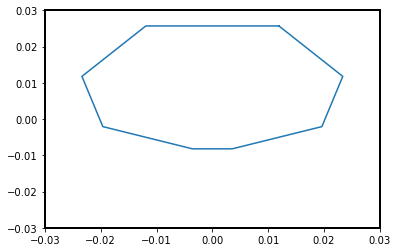

32


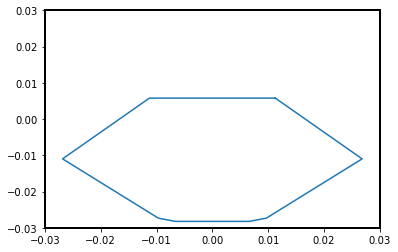

33


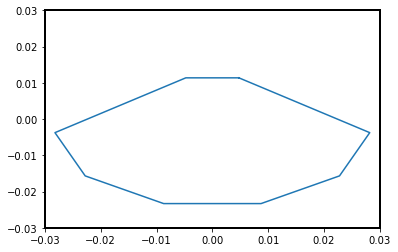

34


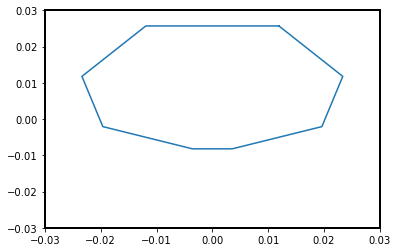

35


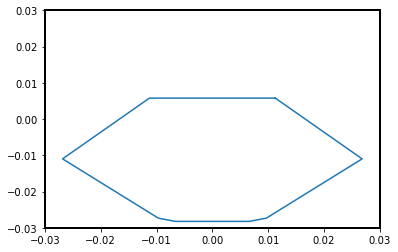

36


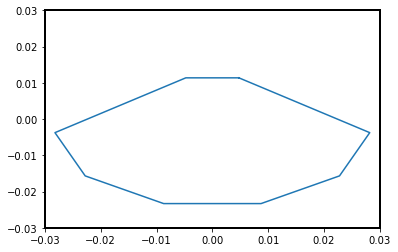

37


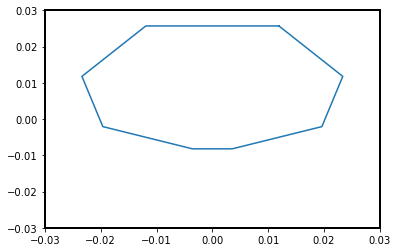

38


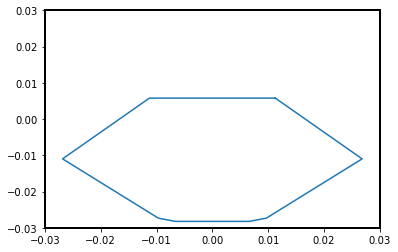

39


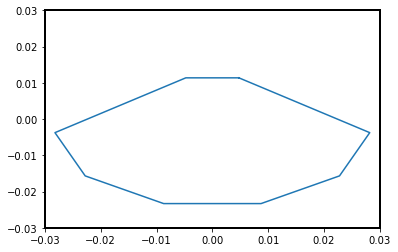

40


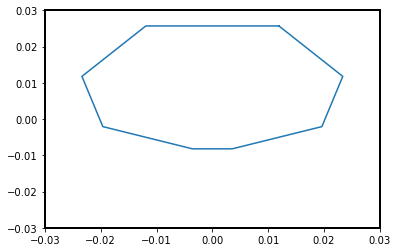

41


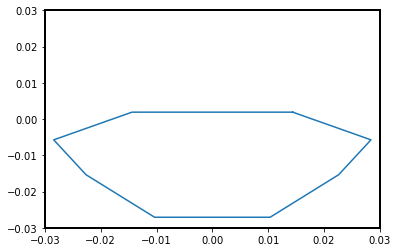

42


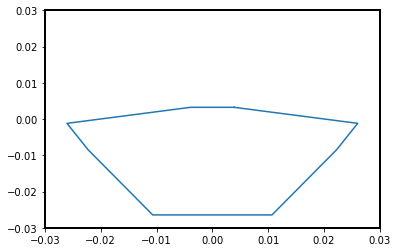

43


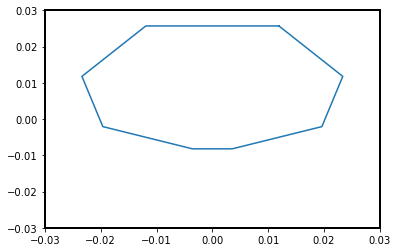

44


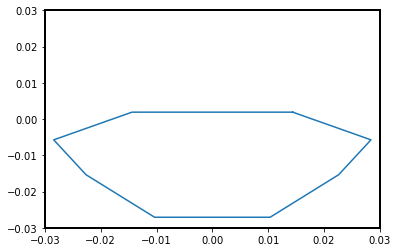

45


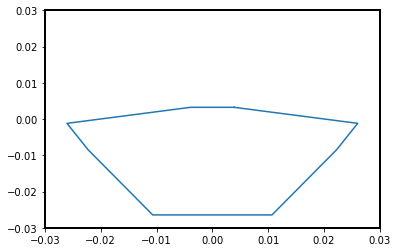

46


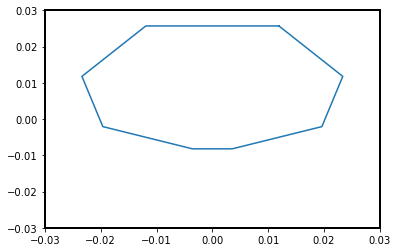

47


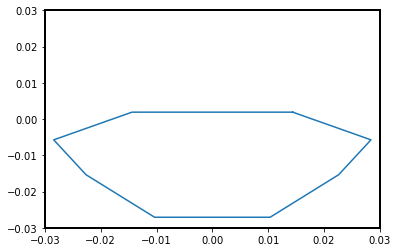

48


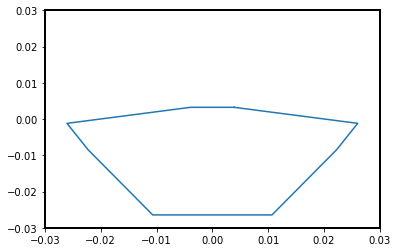

49


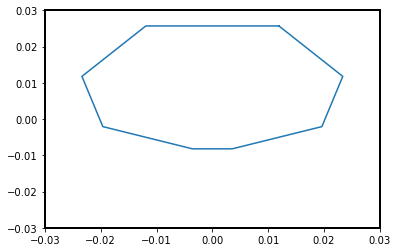

50


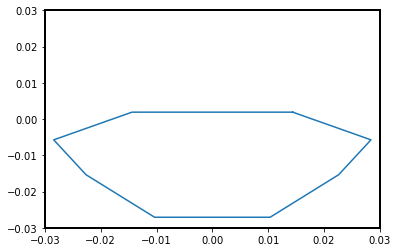

51


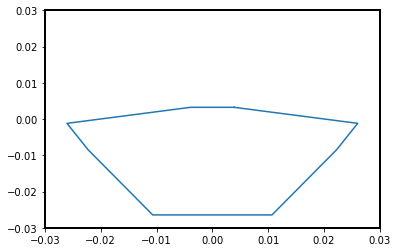

52


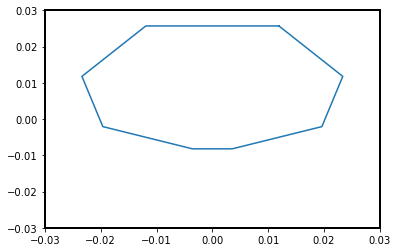

53


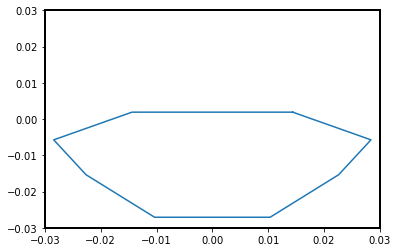

54


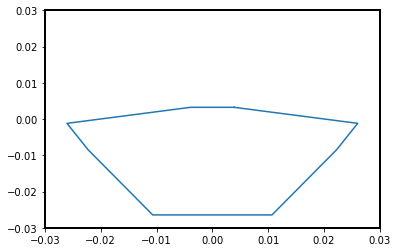

55


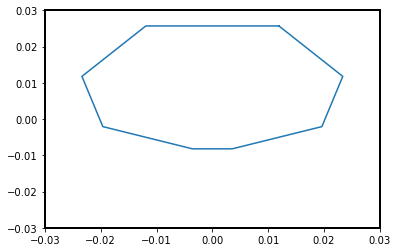

56


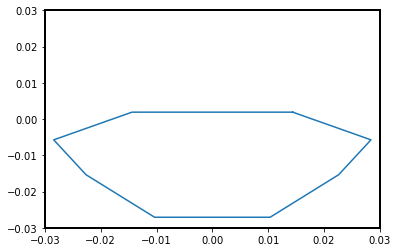

57


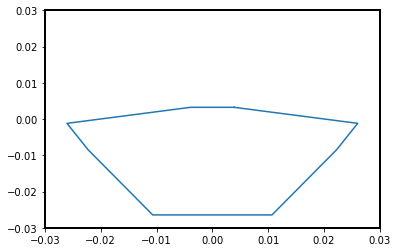

58


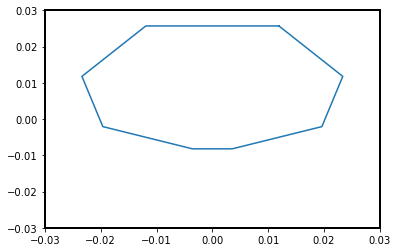

59


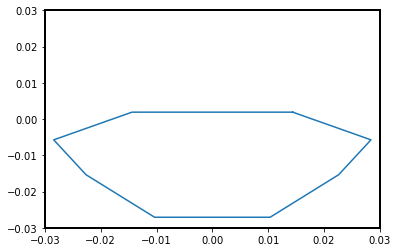

60


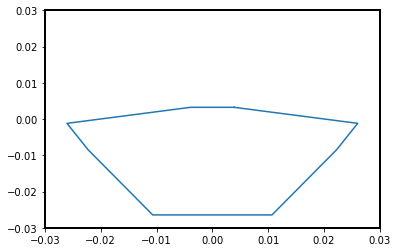

61


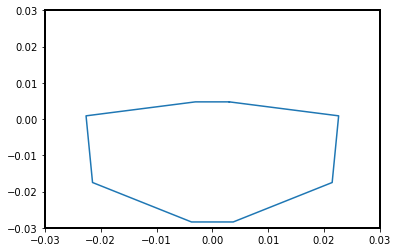

62


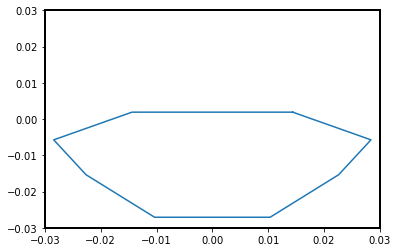

63


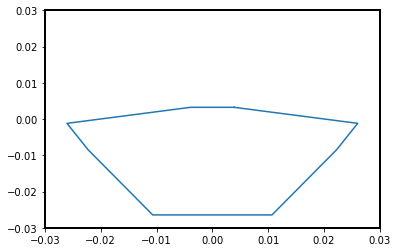

64


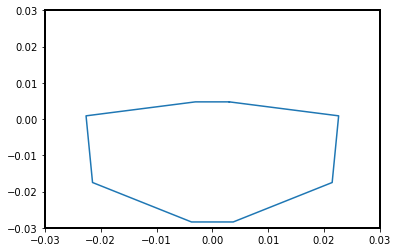

65


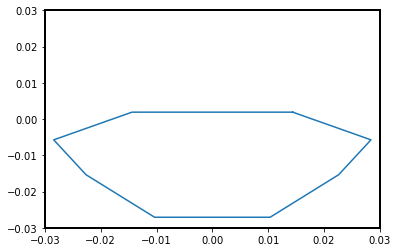

66


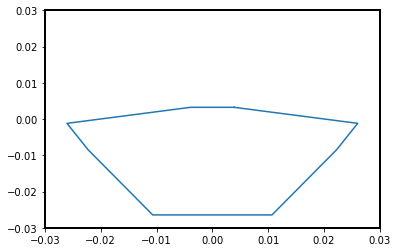

67


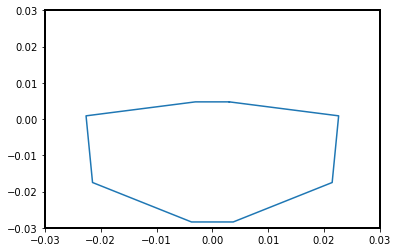

68


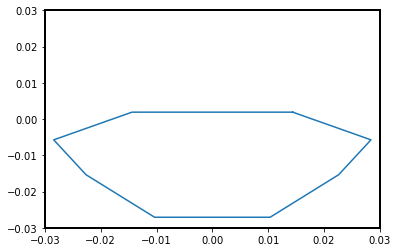

69


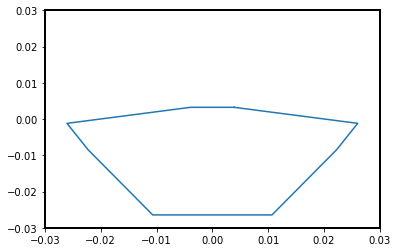

70


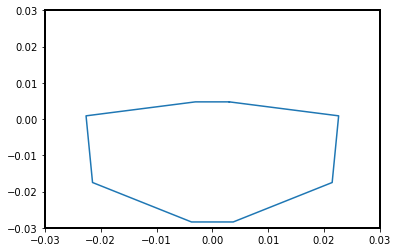

71


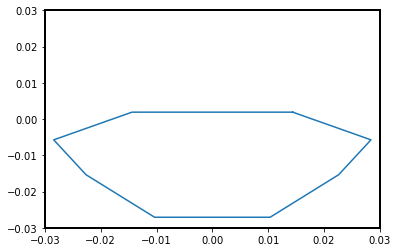

72


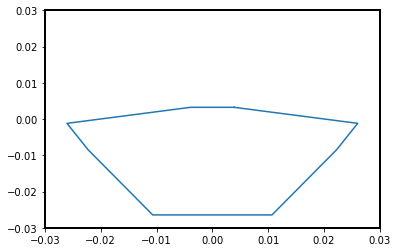

73


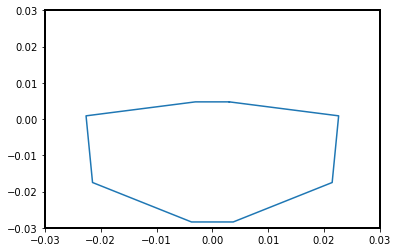

74


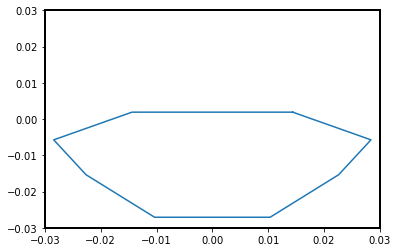

75


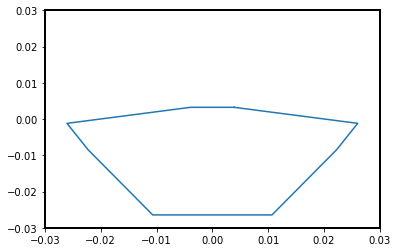

76


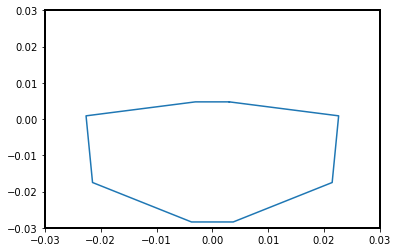

77


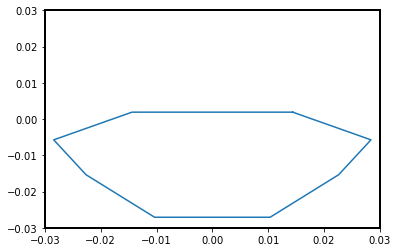

78


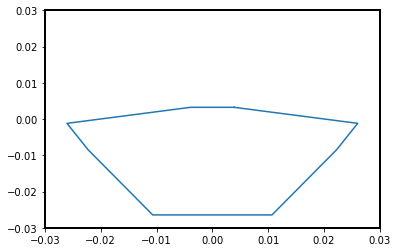

79


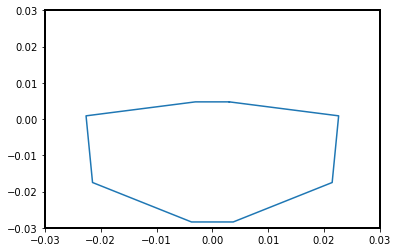

80


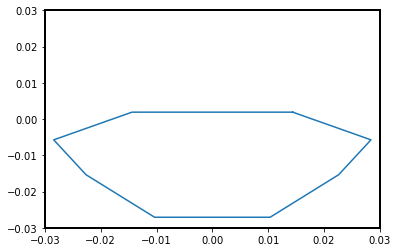

81


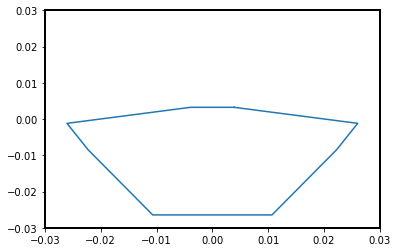

82


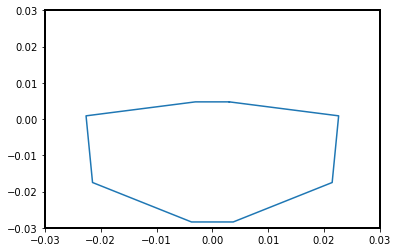

83


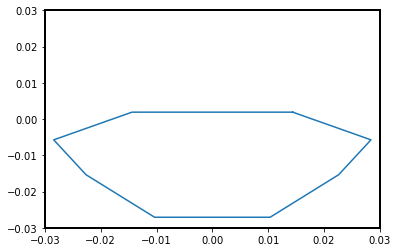

84


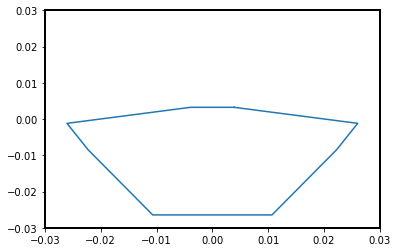

85


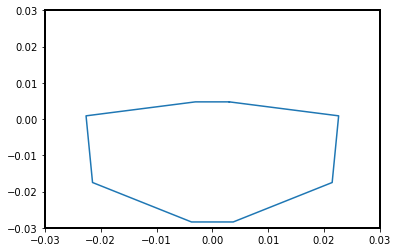

86


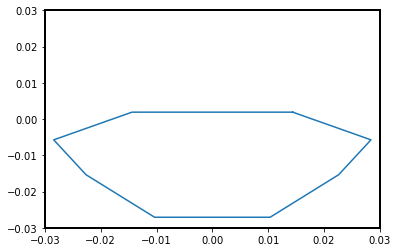

87


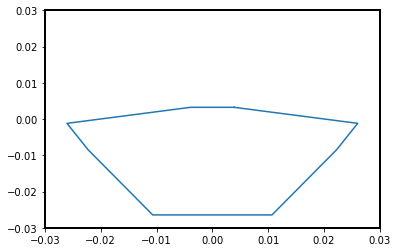

88


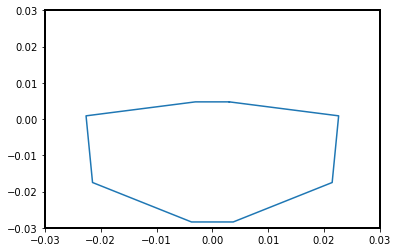

89


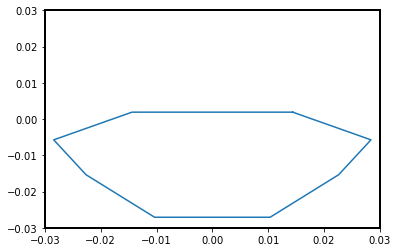

90


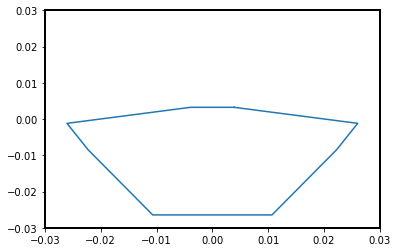

91


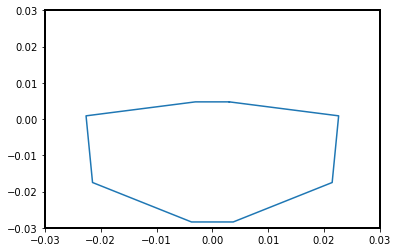

92


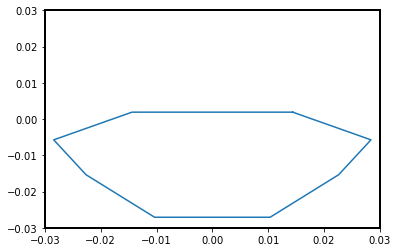

93


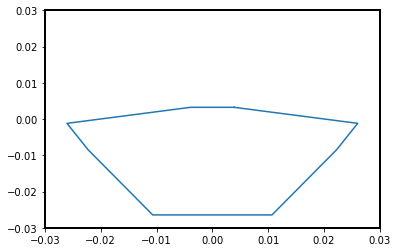

94


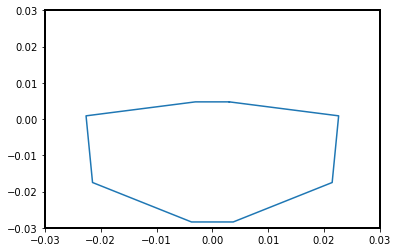

95


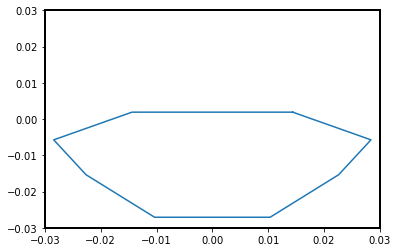

96


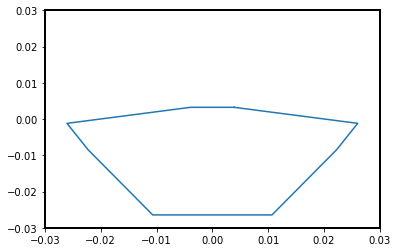

97


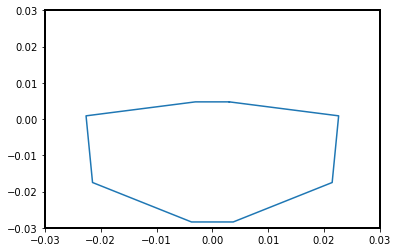

98


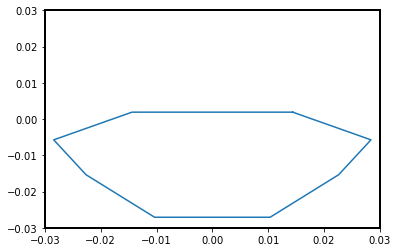

99


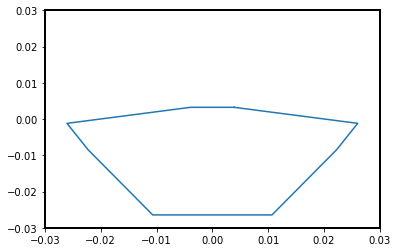

100


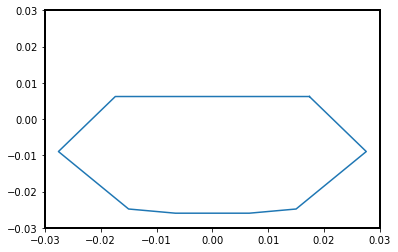

101


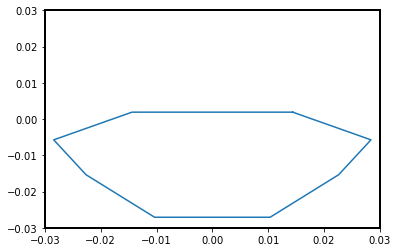

102


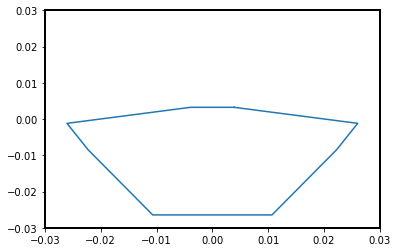

103


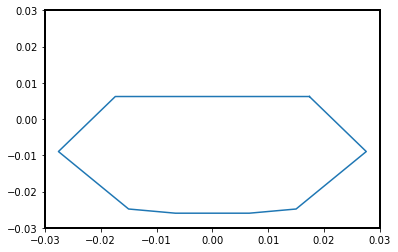

104


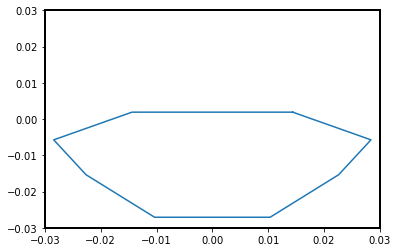

105


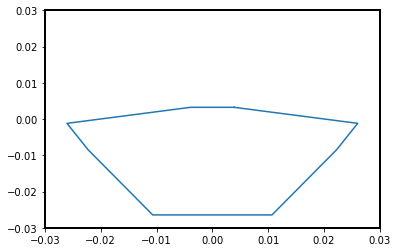

106


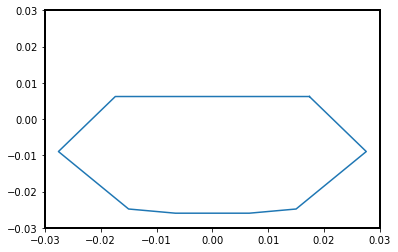

107


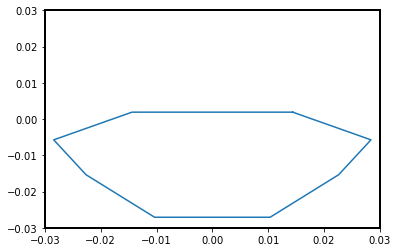

108


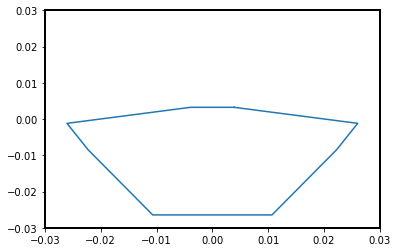

109


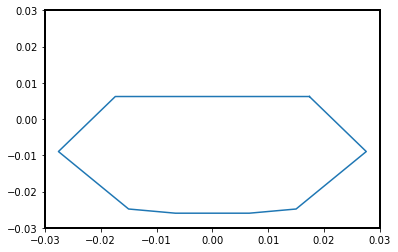

110


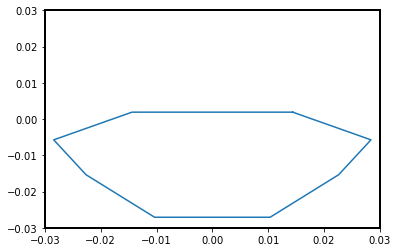

111


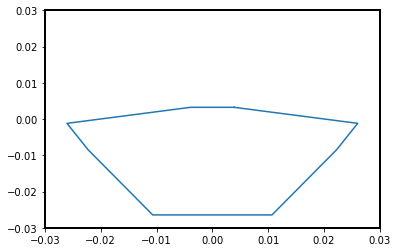

112


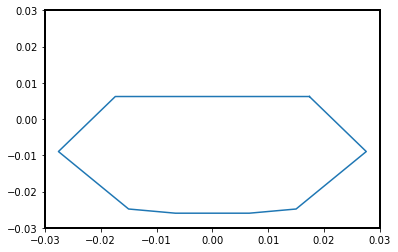

113


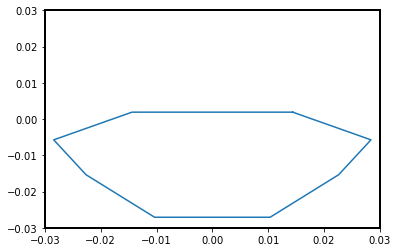

114


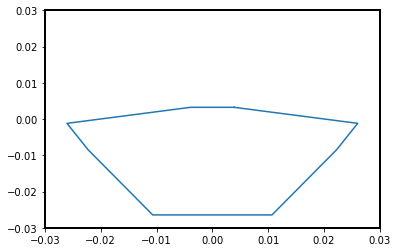

115


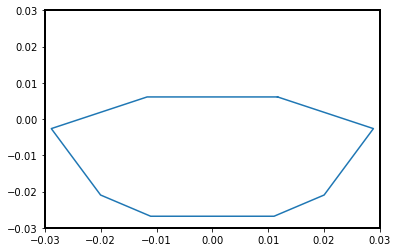

116


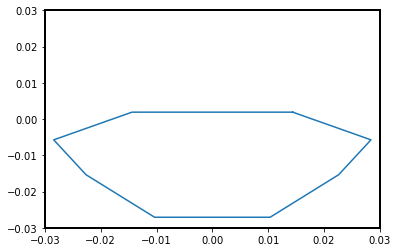

117


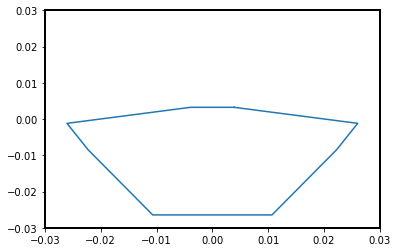

118


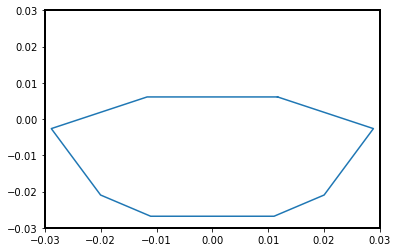

119


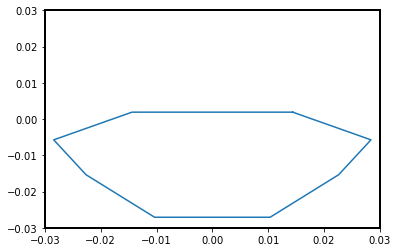

120


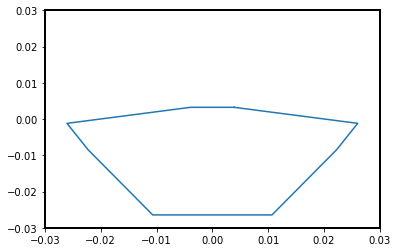

121


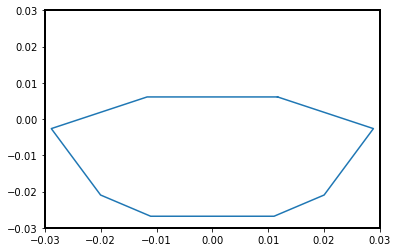

122


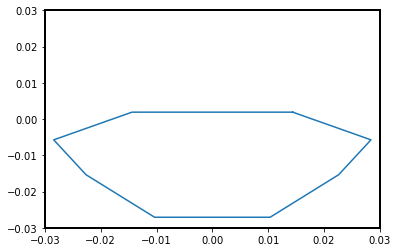

123


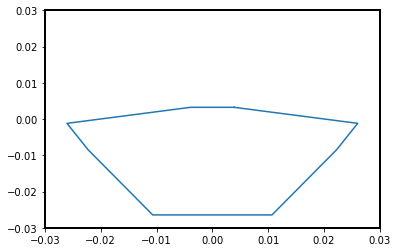

124


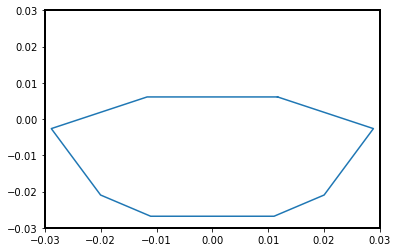

125


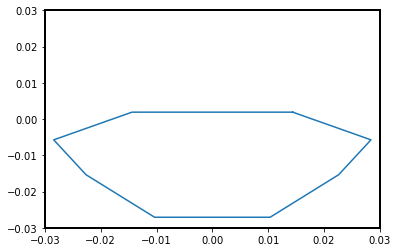

126


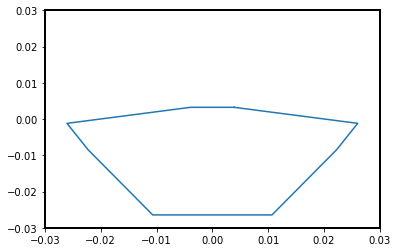

127


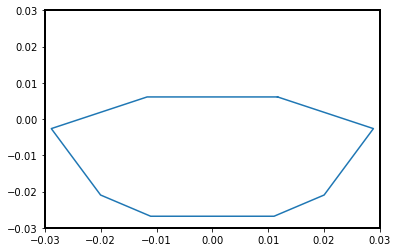

128


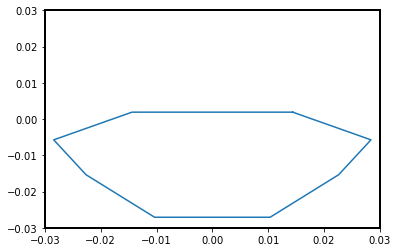

129


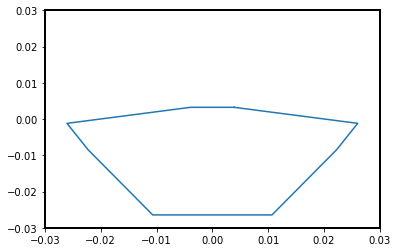

130


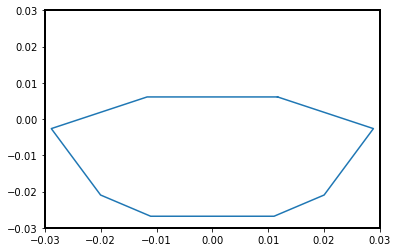

131


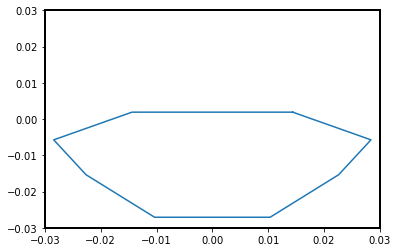

132


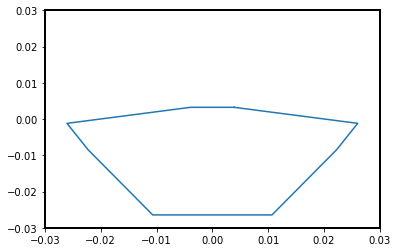

133


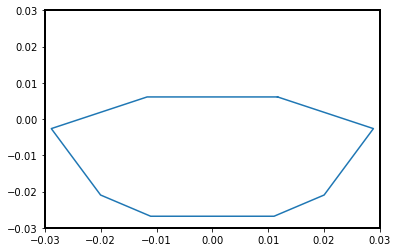

134


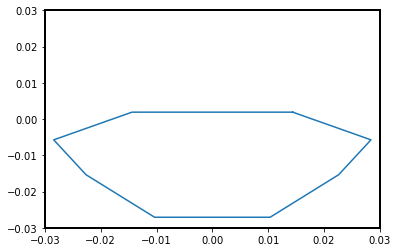

135


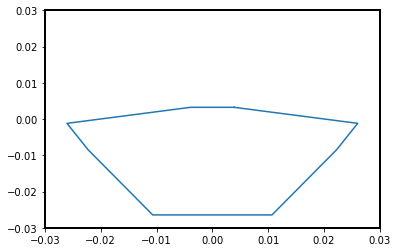

136


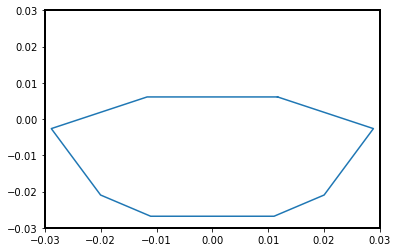

137


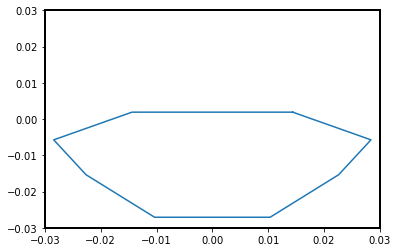

138


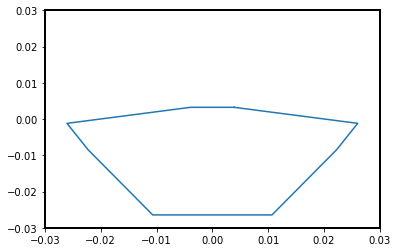

139


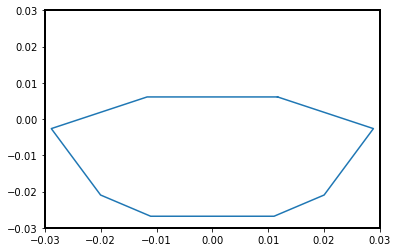

140


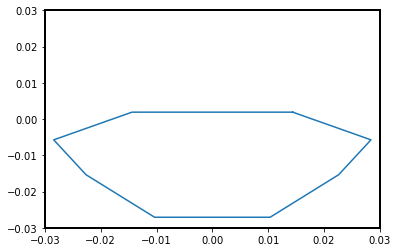

141


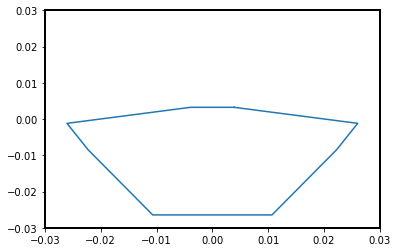

142


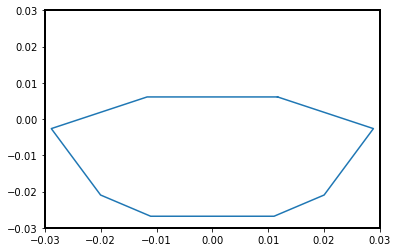

143


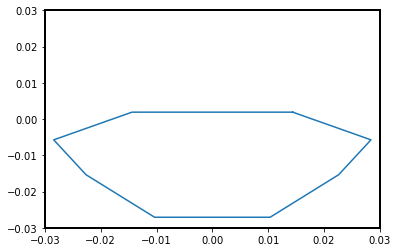

144


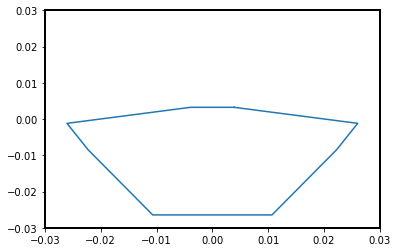

145


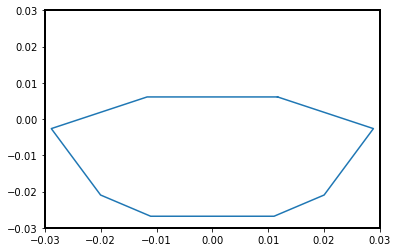

146


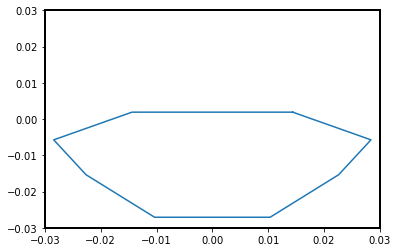

147


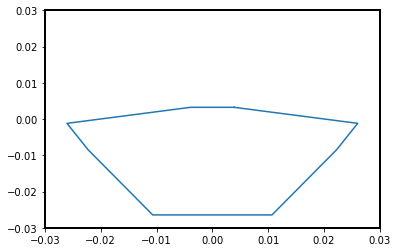

148


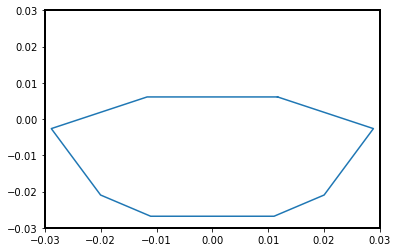

149


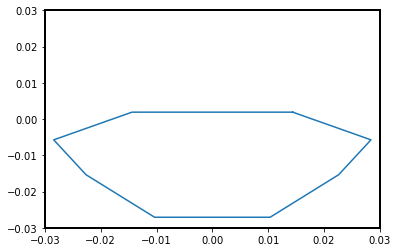

150


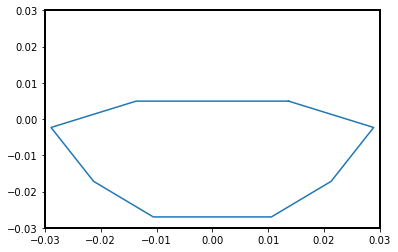

151


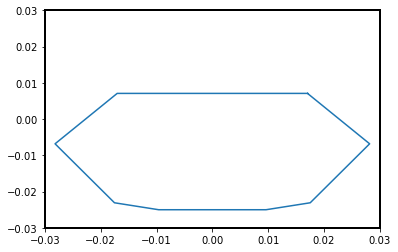

152


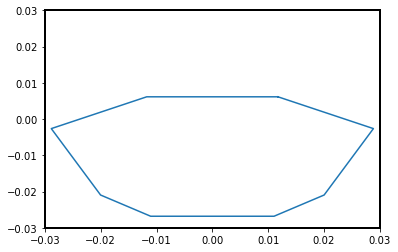

153


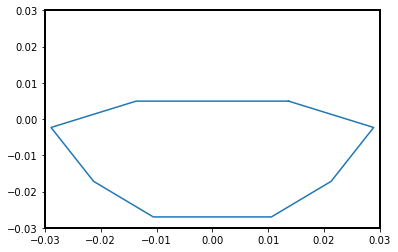

154


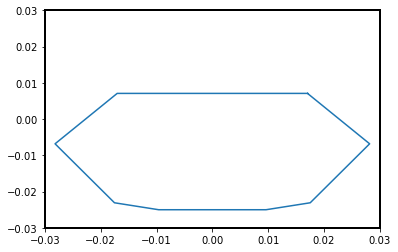

155


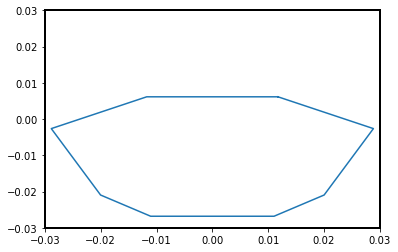

156


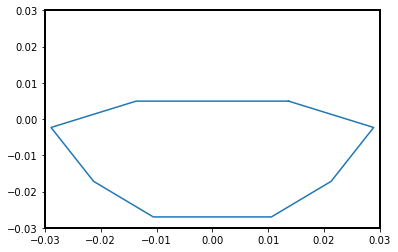

157


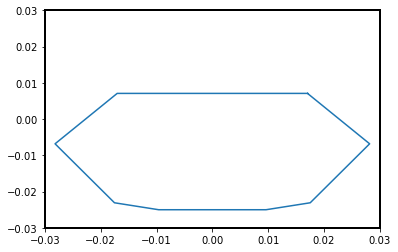

158


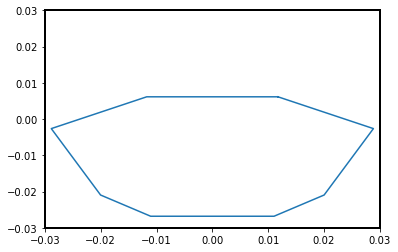

159


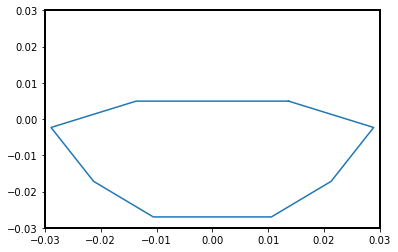

160


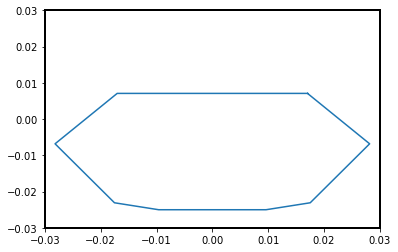

161


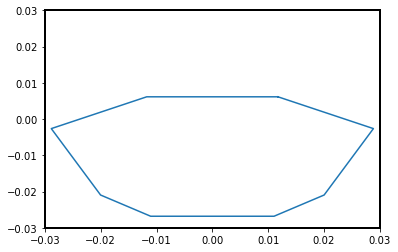

162


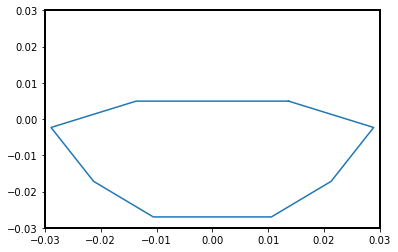

163


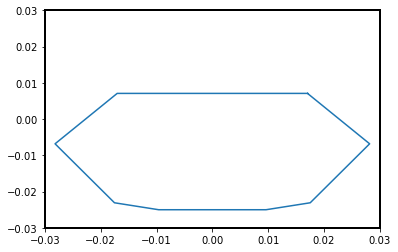

164


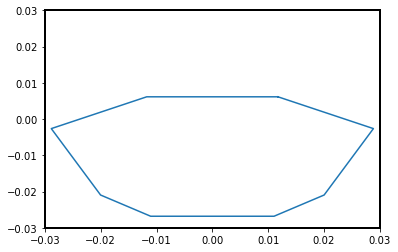

165


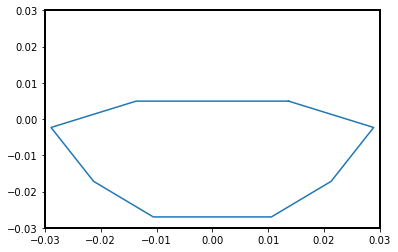

166


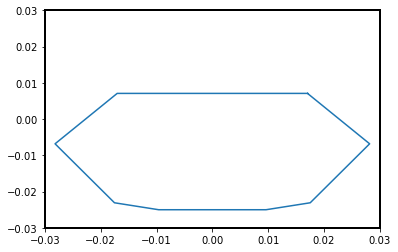

167


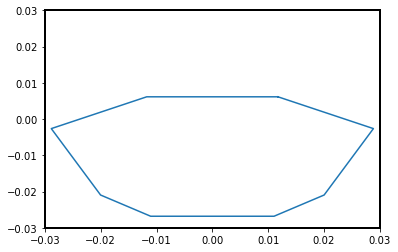

168


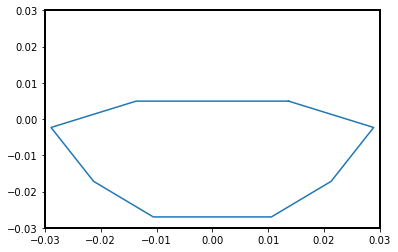

169


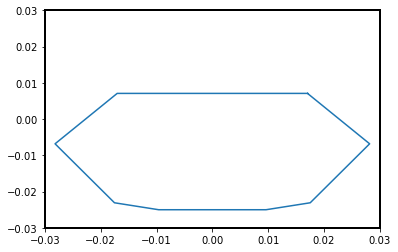

170


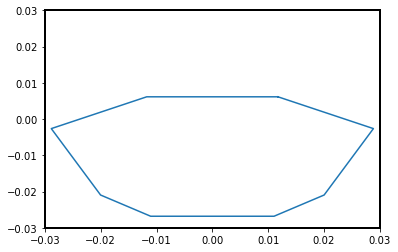

171


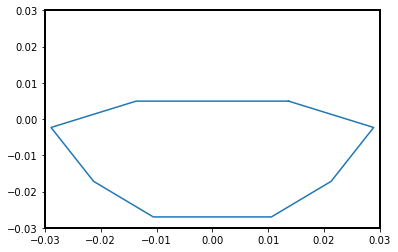

172


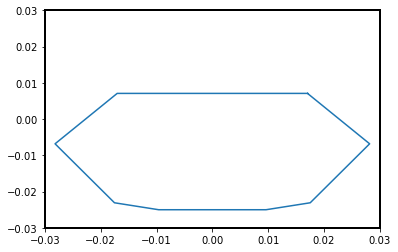

173


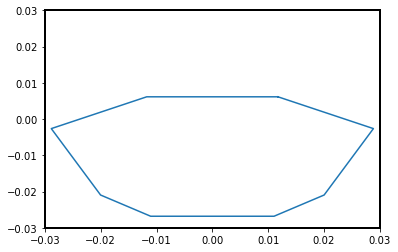

174


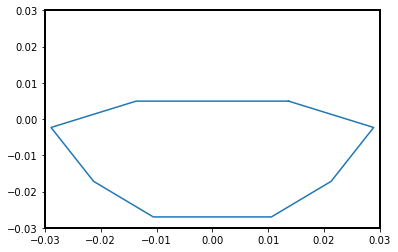

175


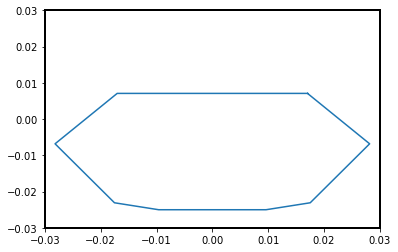

176


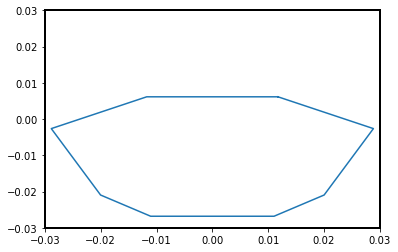

177


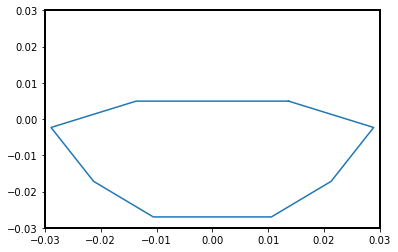

178


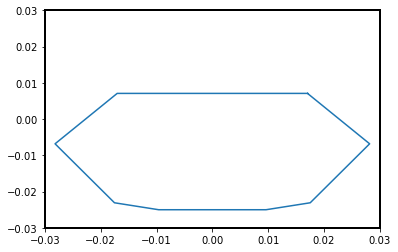

179


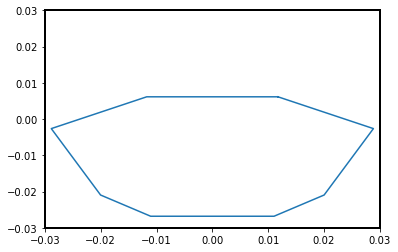

180


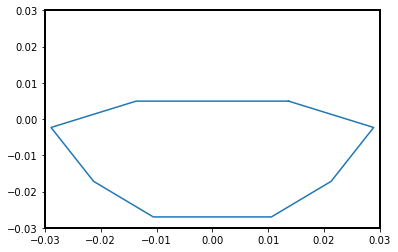

181


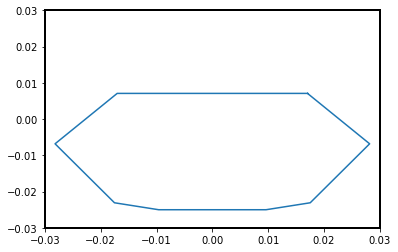

182


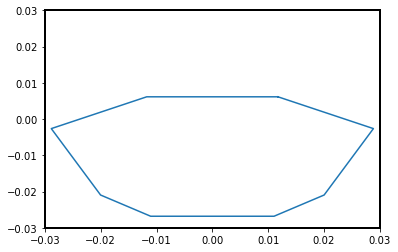

183


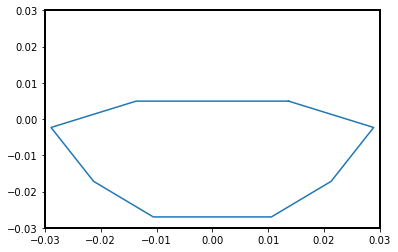

184


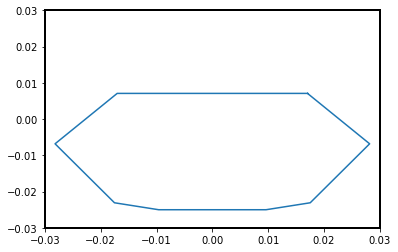

185


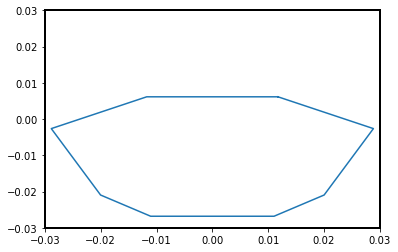

186


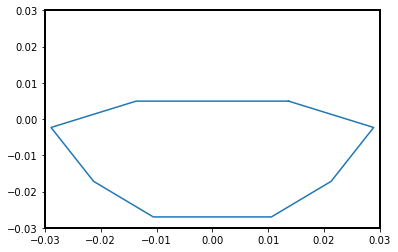

187


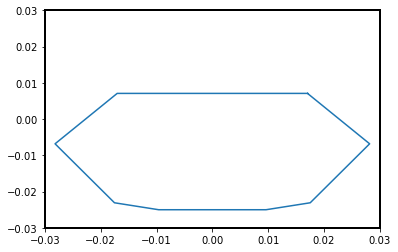

188


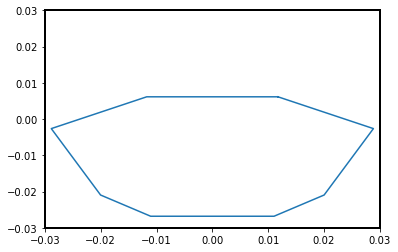

189


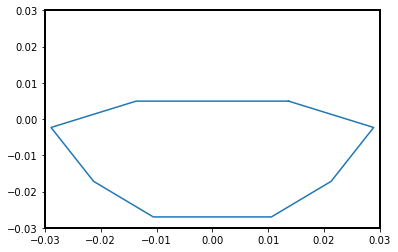

190


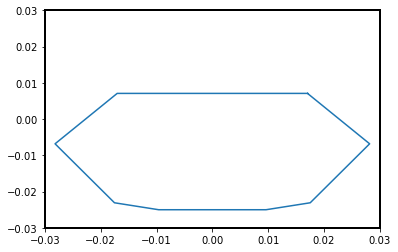

191


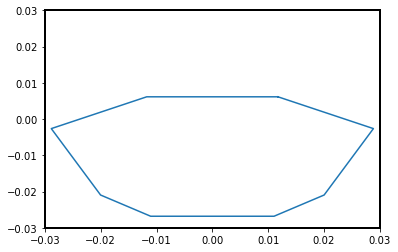

192


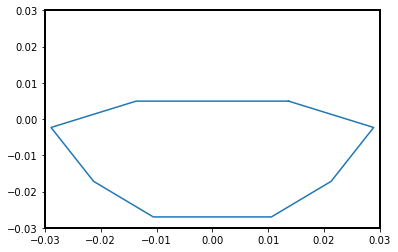

193


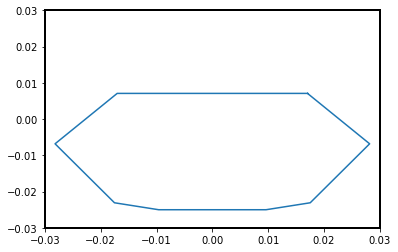

194


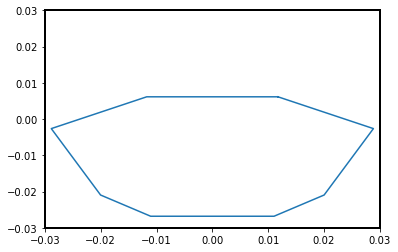

195


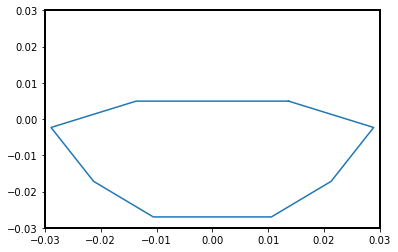

196


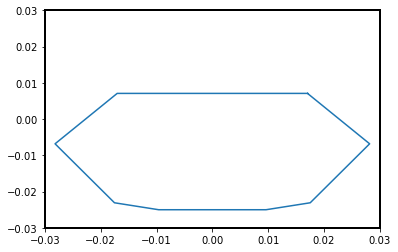

197


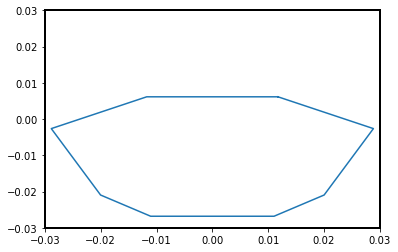

198


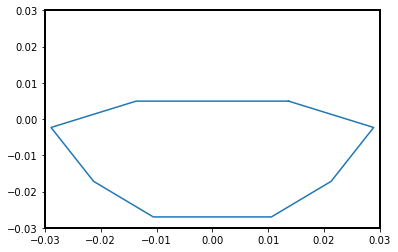

199


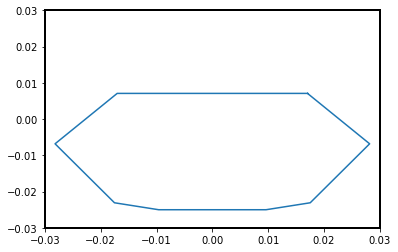

200


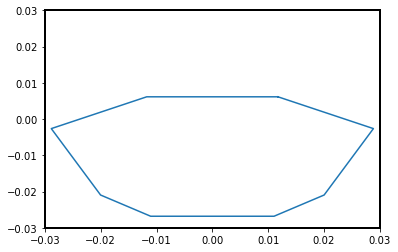

201


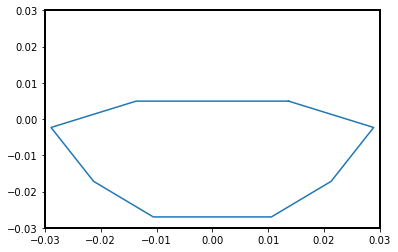

202


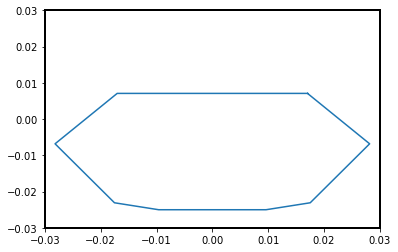

203


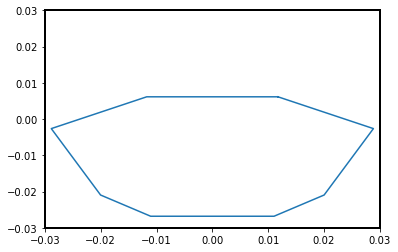

204


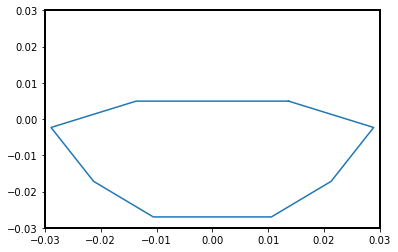

205


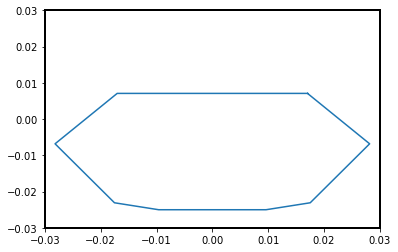

206


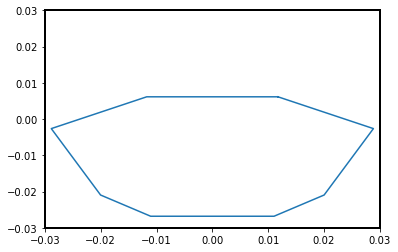

207


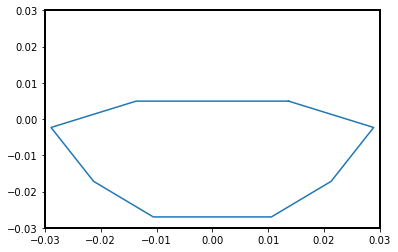

208


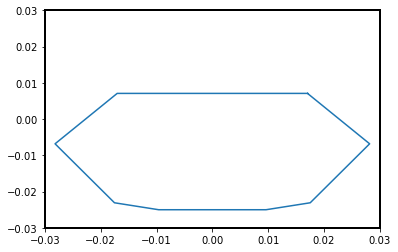

209


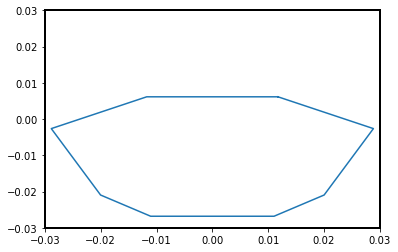

210


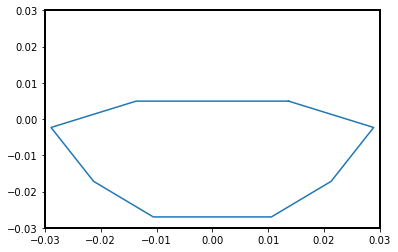

211


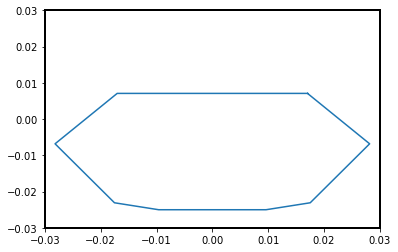

212


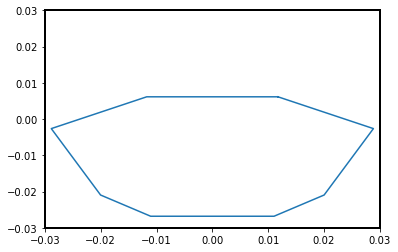

213


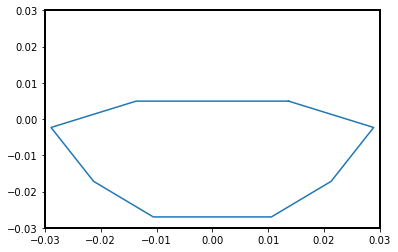

214


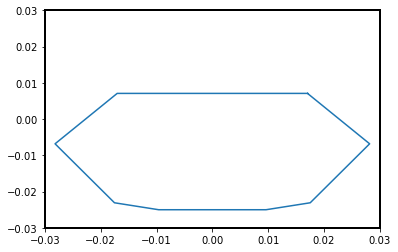

215


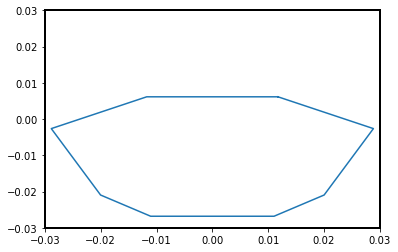

216


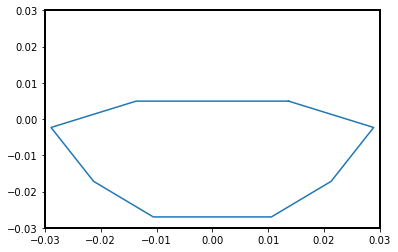

217


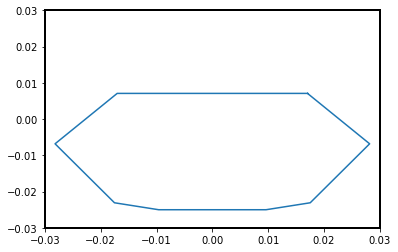

218


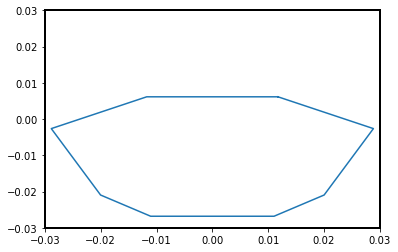

219


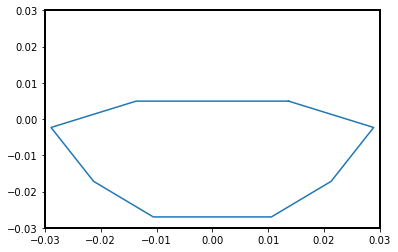

220


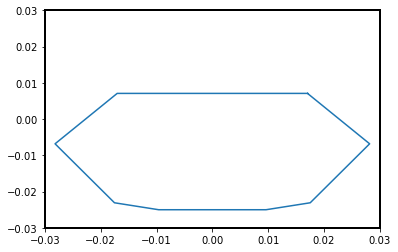

221


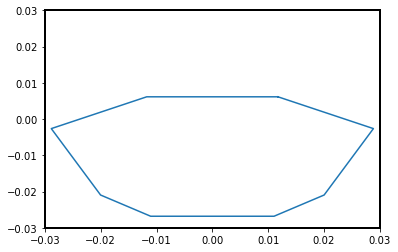

222


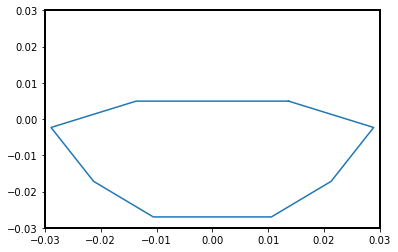

223


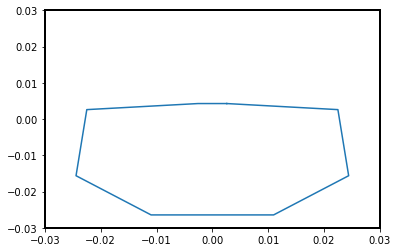

224


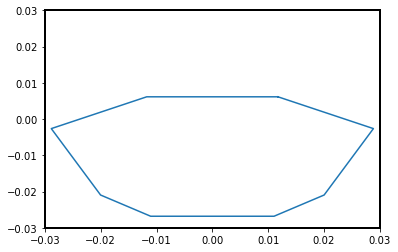

225


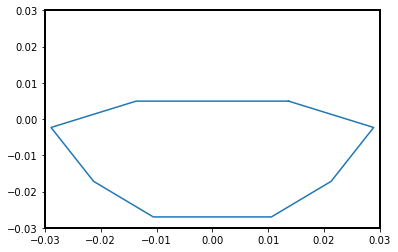

226


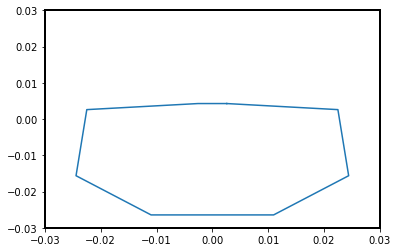

227


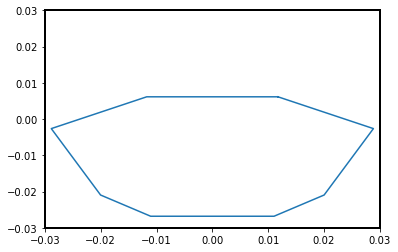

228


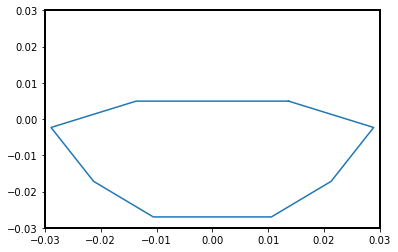

229


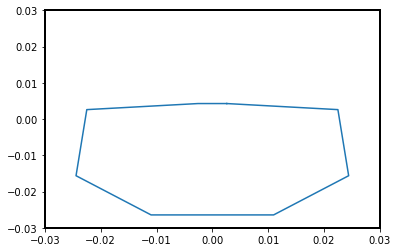

230


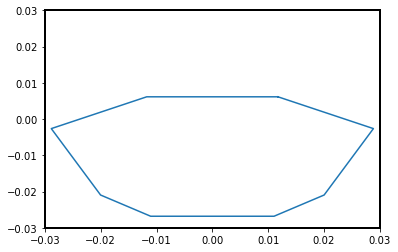

231


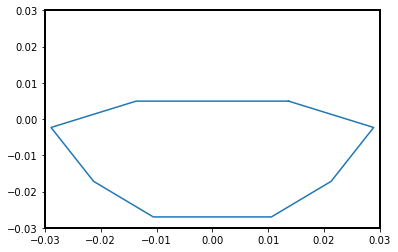

232


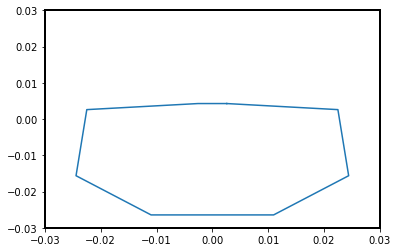

233


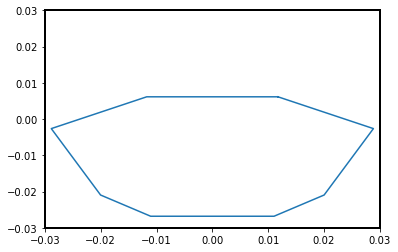

234


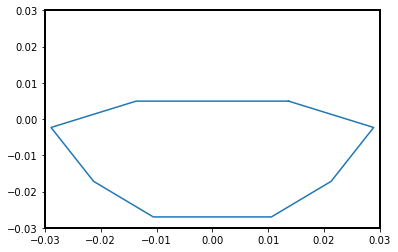

235


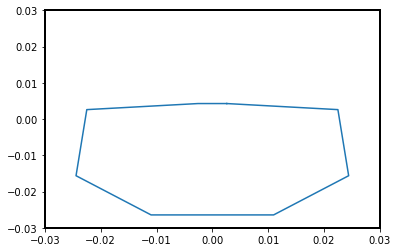

236


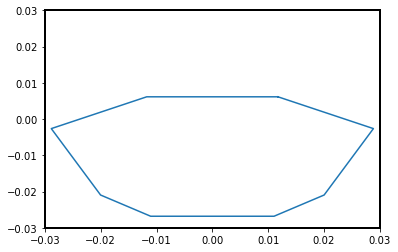

237


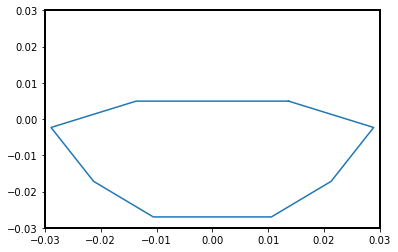

238


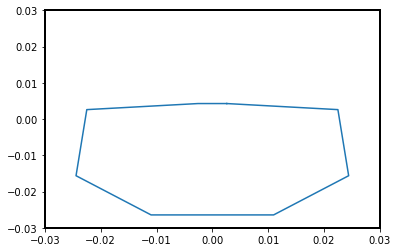

239


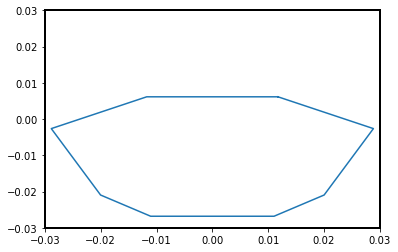

240


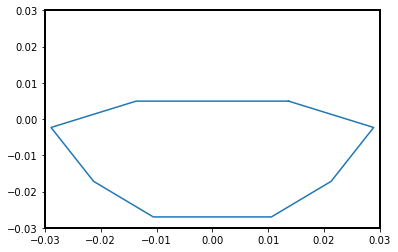

241


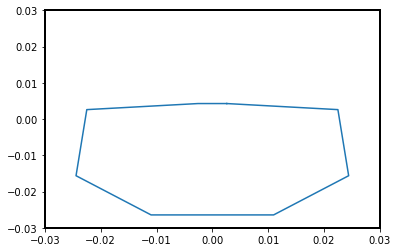

242


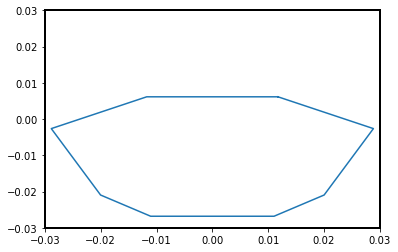

243


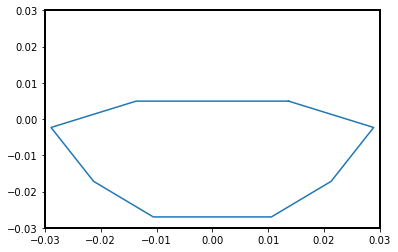

244


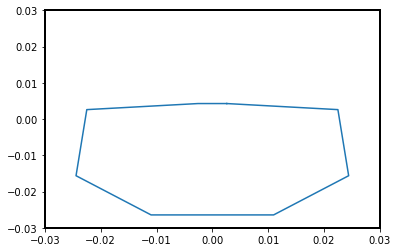

245


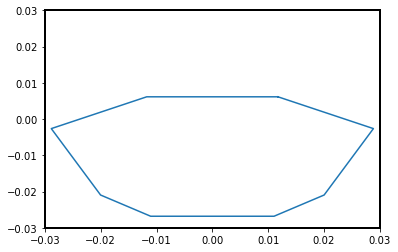

246


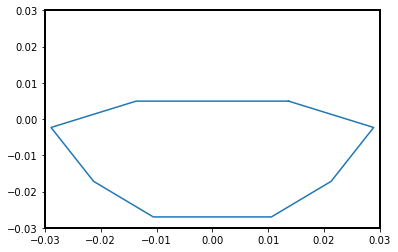

247


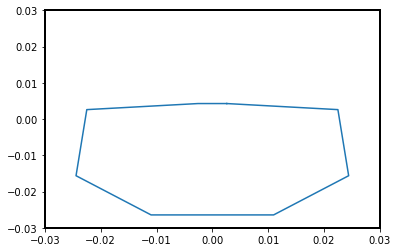

248


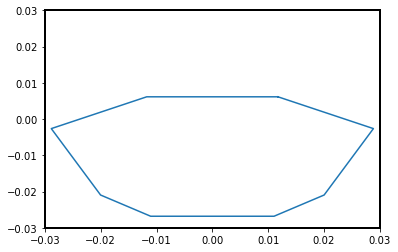

249


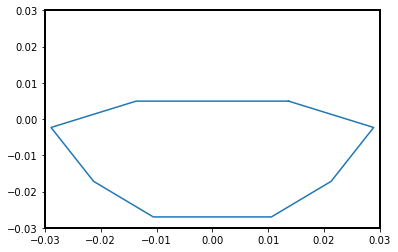

250


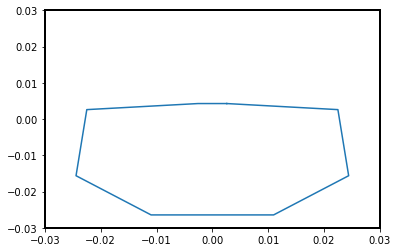

251


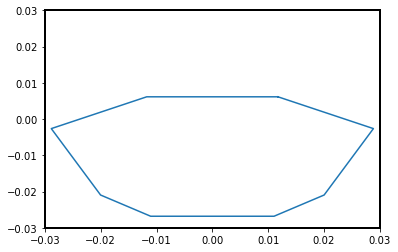

252


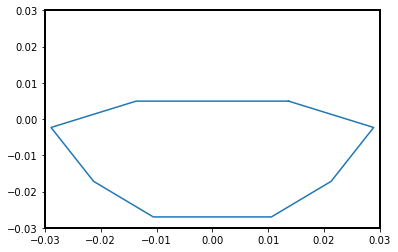

253


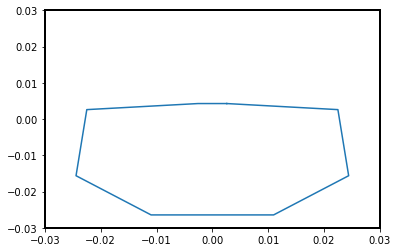

254


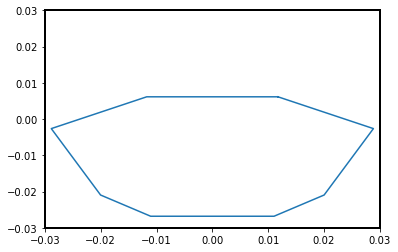

255


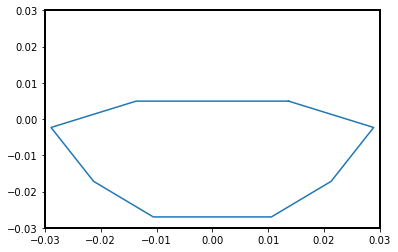

256


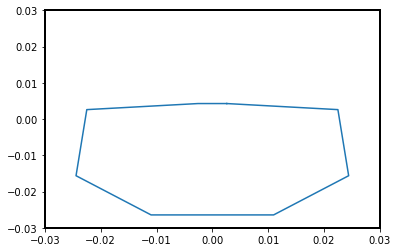

257


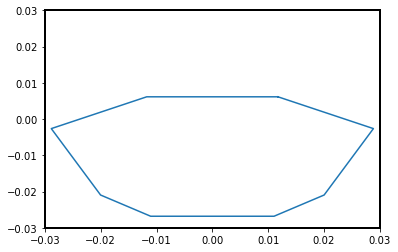

258


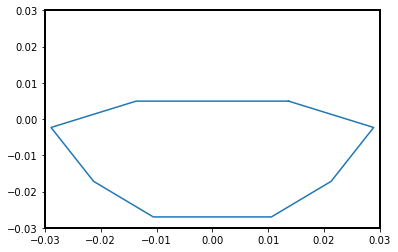

259


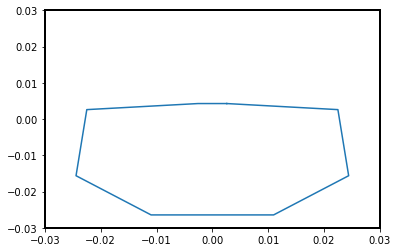

260


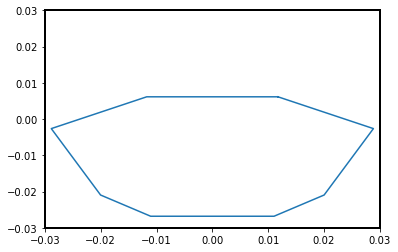

261


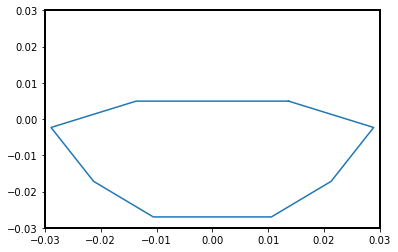

262


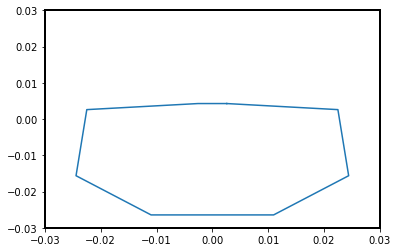

263


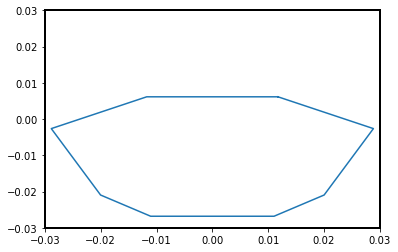

264


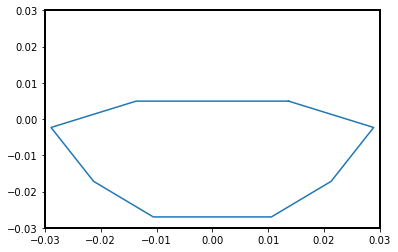

265


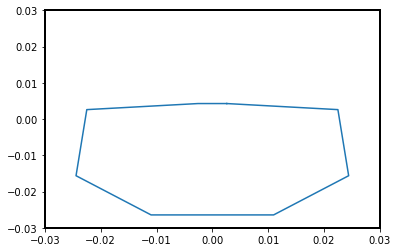

266


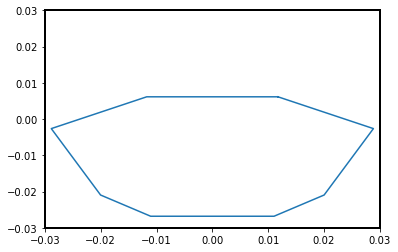

267


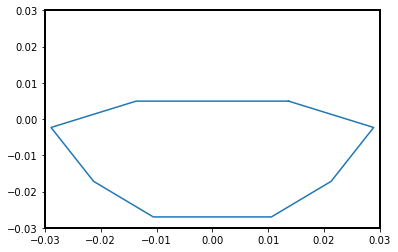

268


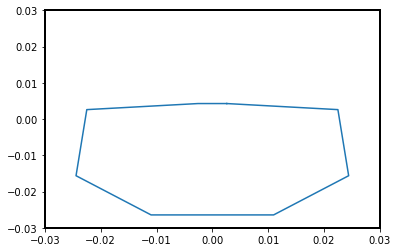

269


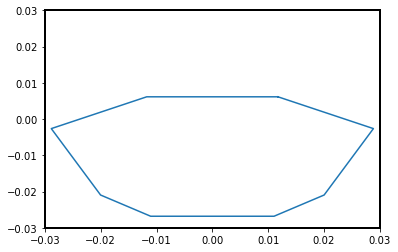

270


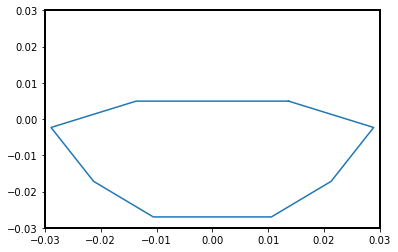

271


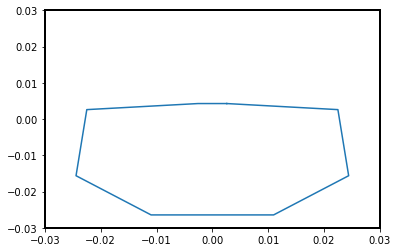

272


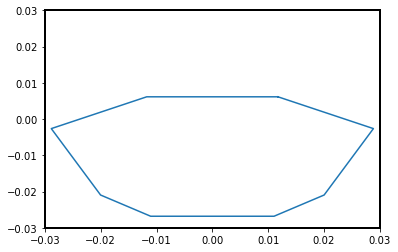

273


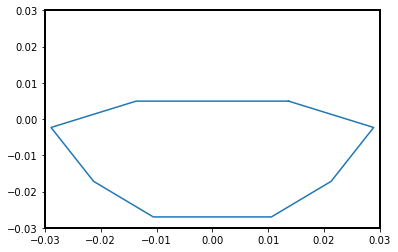

274


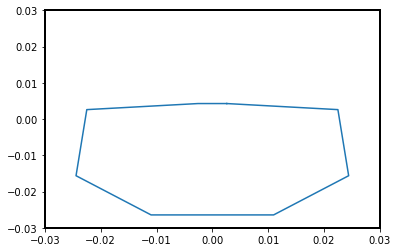

275


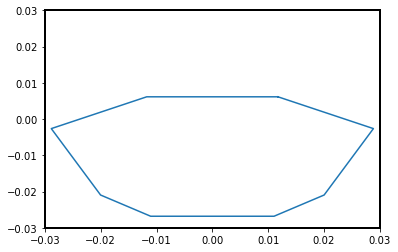

276


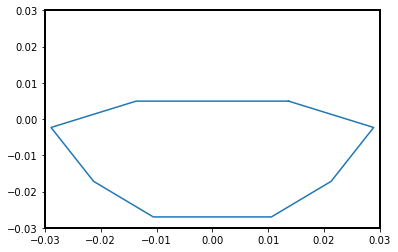

277


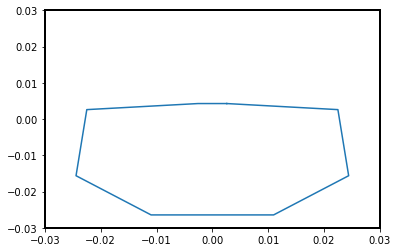

278


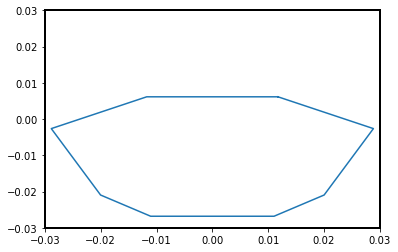

279


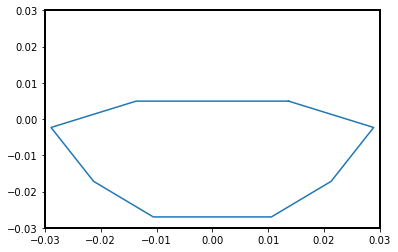

280


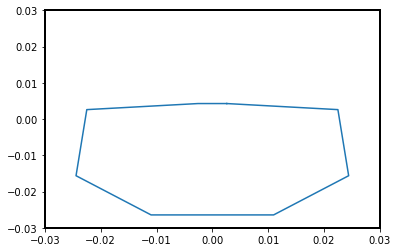

281


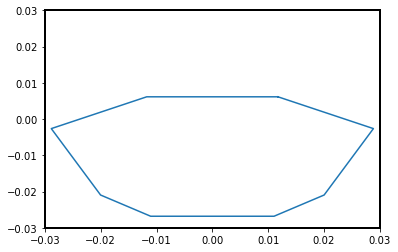

282


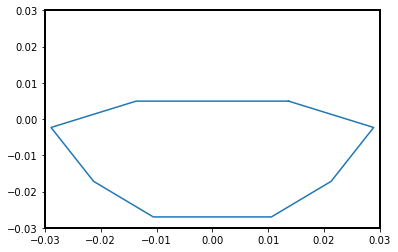

283


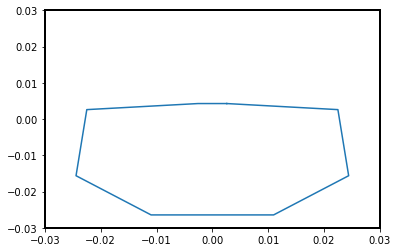

284


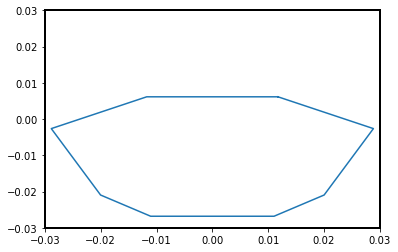

285


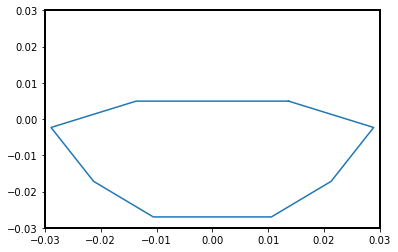

286


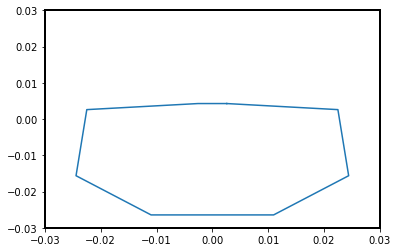

287


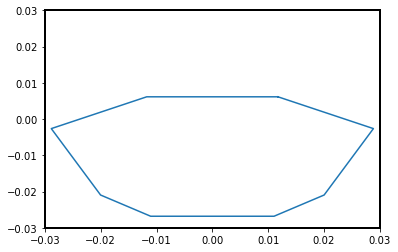

288


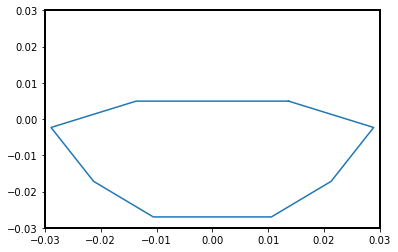

289


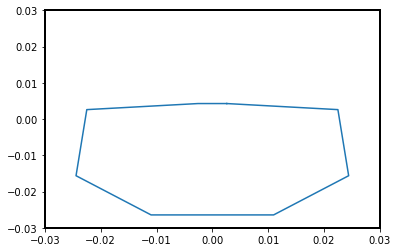

290


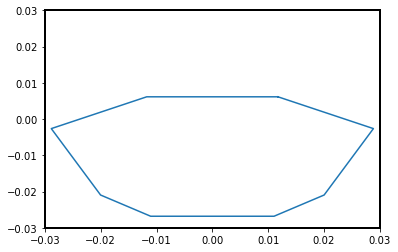

291


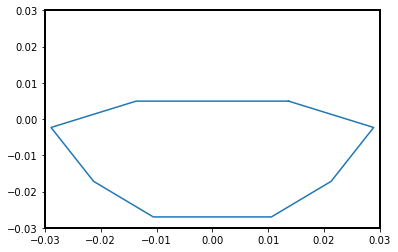

292


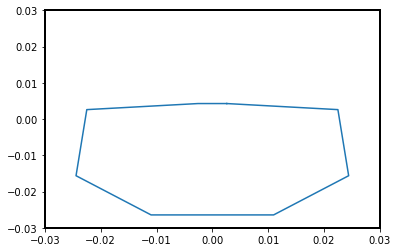

293


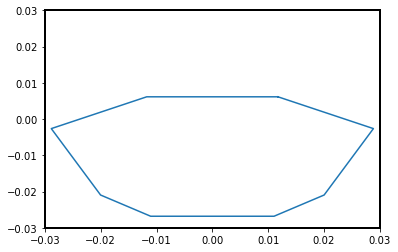

294


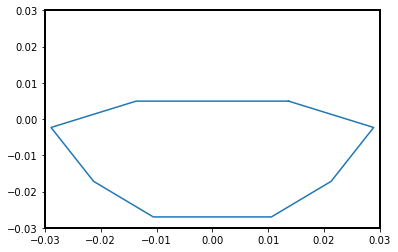

295


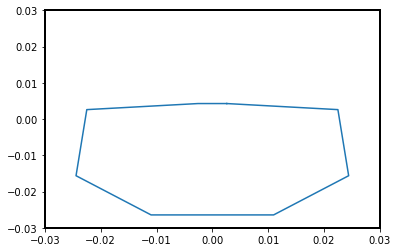

296


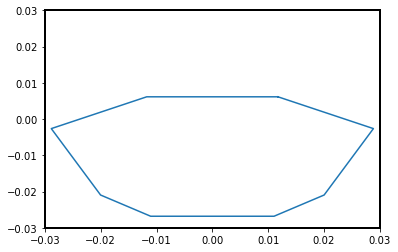

297


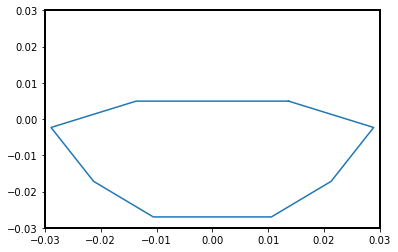

298


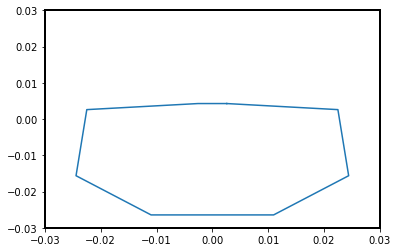

299


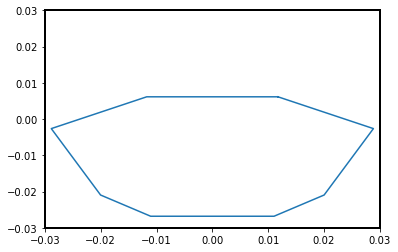

300


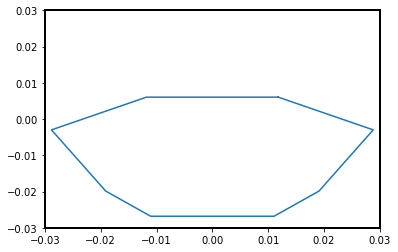

301


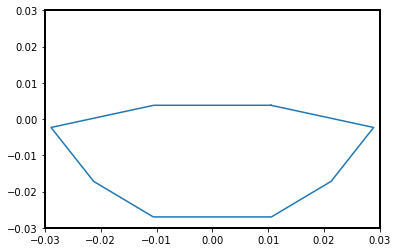

302


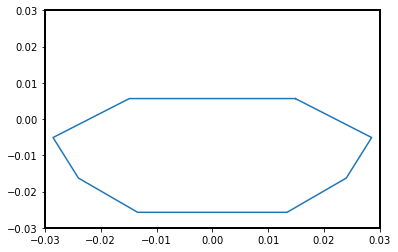

303


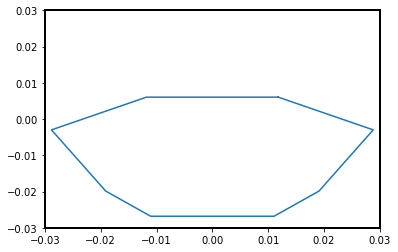

304


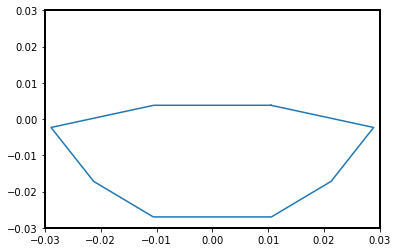

305


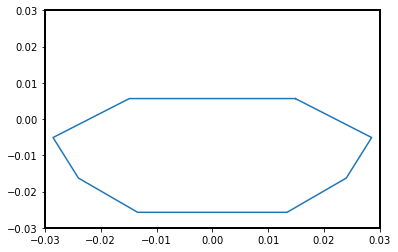

306


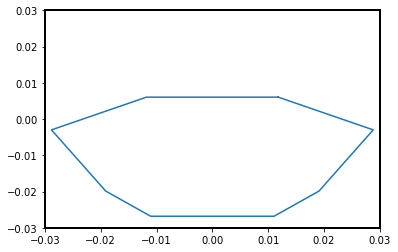

307


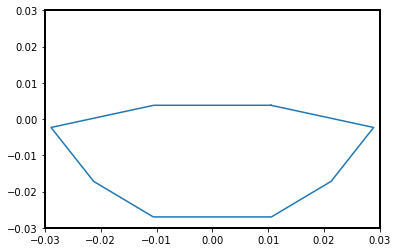

308


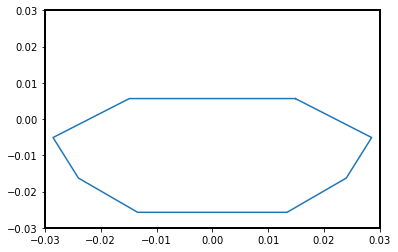

309


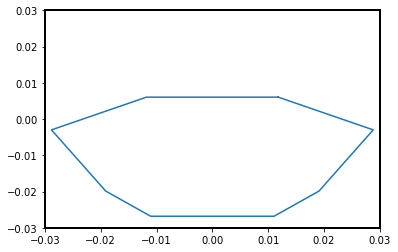

310


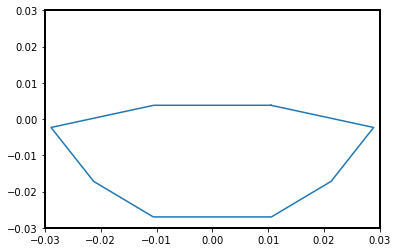

311


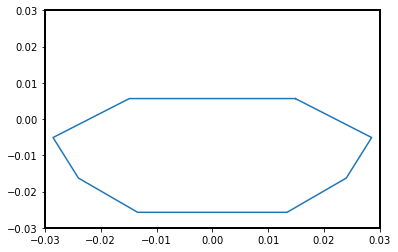

312


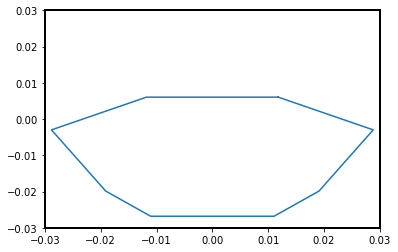

313


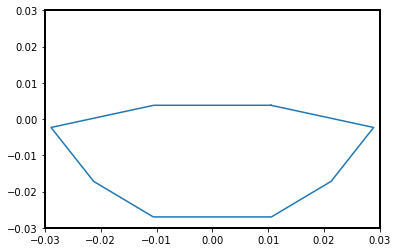

314


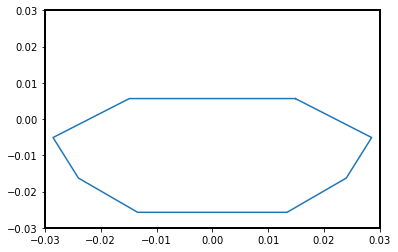

315


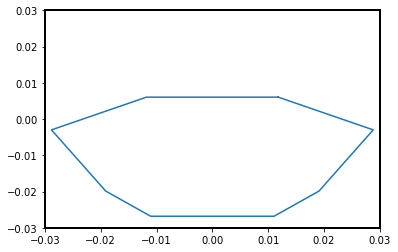

316


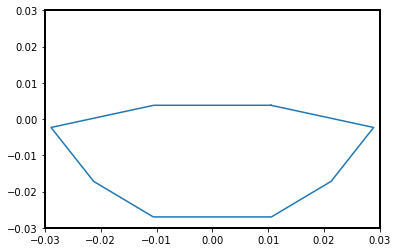

317


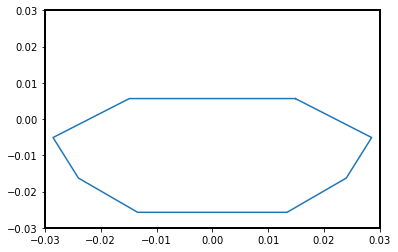

318


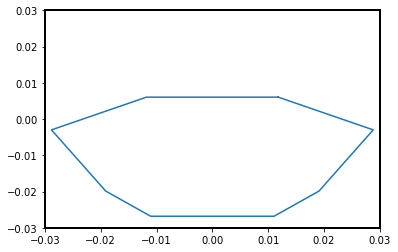

319


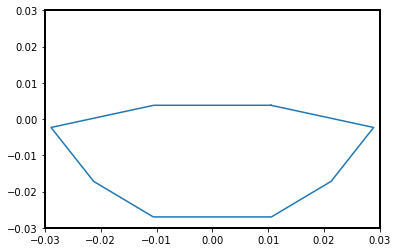

320


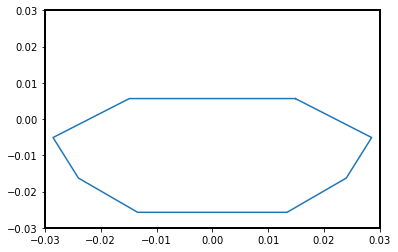

321


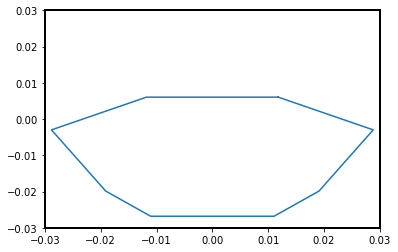

322


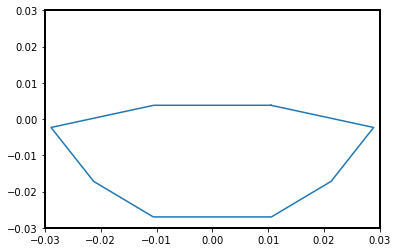

323


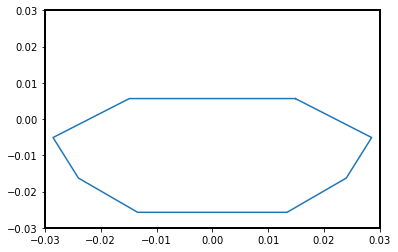

324


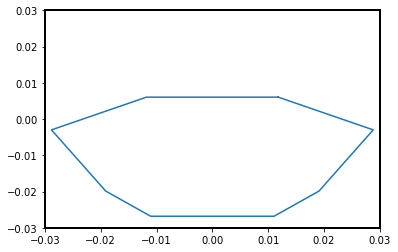

325


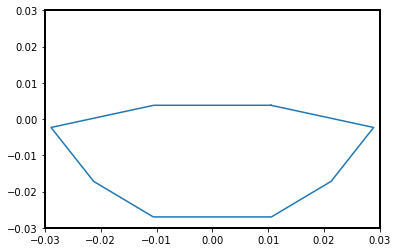

326


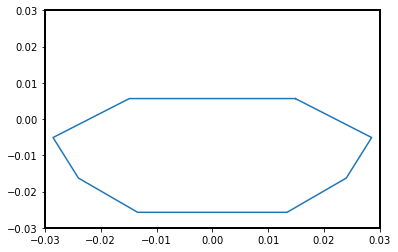

327


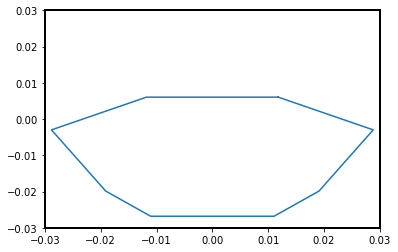

328


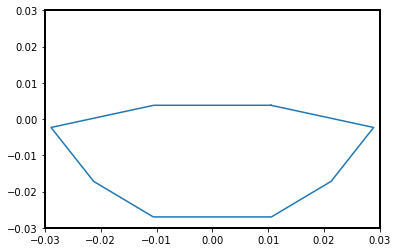

329


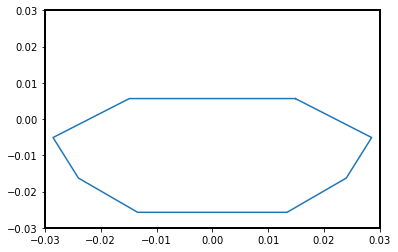

330


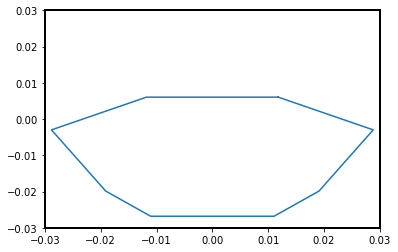

331


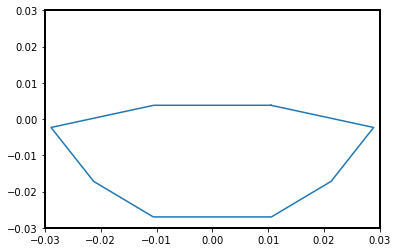

332


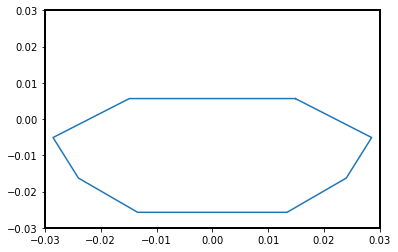

333


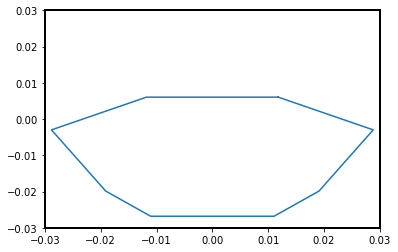

334


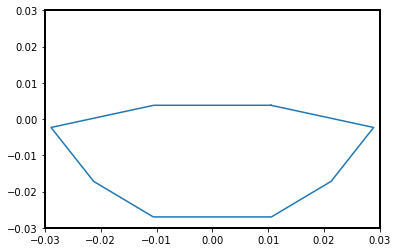

335


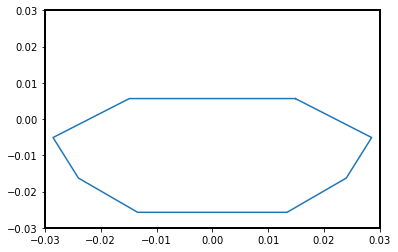

336


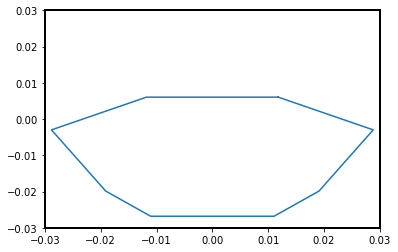

337


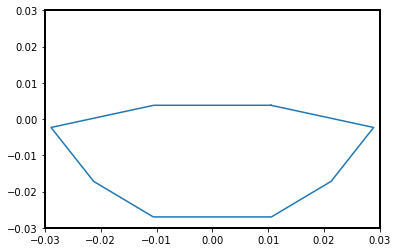

338


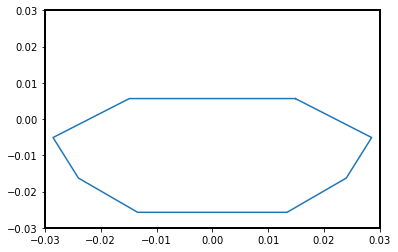

339


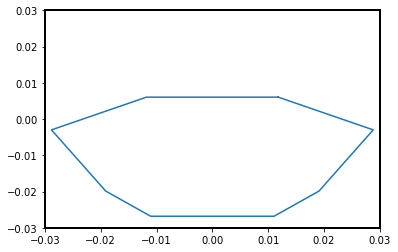

340


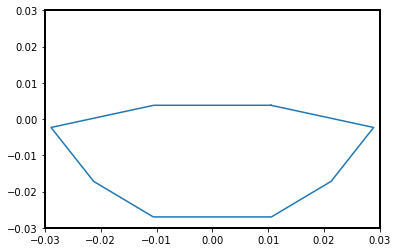

341


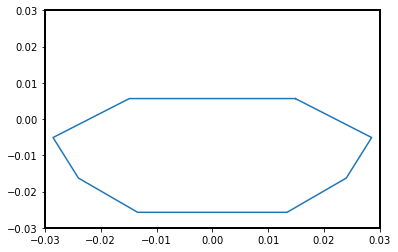

342


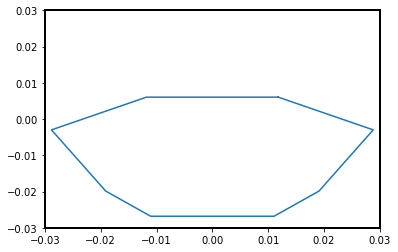

343


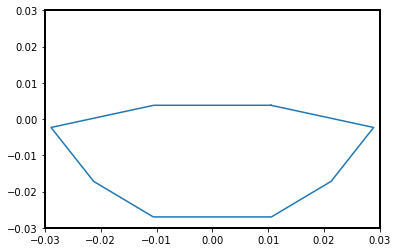

344


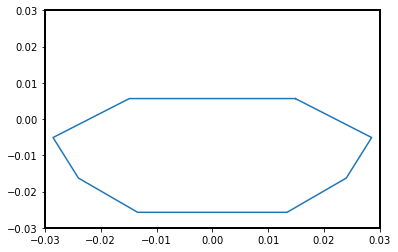

345


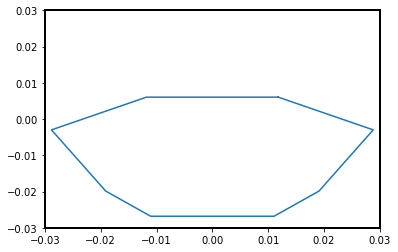

346


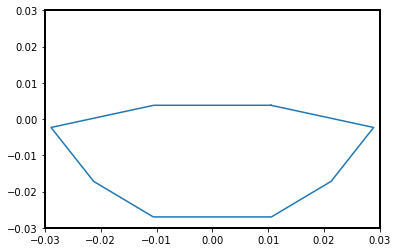

347


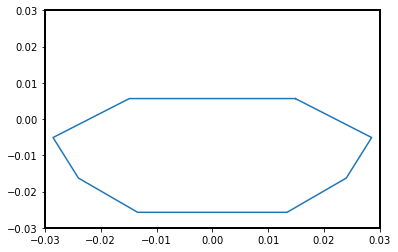

348


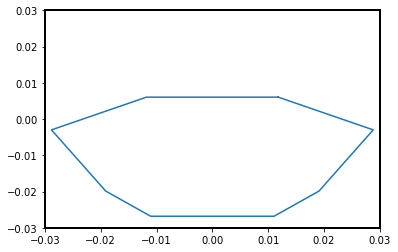

349


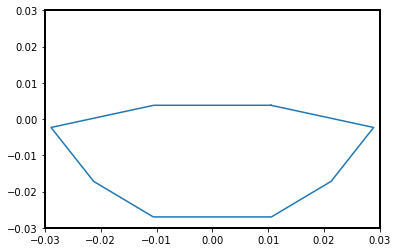

350


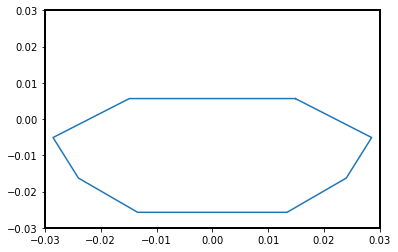

351


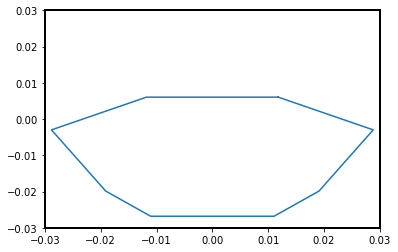

352


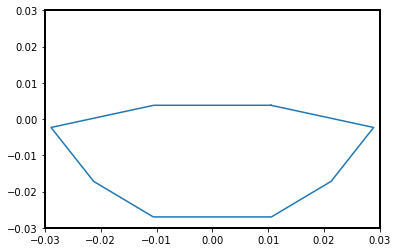

353


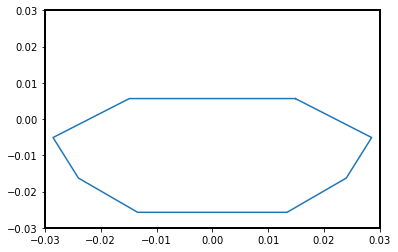

354


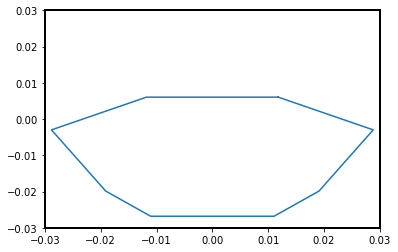

355


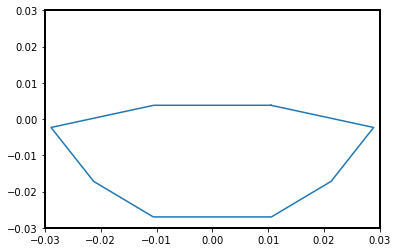

356


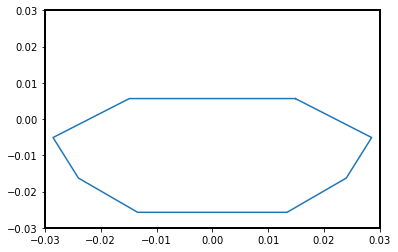

357


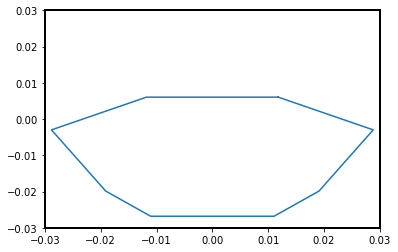

358


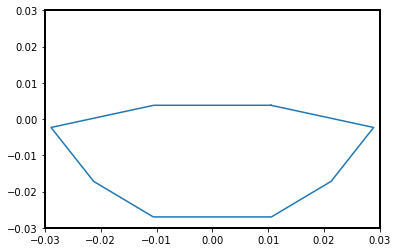

359


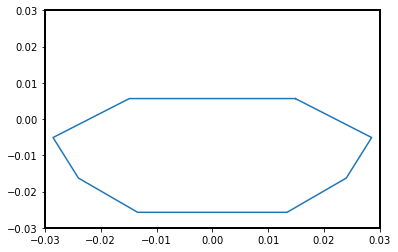

360


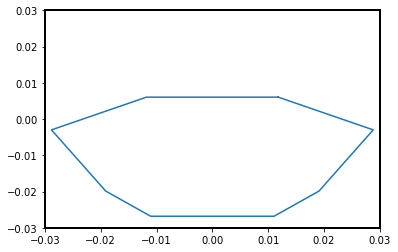

361


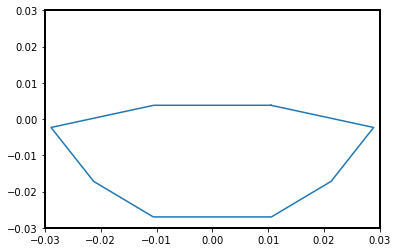

362


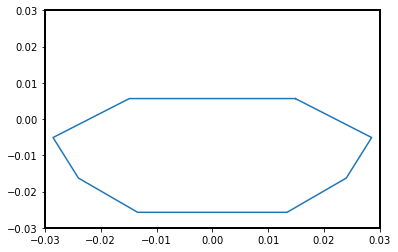

363


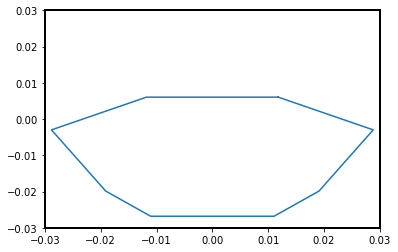

364


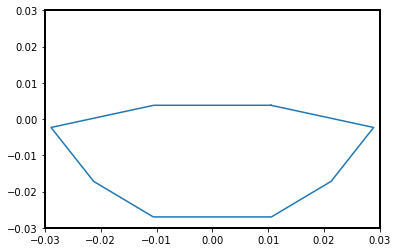

365


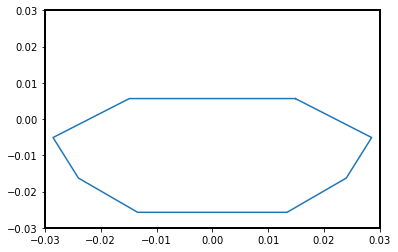

366


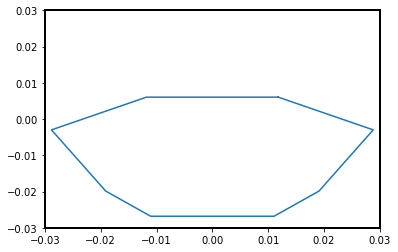

367


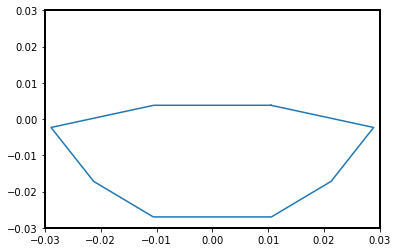

368


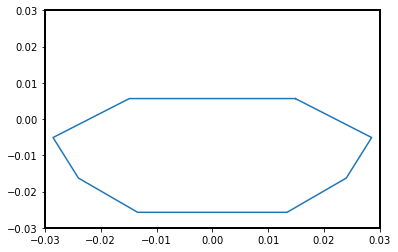

369


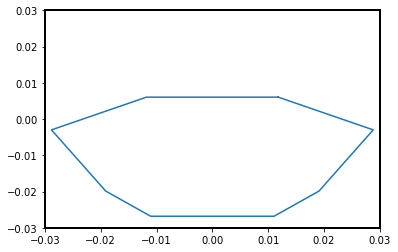

370


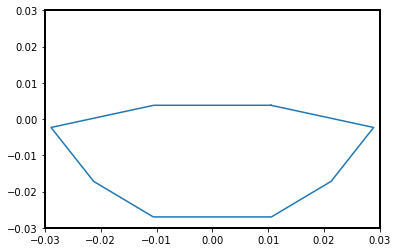

371


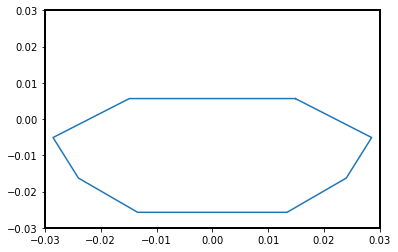

372


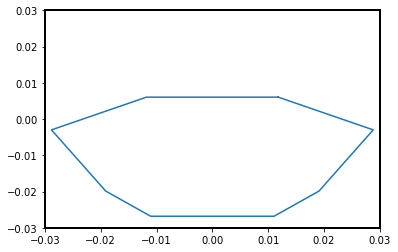

373


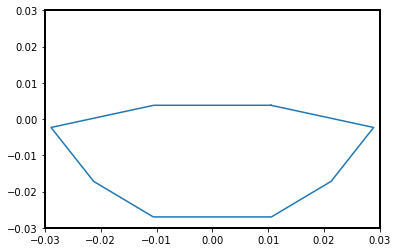

374


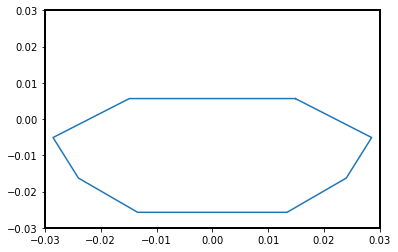

375


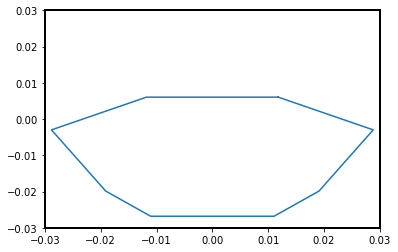

376


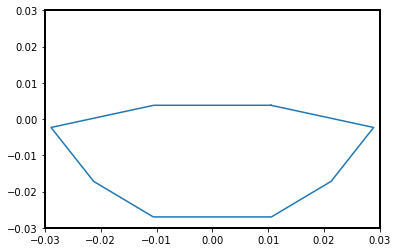

377


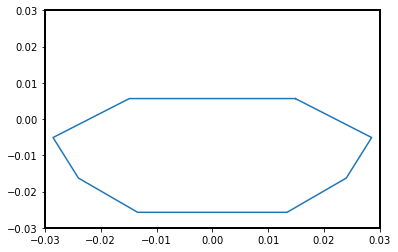

378


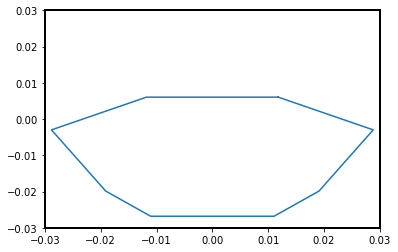

379


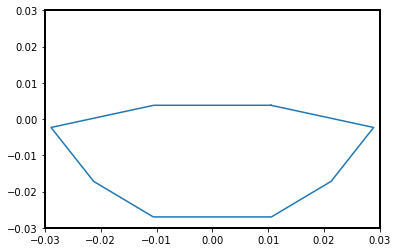

380


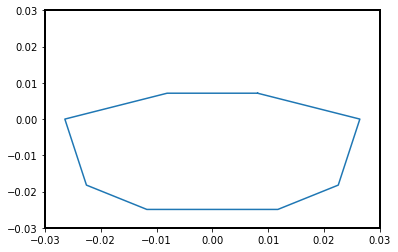

381


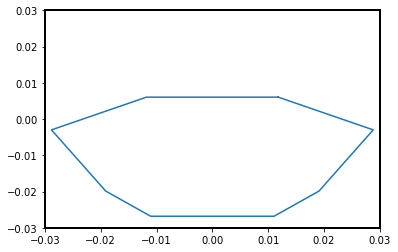

382


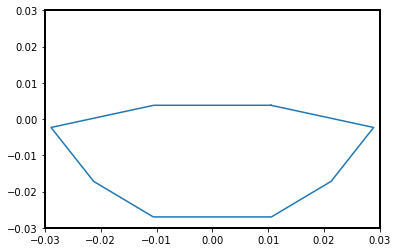

383


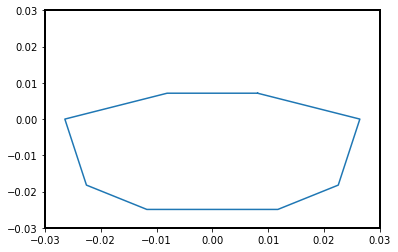

384


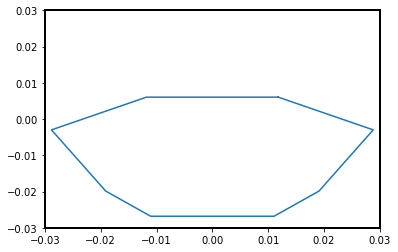

385


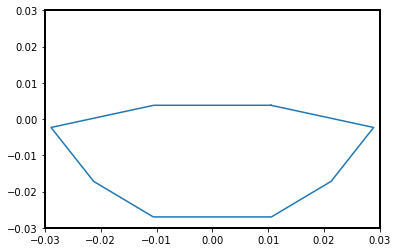

386


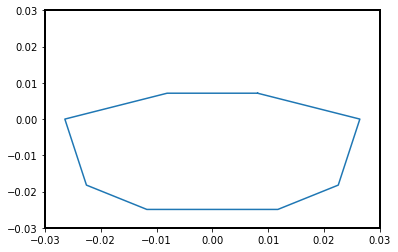

387


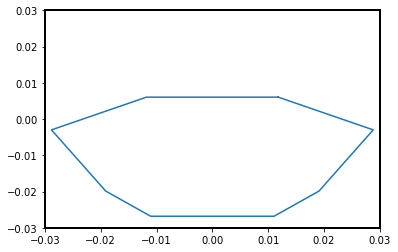

388


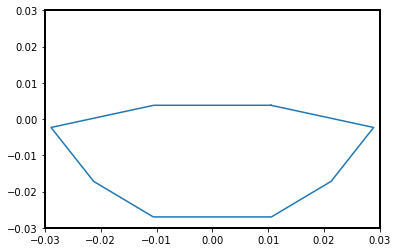

389


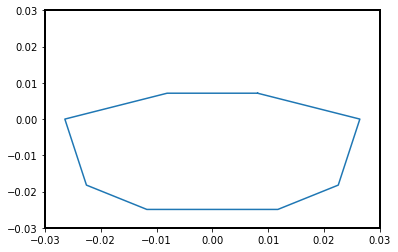

390


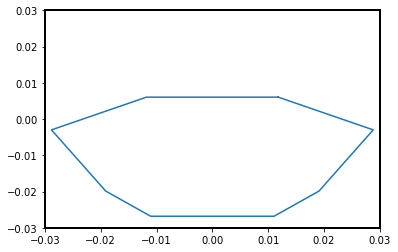

391


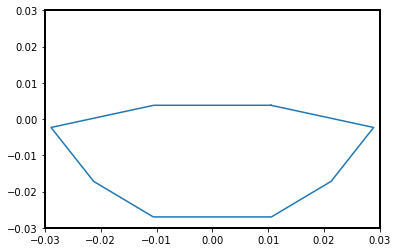

392


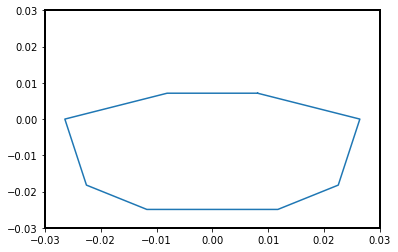

393


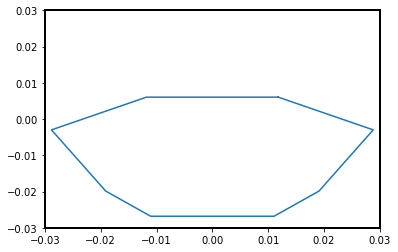

394


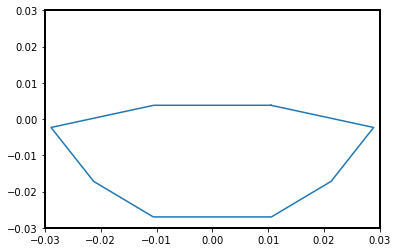

395


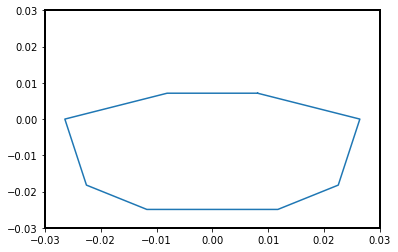

396


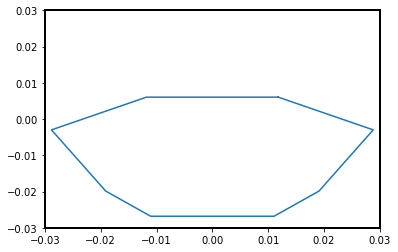

397


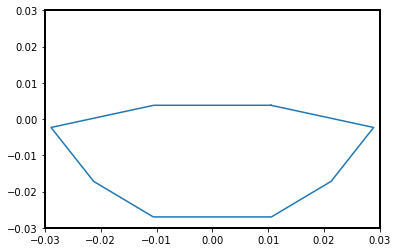

398


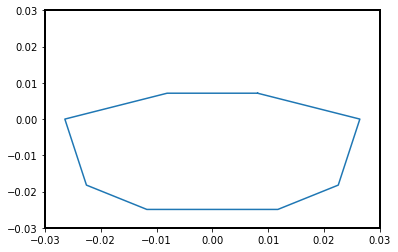

399


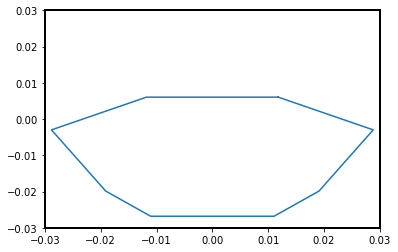

400


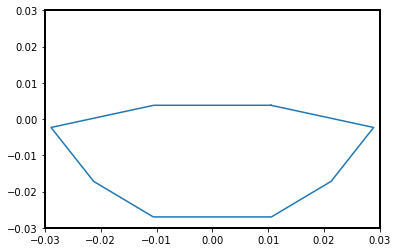

401


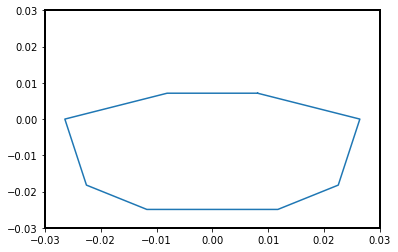

402


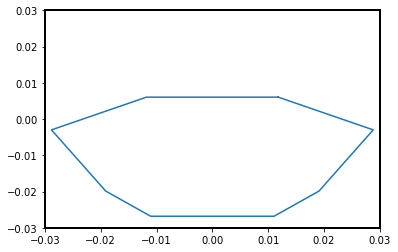

403


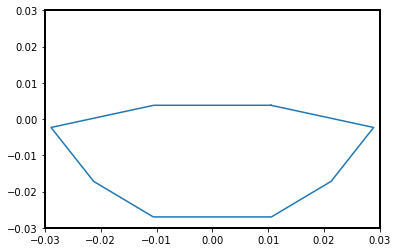

404


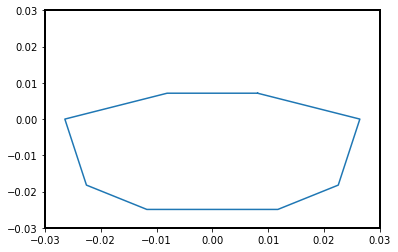

405


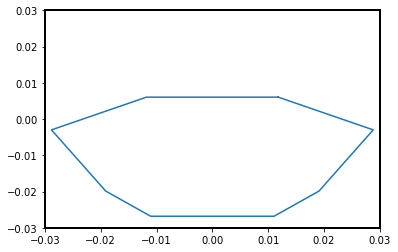

406


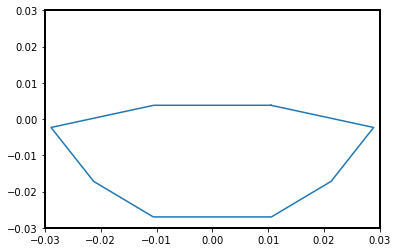

407


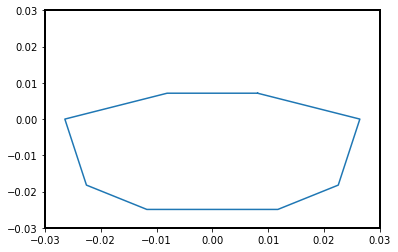

408


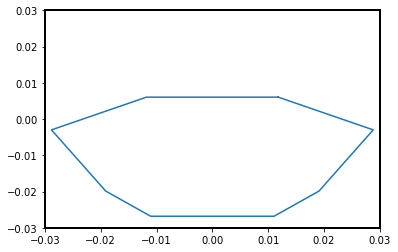

409


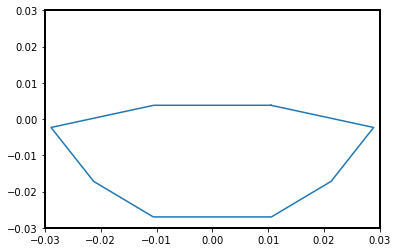

410


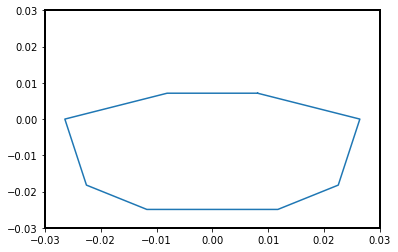

411


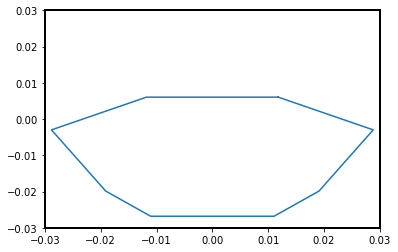

412


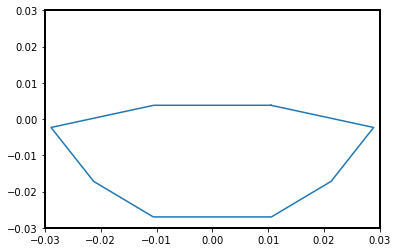

413


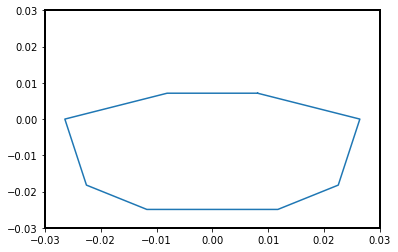

414


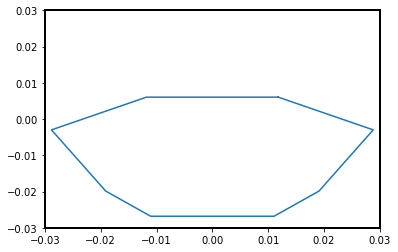

415


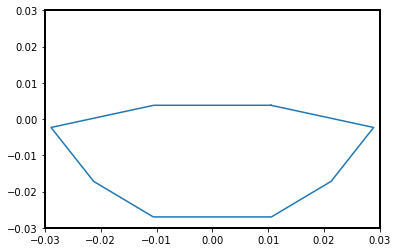

416


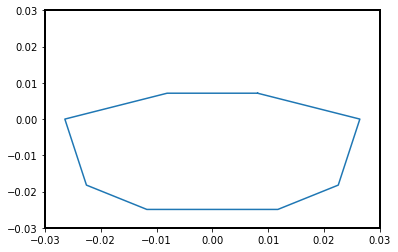

417


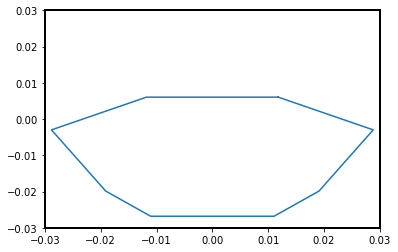

418


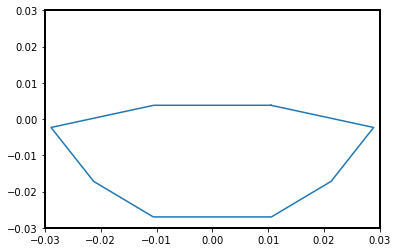

419


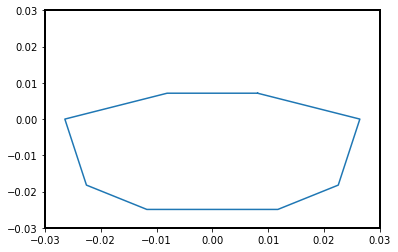

420


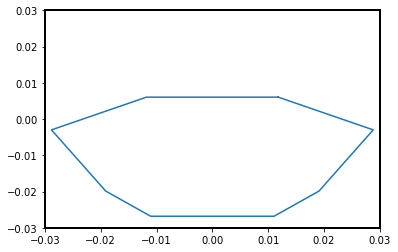

421


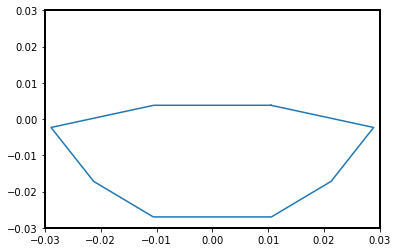

422


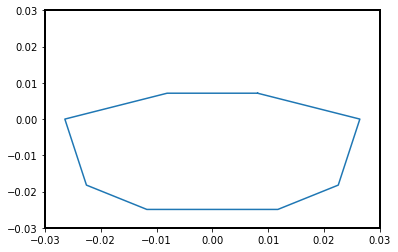

423


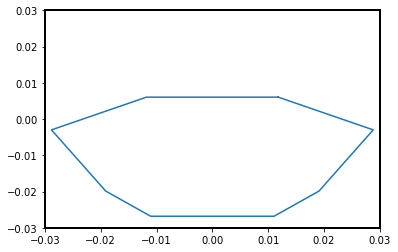

424


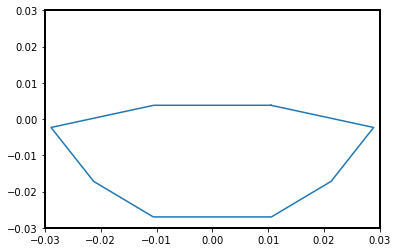

425


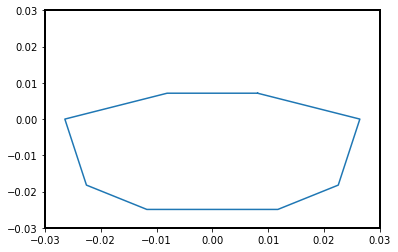

426


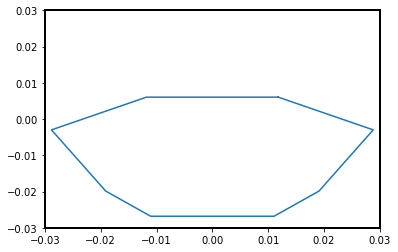

427


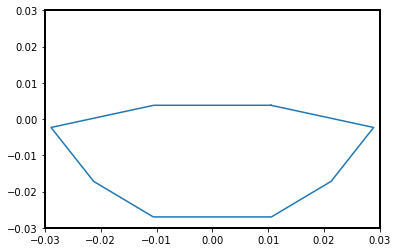

428


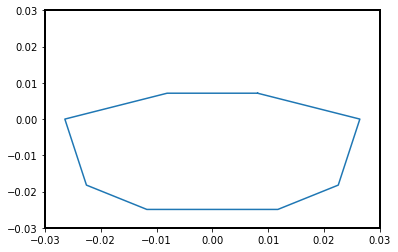

429


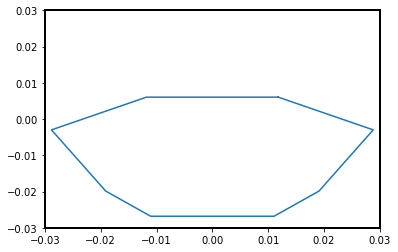

430


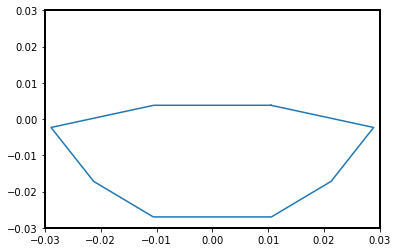

431


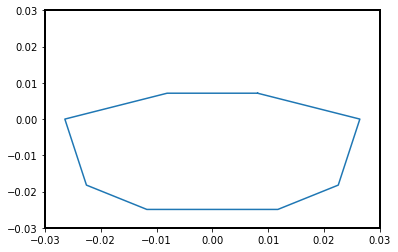

432


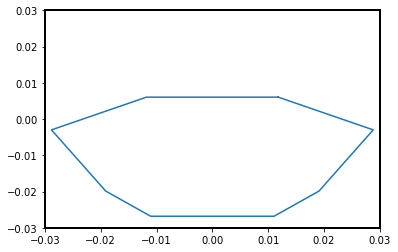

433


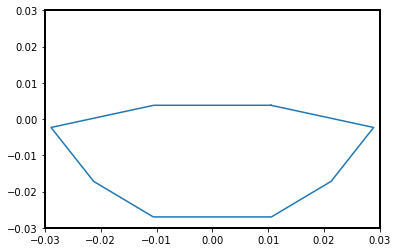

434


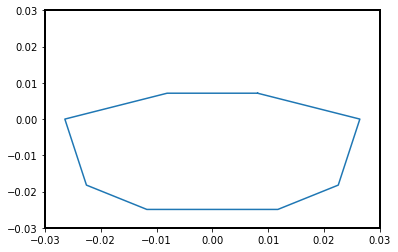

435


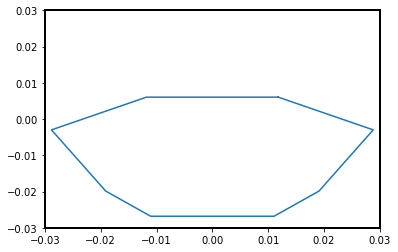

436


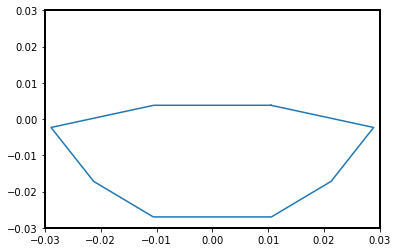

437


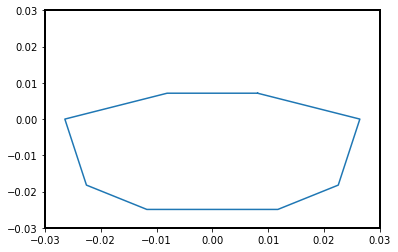

438


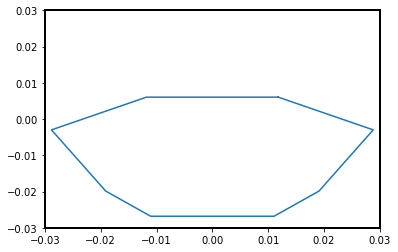

439


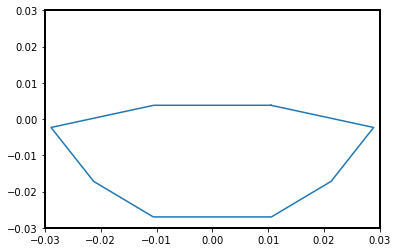

440


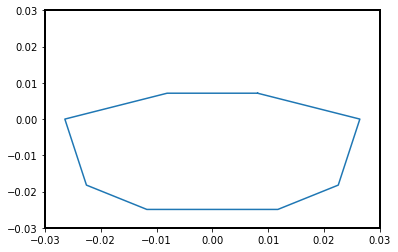

441


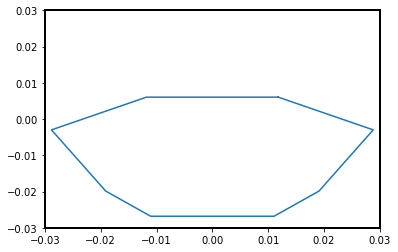

442


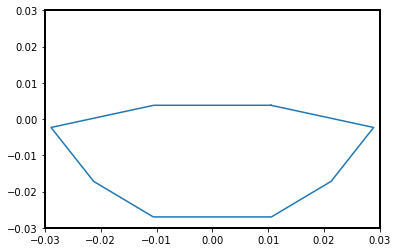

443


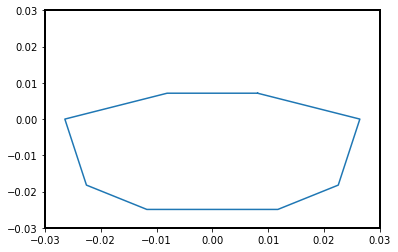

444


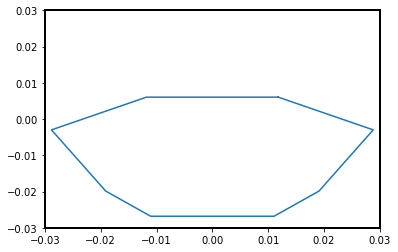

445


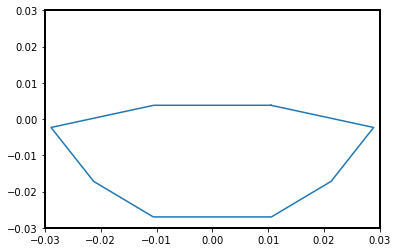

446


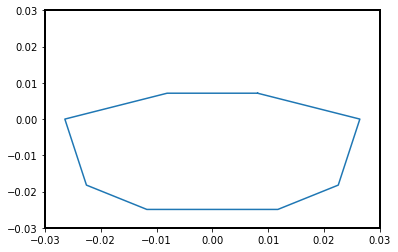

447


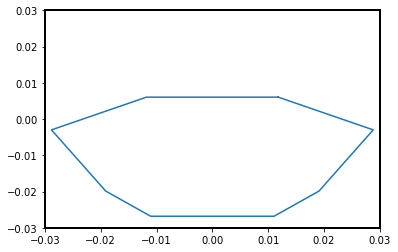

448


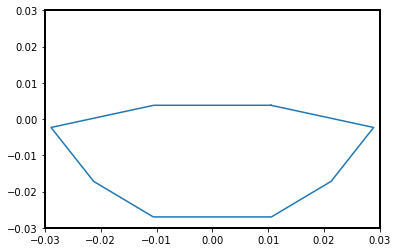

449


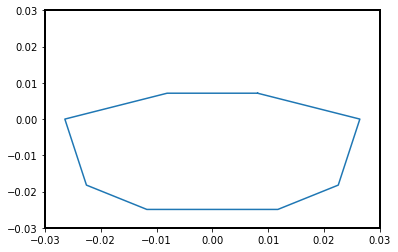

450


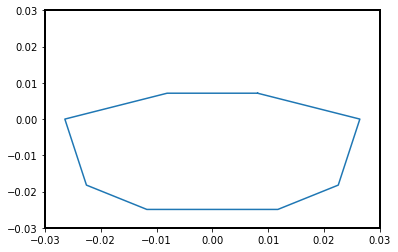

451


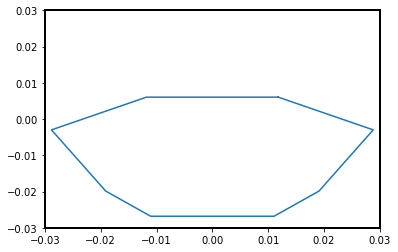

452


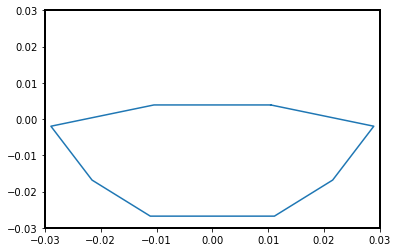

453


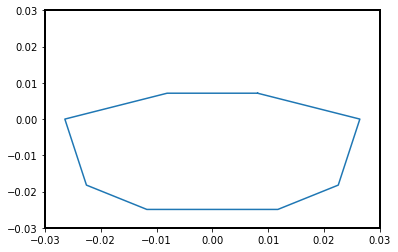

454


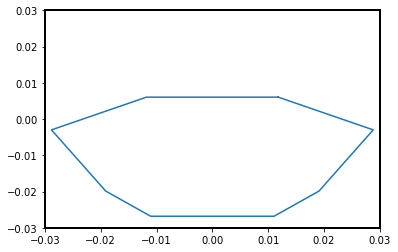

455


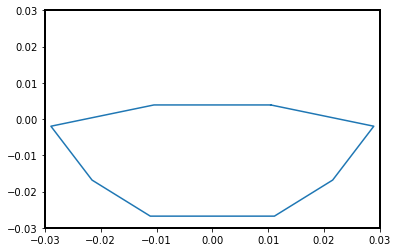

456


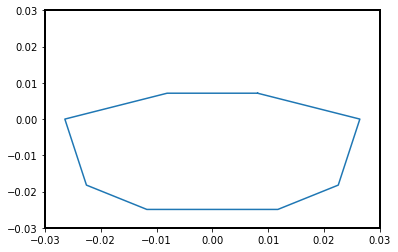

457


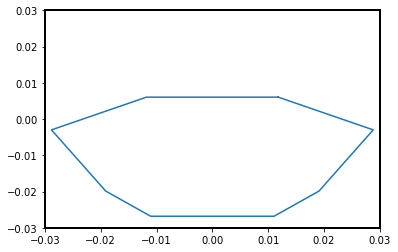

458


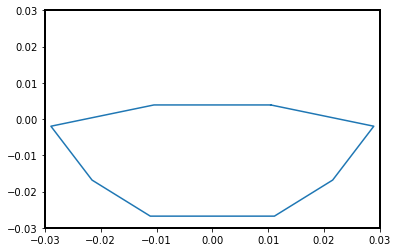

459


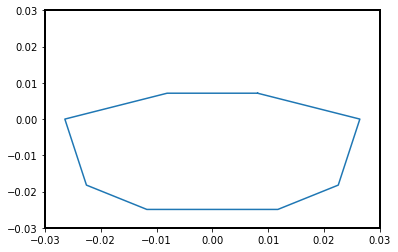

460


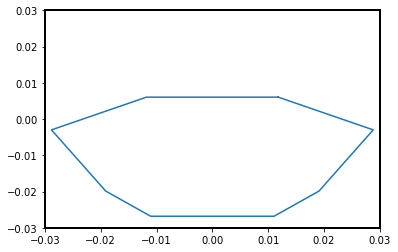

461


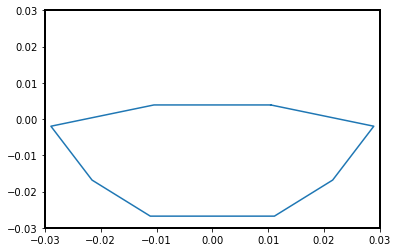

462


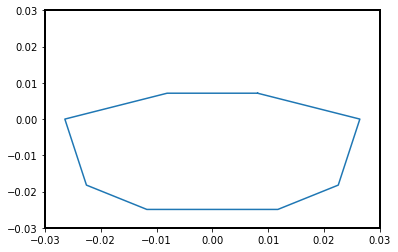

463


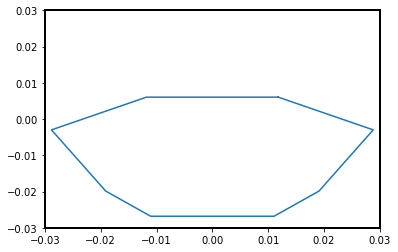

464


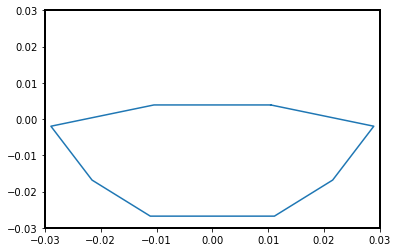

465


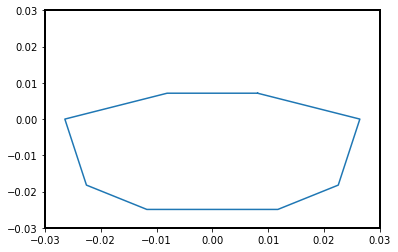

466


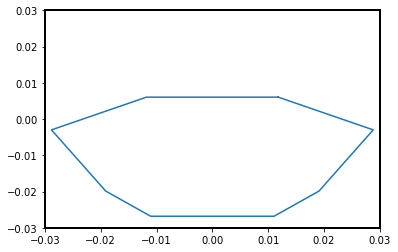

467


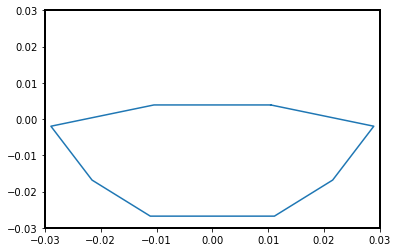

468


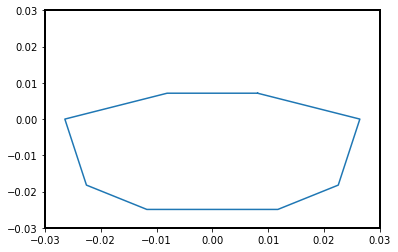

469


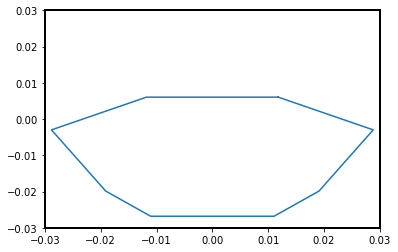

470


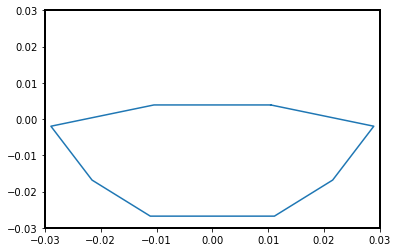

471


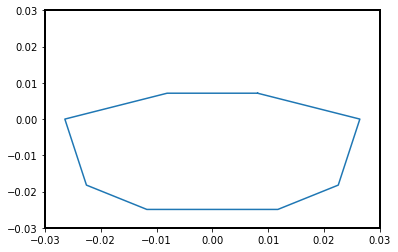

472


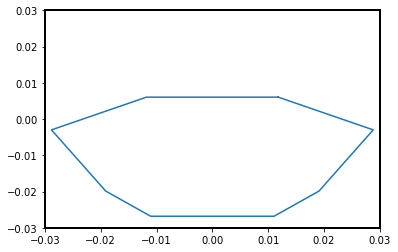

473


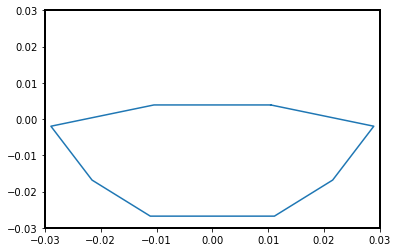

474


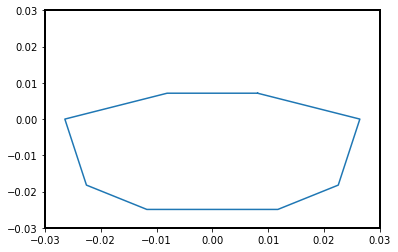

475


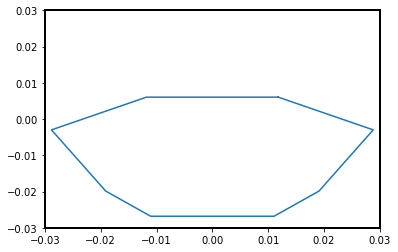

476


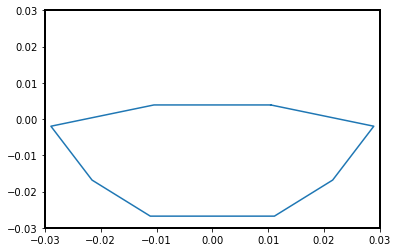

477


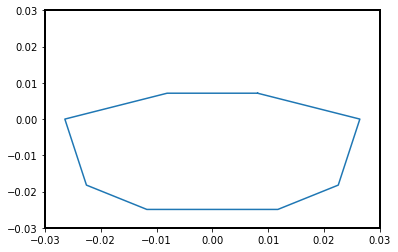

478


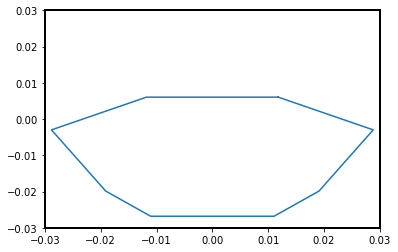

479


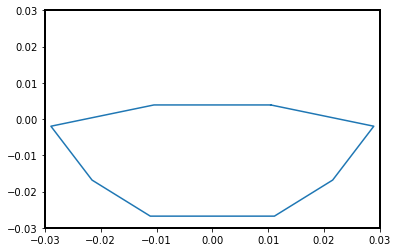

480


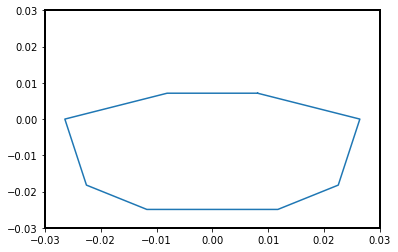

481


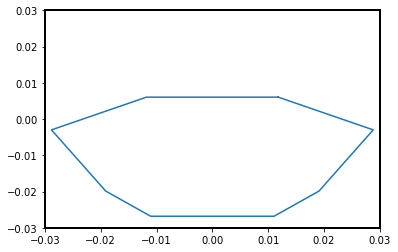

482


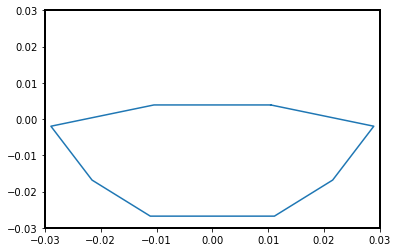

483


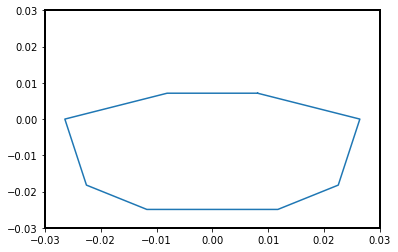

484


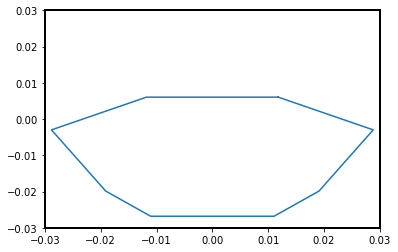

485


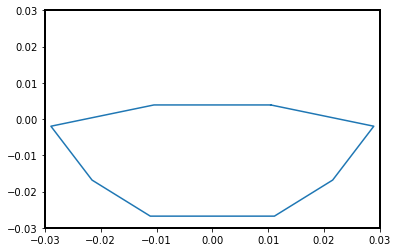

486


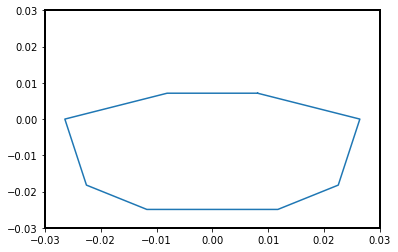

487


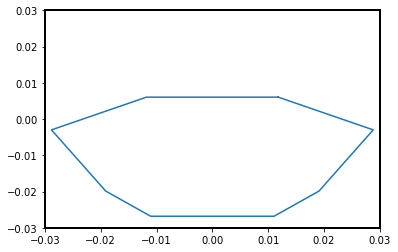

488


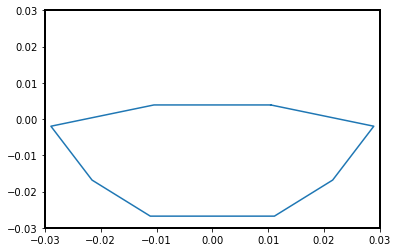

489


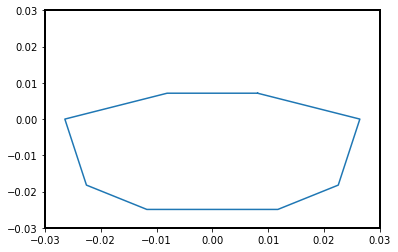

490


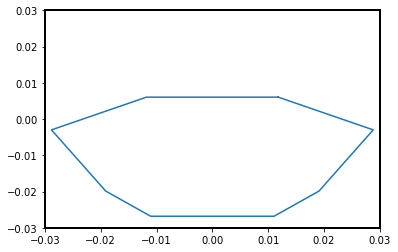

491


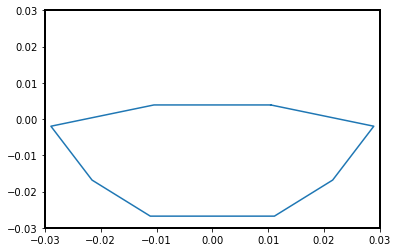

492


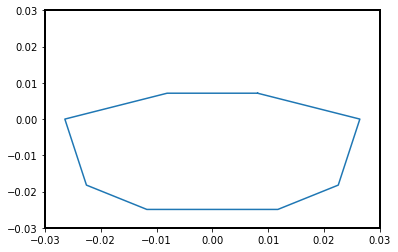

493


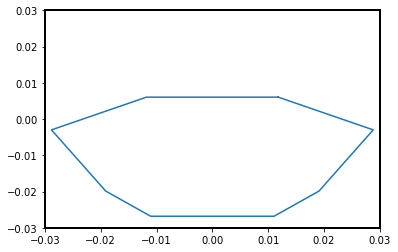

494


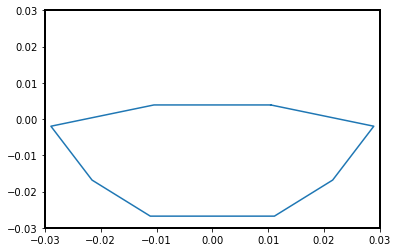

495


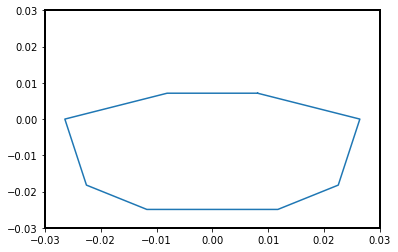

496


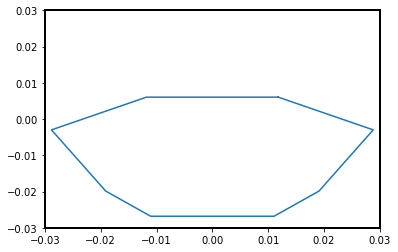

497


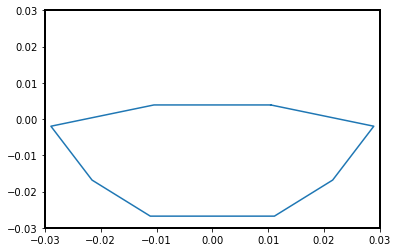

498


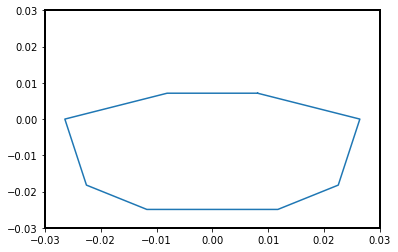

499


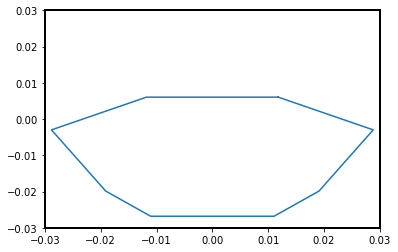

500


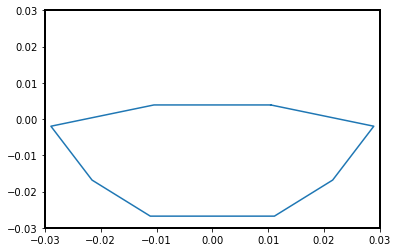

501


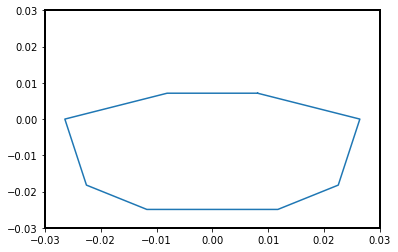

502


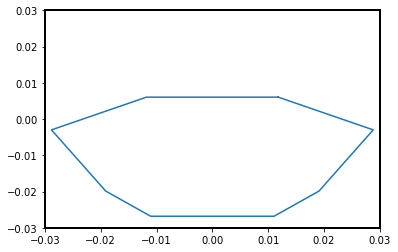

503


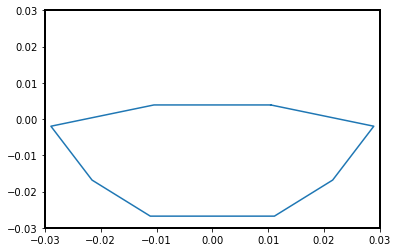

504


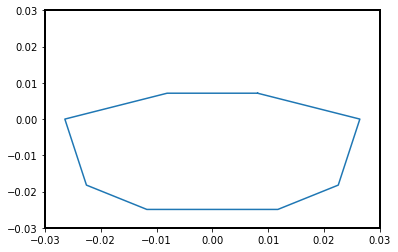

505


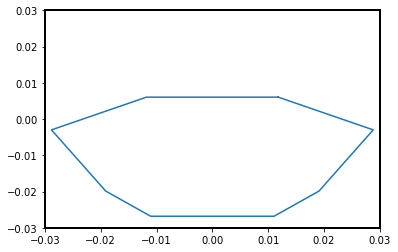

506


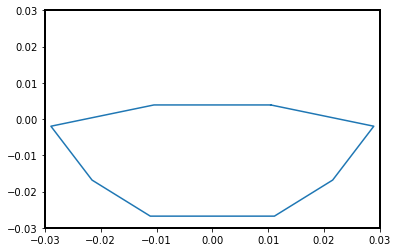

507


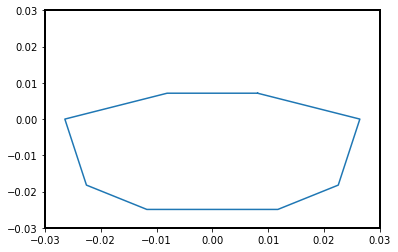

508


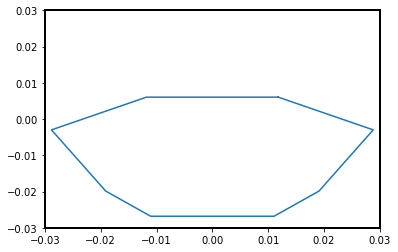

509


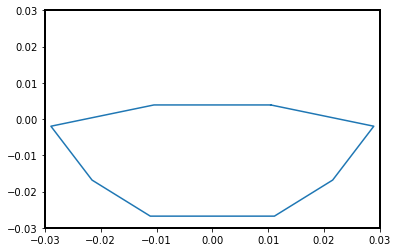

510


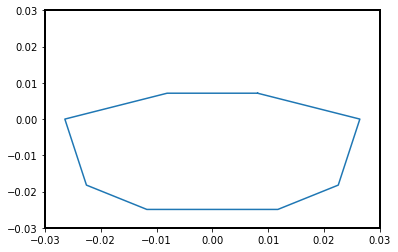

511


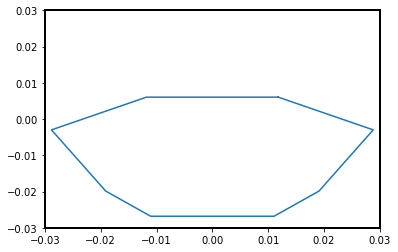

512


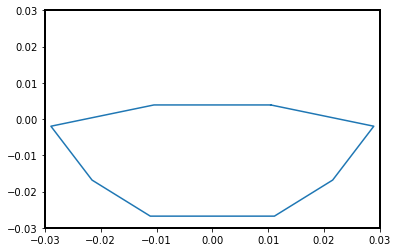

513


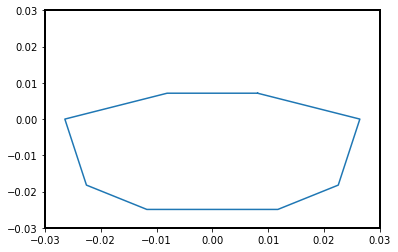

514


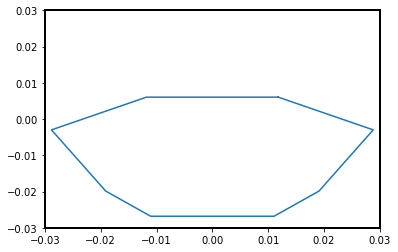

515


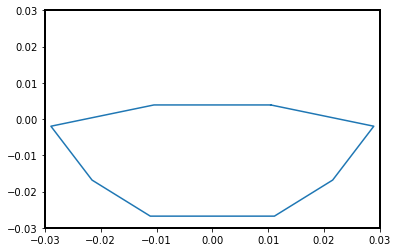

516


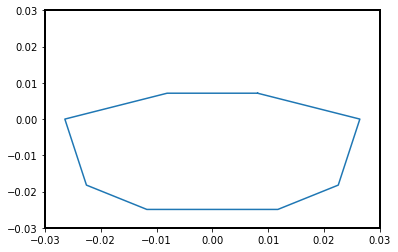

517


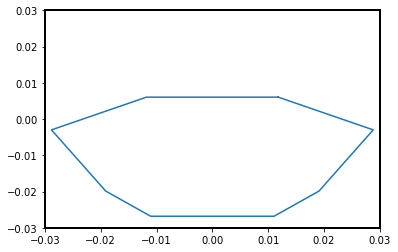

518


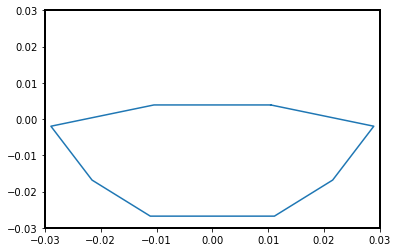

519


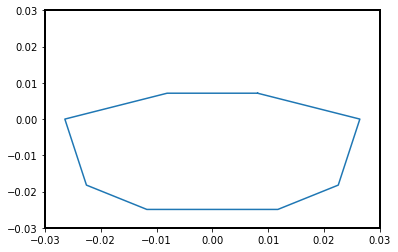

520


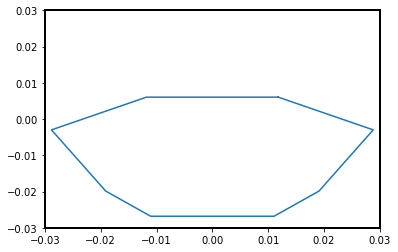

521


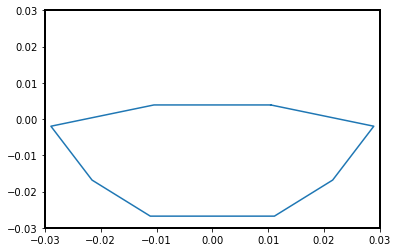

522


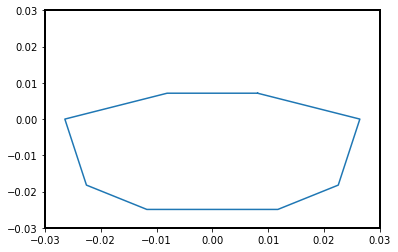

523


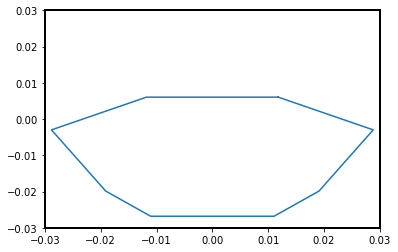

524


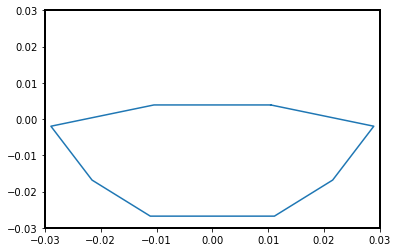

525


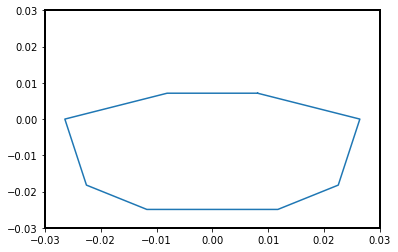

526


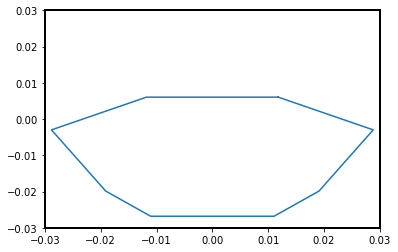

527


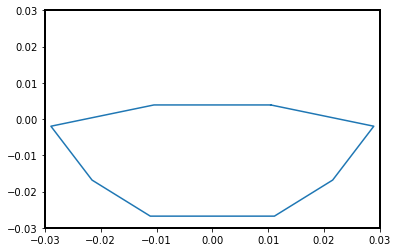

528


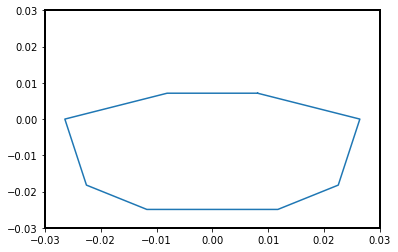

529


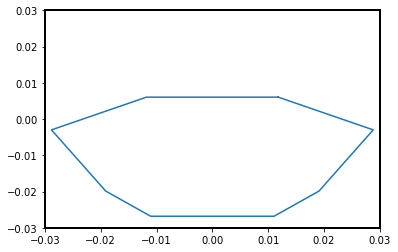

530


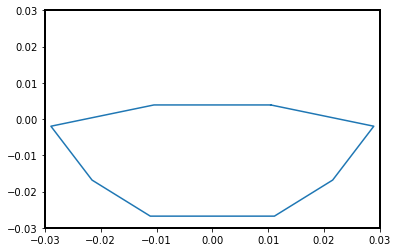

531


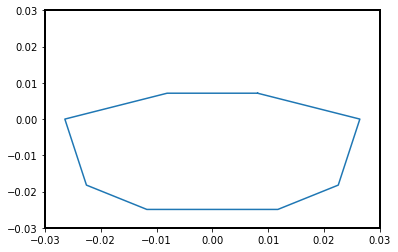

532


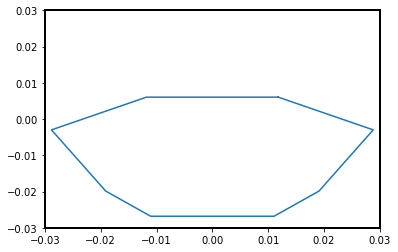

533


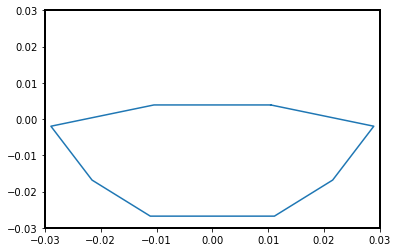

534


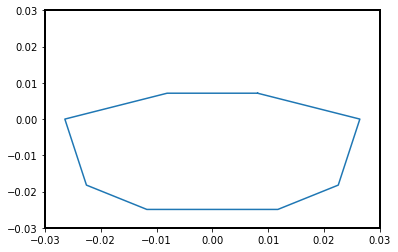

535


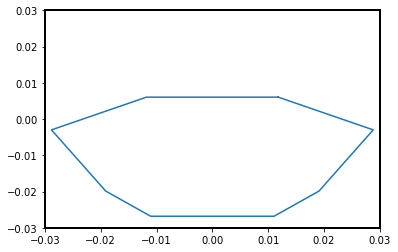

536


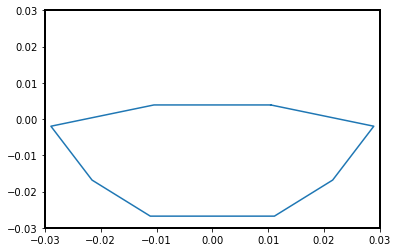

537


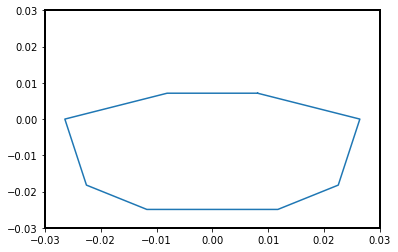

538


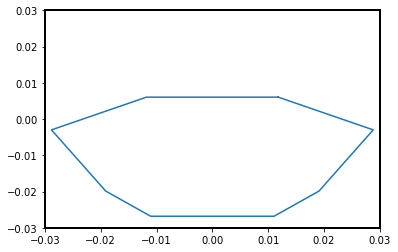

539


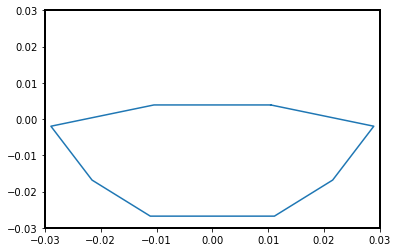

540


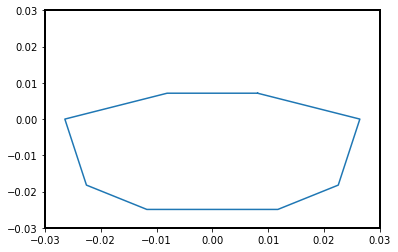

541


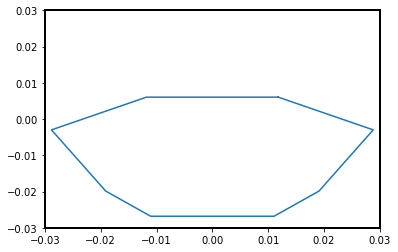

542


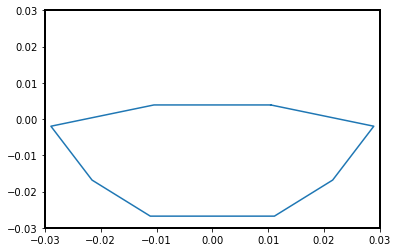

543


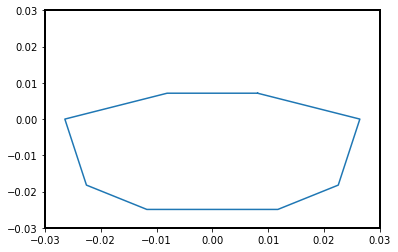

544


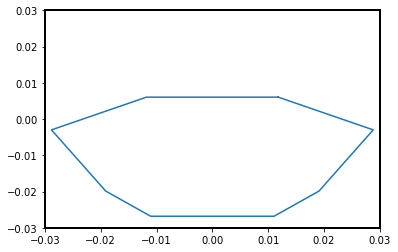

545


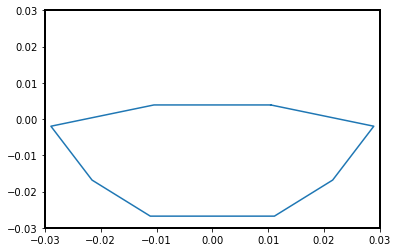

546


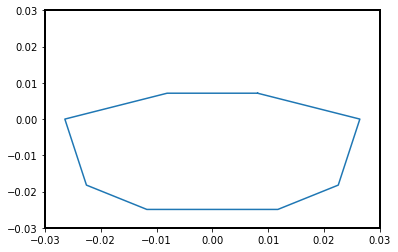

547


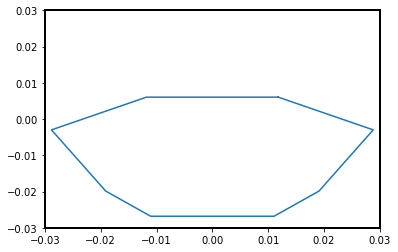

548


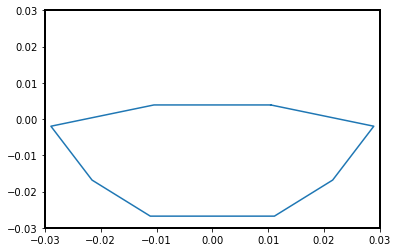

549


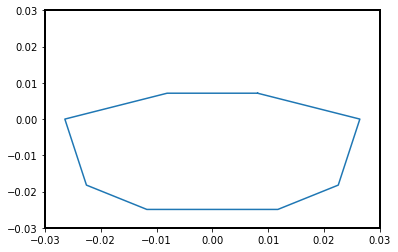

550


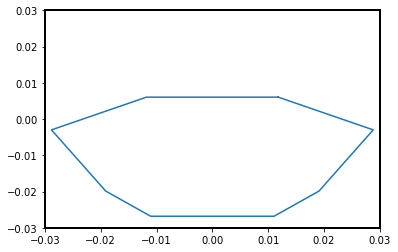

551


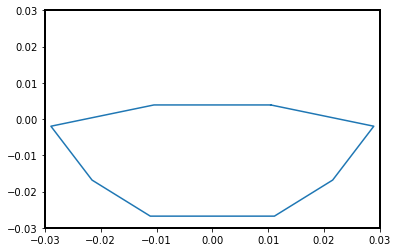

552


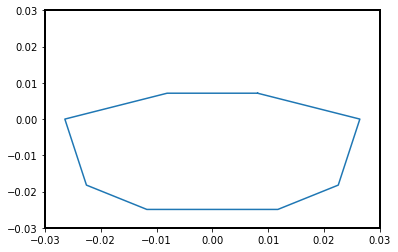

553


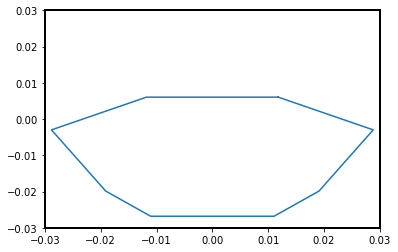

554


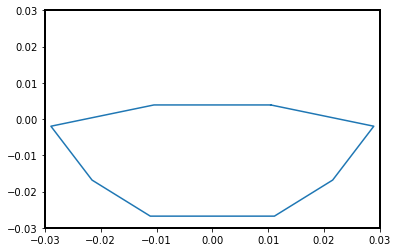

555


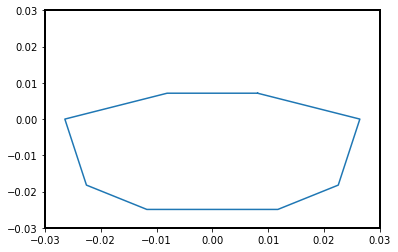

556


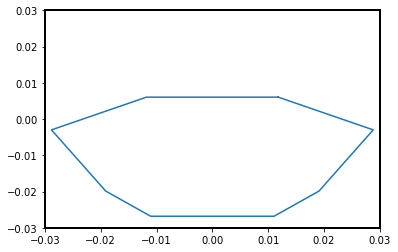

557


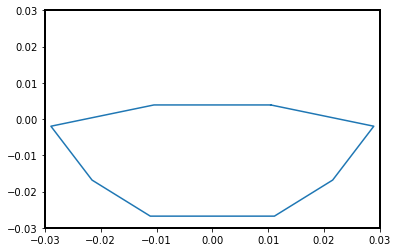

558


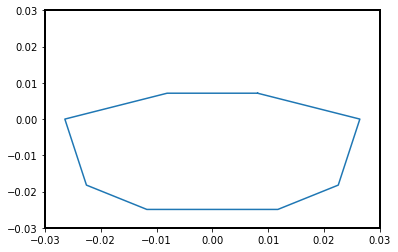

559


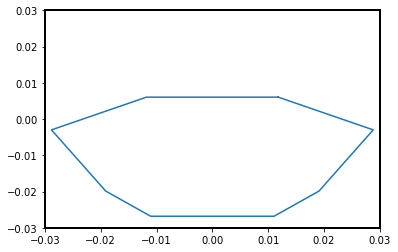

560


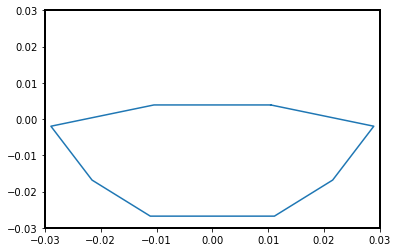

561


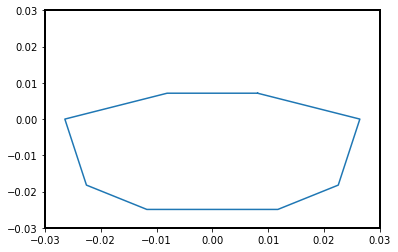

562


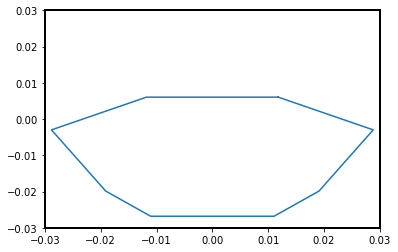

563


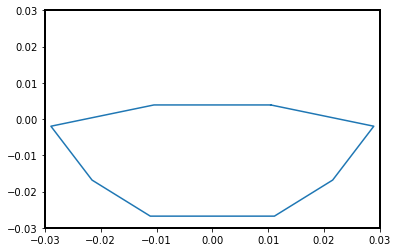

564


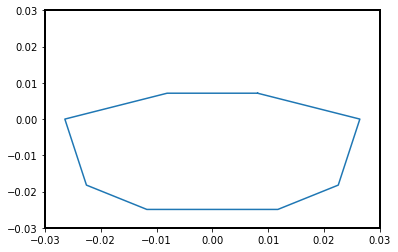

565


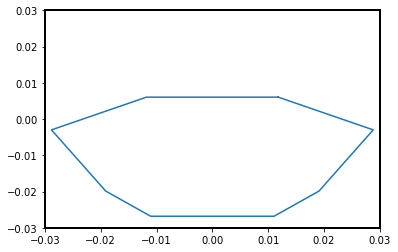

566


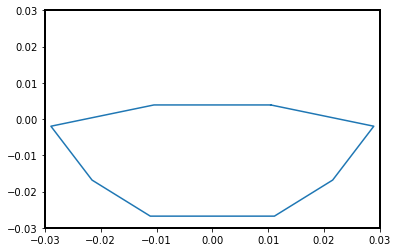

567


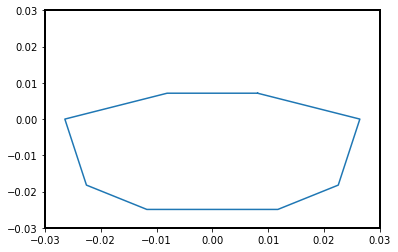

568


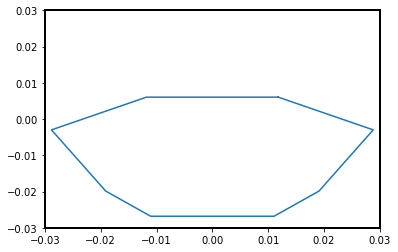

569


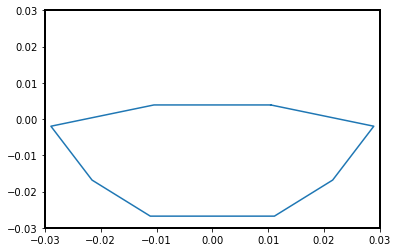

570


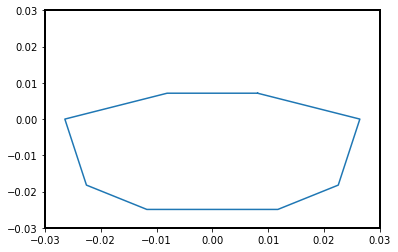

571


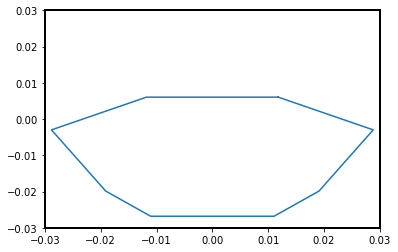

572


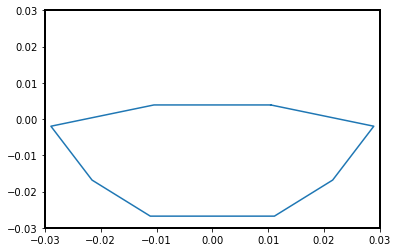

573


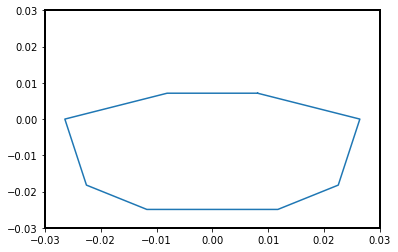

574


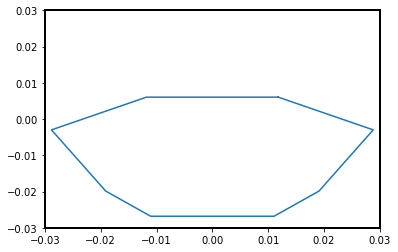

575


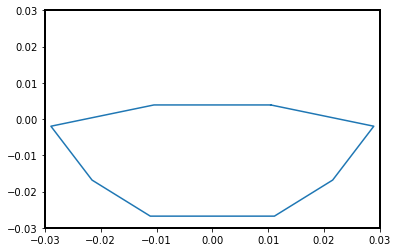

576


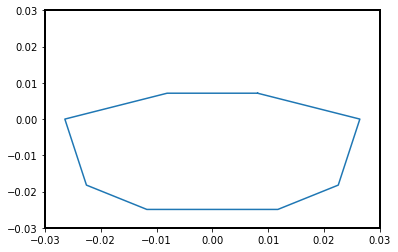

577


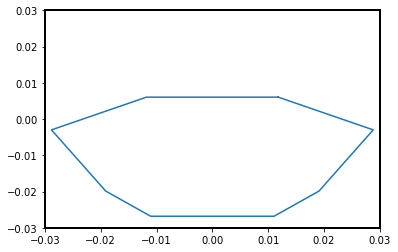

578


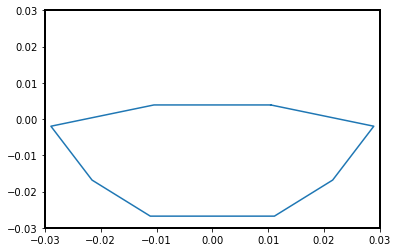

579


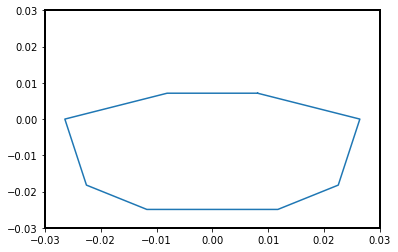

580


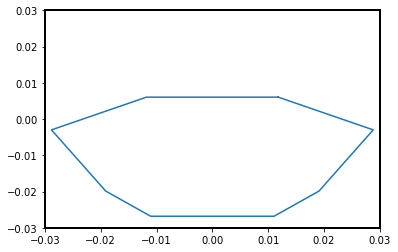

581


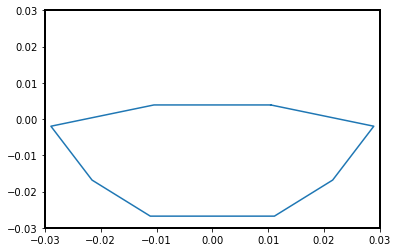

582


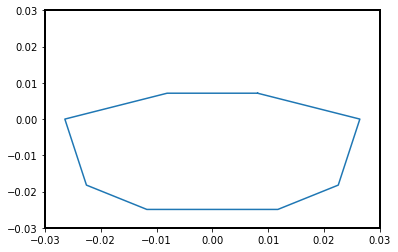

583


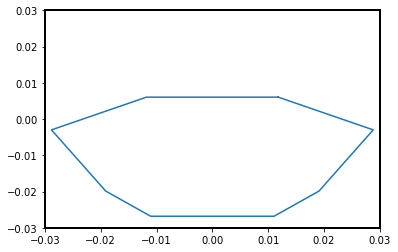

584


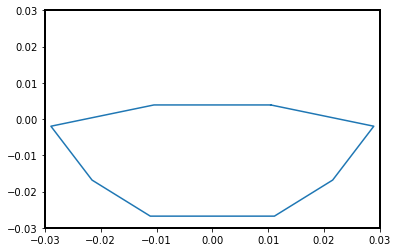

585


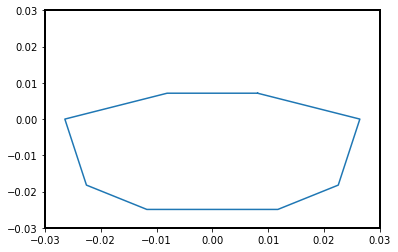

586


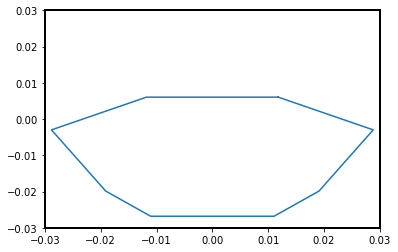

587


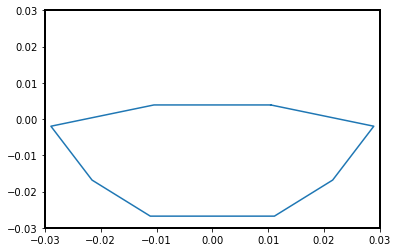

588


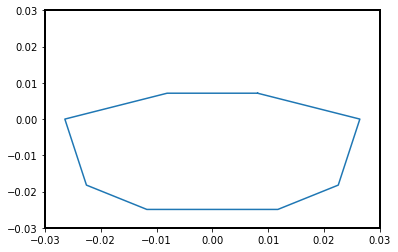

589


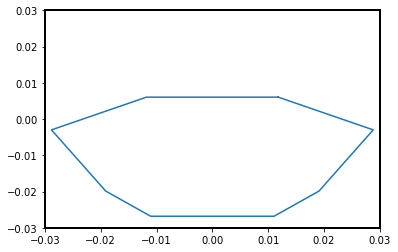

590


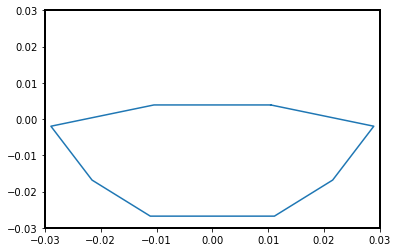

591


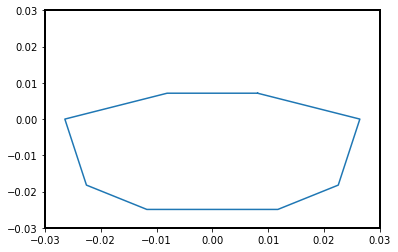

592


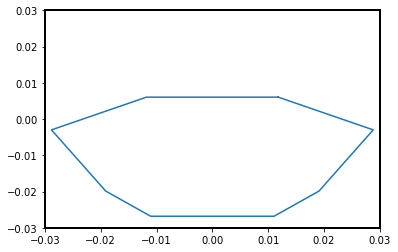

593


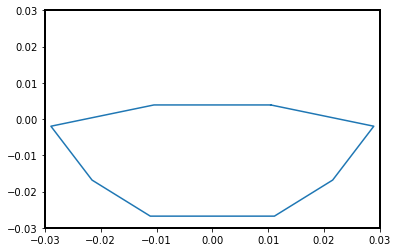

594


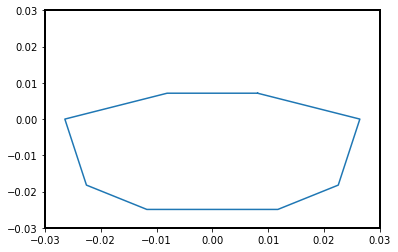

595


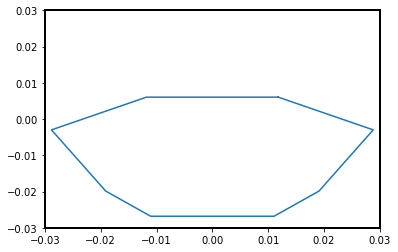

596


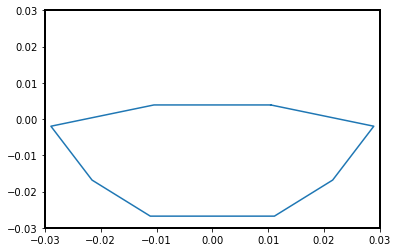

597


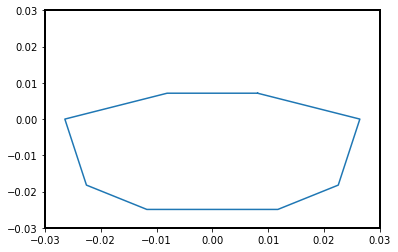

598


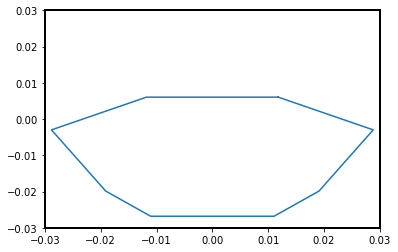

599


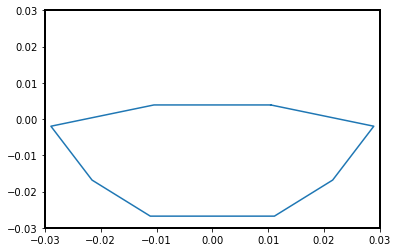

In [12]:
xy=pred.polar_to_cartesian(best)
X = xy[:, 0:8]
Y = xy[:, 8:16]

for i in range(len(best)): 
  
    X_i = np.append(X[i, :], X[i, 0])
    Y_i = np.append(Y[i, :], Y[i, 0])

    ax = plt.gca()
    ax.spines['top'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    print(i)
    plt.plot(Y_i, X_i)
    plt.xlim(-0.03, 0.03)
    plt.ylim(-0.03, 0.03)
    plt.show()

In [34]:
def plot_box():
    # Define data
    methods = ['surrogate-Island-1', 'surrogate-Island-2', 'surrogate-Island-3','Matlab-Island-1','Matlab-Island-2','Matlab-Island-3']
    values = [isl1, isl2, isl3, fitness[:,0],fitness[:,1],fitness[:,2]]
    
    # Create boxplot
    plt.figure(figsize=(12, 8))
    plt.boxplot(values, patch_artist=True, vert=True)
#     plt.boxplot(fitness, patch_artist=True, notch=True, vert=True)
    # Add labels and title
    plt.ylabel('Fitness (MSE)', fontsize=20)
    plt.title('Comparison of surrogate and actual fitness', fontsize=30)
    plt.xticks([1, 2, 3,4,5,6], methods, fontsize=15, rotation=45)
    
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

In [25]:
isl1=[]
isl2=[]
isl3=[]


with open ("Data_bfits_10run.txt","r") as f:
    for line in f:
        p=line.split()
#         print(p[1])
        isl1.append(float(p[1][1:]))
        isl2.append(float(p[2][:]))
        isl3.append(float(p[3][:-1]))

In [10]:
N_I =3
N_P = 54

In [12]:
def get_mse_Mat(tar,n_i,n_p):
#     isl = np.array(list(chain.from_iterable(pop)))
    Gtar = tar[0:41600]
    Gtar = np.reshape(Gtar,(128,25,13))
    Gtar = Gtar[51,:,:]
    
    Star = tar[41600:41728]
    Star = Star[51]
    Rtar = tar[41728:41856]
    Rtar = Rtar[51]
    
    tar1 = np.tile(Gtar, (30,1,1,1))
    tar2 = np.tile(Star, (30,1))
    tar3 = np.tile(Rtar, (30,1))
#     mat_run(isl)
    S11=np.loadtxt('ant128_S11_DE10run.txt',delimiter=',')
    patt = np.loadtxt('ant128_patt_DE10run.txt',delimiter=',')
    imp = np.loadtxt('ant128_imp_DE10run.txt',delimiter=',')
    zo = imp[:,0:128]
    pat=patt/10
    pat=10**pat
    s11=S11/10
    s11=10**s11
    y1 = np.reshape(pat,(30,13,25,128))
    y1=np.swapaxes(y1,1,3)
    y1=y1[:,48:54,:,:]
    
    y2=s11[:,48:54]
    
    y3=zo[:,48:54]
    
    m_1 = np.mean(np.mean(np.mean((y1-tar1)**2, axis = 3), axis = 2), axis =1)
#     m_1 = np.reshape(m_1,(n_i*n_p,325))
    m_2 = np.mean((y2-tar2)**2, axis = 1)
    m_3 = np.mean((y3-tar3)**2, axis = 1)
#     print(np.shape(m_1),np.shape(m_2))
    mse = 0.05*m_1 + 1*m_2 + 0.0001*m_3
#     print(m)    
    return np.reshape(mse,(10,n_i))

In [13]:
# fitness = get_mse_Mat(target,N_I,N_P)

In [15]:
# fitness.shape
# np.savetxt('matlab_fitn10run.txt',fitness)

In [28]:
fitness = np.loadtxt('matlab_fitn10run.txt')

In [42]:
def plot_box2():
    # Define data
    methods = ['surrogate-Isl-1', 'Matlab-Isl-1', 'surrogate-Isl-2', 'Matlab-Isl-2', 'surrogate-Isl-3', 'Matlab-Isl-3']
    values = [isl1, fitness[:,0], isl2, fitness[:,1], isl3, fitness[:,2]]

    # Create boxplot
    plt.figure(figsize=(12, 8))
    bp = plt.boxplot(values, patch_artist=True, vert=True)

#     Change the color of each box plot
    colors = ['deepskyblue', 'deepskyblue','brown', 'brown','green','green']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    # Thickening the mean line
    for median in bp['medians']:
        median.set_linewidth(4)

    # Add labels and title
    plt.ylabel('Fitness (MSE)', fontsize=20)
    plt.title('Comparison of surrogate and actual fitness', fontsize=30)
    plt.xticks([1, 2, 3, 4, 5, 6], methods, fontsize=15, rotation=45)
    plt.yscale('log')
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

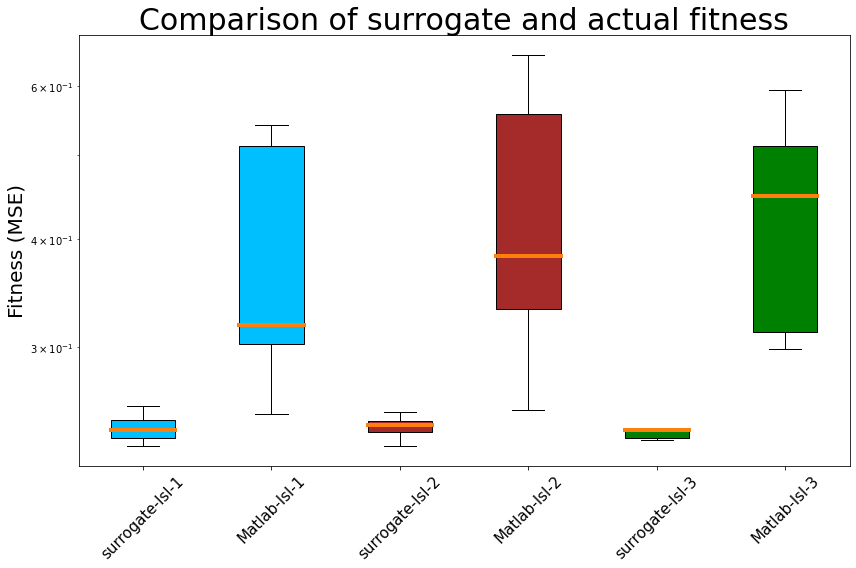

In [43]:
plot_box2()

In [104]:
x= np.loadtxt('X_single.txt')
y= np.loadtxt('Y_single.txt')

In [105]:
x=x[0:8]
y=y[0:8]
xy = np.append(x,y)
xy=xy.reshape(1,16)
xy.shape

(1, 16)

In [106]:
model1=load_model('best_model2.h5')

In [107]:
def prediction(pop):
#     xy = polar_to_cartesian(pop)
    lower = np.array([-0.03,-0.03,-0.03,-0.03,-0.03,-0.03,-0.03,-0.03,
                  -0.03,-0.03,-0.03,-0.03,-0.03,-0.03,-0.03,-0.03])
                  

    upper = np.array([0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,
                  0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03])
                  
    for i in range (np.shape(xy)[0]):
        xy[i] = (xy[i]-lower)/(upper-lower)

    p = model1.predict(xy)
    return(p)

In [109]:
y=prediction(xy)

In [110]:
target2 = np.ones(128)
target2[50:65] = 0.14
target3 = np.zeros(128)
target3[50:65] = 50

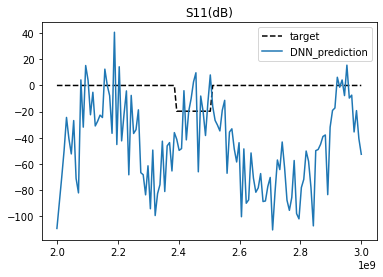

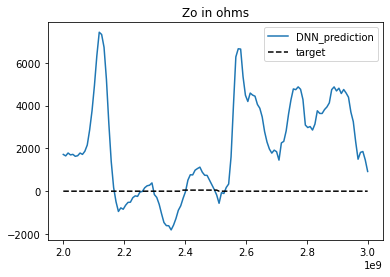

In [111]:
freq =np.linspace(2e9,3e9,128)
y1=y[:,0:41600]
y2=y[:,41600:41728]
y3=y[:,41728:41856]

# y2_te = np.reshape(target1,(1,13,25,128))
# y2_te=np.swapaxes(y2_te,1,3)
y1_te=np.reshape(y1,(1,13,25,128))
y1_te=np.swapaxes(y1_te,1,3)
tgt = np.reshape(target1,(1,128,25,13))

plt.plot(freq,10*log(target2),label='target',color ='black',ls ='--')
plt.plot(freq,(y2[0,:]),label='DNN_prediction')
plt.title('S11(dB)')
plt.legend()
# plt.ylim(0,1)
plt.show()

# ff=105
# patternt = tgt[0,ff,:,:]
# patternD=y1_te[0,ff,:,:]
# fig,(ax1,ax2) = plt.subplots(1,2)

# ax1.imshow(patternt)
# ax1.set_title('tgt_pattern')
# ax2.imshow(patternD)
# ax2.set_title('Dnn_Pattern')
# plt.show()


#Imp 1D plot
plt.plot(freq,y3[0,:],label='DNN_prediction')
plt.plot(freq,target3,label='target',color ='black',ls ='--')
plt.title('Zo in ohms')
plt.legend()
# plt.ylim(0,1)
plt.show()

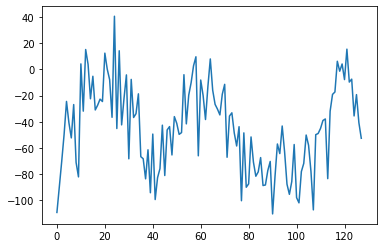

In [86]:
plt.plot(y2[0,:])